In [24]:
rm -rf ATML-PA-4

In [25]:
!git clone -b test http://github.com/Zapy67/ATML-PA-4 

Cloning into 'ATML-PA-4'...
remote: Enumerating objects: 158, done.
remote: Counting objects: 100% (84/84), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 158 (delta 75), reused 72 (delta 64), pack-reused 74 (from 1)
Receiving objects: 100% (158/158), 389.90 KiB | 13.00 MiB/s, done.
Resolving deltas: 100% (101/101), done.


In [73]:
!git pull  http://github.com/Zapy67/ATML-PA-4 test


remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (1/1), done.
remote: Total 5 (delta 4), reused 5 (delta 4), pack-reused 0 (from 0)
Unpacking objects: 100% (5/5), 1.99 KiB | 203.00 KiB/s, done.
From http://github.com/Zapy67/ATML-PA-4
 * branch            test       -> FETCH_HEAD
Updating 4c0b449..8989c21
Fast-forward
 fed_lib/fed_methods.py | 93 ++++++++++++++++++++++++++++++++++++++------------
 fedsam.ipynb           | 43 +++++++++++------------
 2 files changed, 94 insertions(+), 42 deletions(-)


In [67]:
%cd ATML-PA-4

[Errno 2] No such file or directory: 'ATML-PA-4'
/kaggle/working/ATML-PA-4


In [68]:
!ls

'ATML - PA 4.pdf'   fedprox.ipynb       README.md     task4.ipynb
 data		    fedsam.ipynb        task1.ipynb
 fedgh.ipynb	    fedscaffold.ipynb   task2.ipynb
 fed_lib	    LICENSE	        task3.ipynb


#  FedSAM on heterogeneous domains

In [69]:
import torch
import torch.nn as nn

In [75]:
import fed_lib
import importlib
importlib.reload(fed_lib)


<module 'fed_lib' from '/kaggle/working/ATML-PA-4/fed_lib/__init__.py'>

In [16]:
!pip install fedlab

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.2/60.2 kB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 105.3 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 79.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 29.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 17.7 MB/s eta 0:0

In [76]:
from fed_lib import fed_methods, fed_model, utils
importlib.reload(utils)
importlib.reload(fed_methods)
importlib.reload(fed_model)

<module 'fed_lib.fed_model' from '/kaggle/working/ATML-PA-4/fed_lib/fed_model.py'>

In [40]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [9]:
trainset, testset = utils.get_cifar10()

In [24]:
client_loaders = utils.get_heterogenous_domains(trainset, clients=5, balance=False, min_require_size=20, alpha=2, verbose=True)

In [26]:
for idx, loader in enumerate(client_loaders):
    utils.calculate_label_skew(loader.dataset)

Label Distribution (P(Y)): [0.039 0.197 0.102 0.121 0.082 0.167 0.02  0.031 0.115 0.126]
Entropy of Label Distribution H(P(Y)): 2.0409007076773857
Normalized Entropy of Label Distribution: 0.8863519154567302

Label Distribution (P(Y)): [0.082 0.079 0.135 0.053 0.128 0.1   0.034 0.144 0.244]
Entropy of Label Distribution H(P(Y)): 1.9797306458058213
Normalized Entropy of Label Distribution: 0.9010142459838699

Label Distribution (P(Y)): [0.042 0.035 0.101 0.016 0.078 0.123 0.207 0.043 0.072 0.283]
Entropy of Label Distribution H(P(Y)): 1.9221358831956668
Normalized Entropy of Label Distribution: 0.8347730075401114

Label Distribution (P(Y)): [0.112 0.132 0.102 0.209 0.087 0.025 0.151 0.182]
Entropy of Label Distribution H(P(Y)): 1.8967389565875812
Normalized Entropy of Label Distribution: 0.9121386288432701

Label Distribution (P(Y)): [0.242 0.035 0.055 0.092 0.128 0.076 0.104 0.105 0.063 0.1  ]
Entropy of Label Distribution H(P(Y)): 2.0809519365200044
Normalized Entropy of Label Distrib

In [27]:
client_weights = [len(client.dataset.indices)/len(trainset.dataset) for client in client_loaders]
domains = None

In [28]:
client_weights

[0.22526, 0.20142, 0.1886, 0.20208, 0.18264]

In [ ]:
def fed_avg_exp(partition:str = 'dirichlet', alpha:float = 0.1, num_clients:int = 5, fed_method_class = None, **kwargs):
        fed = fed_model.Federation(
                num_clients=num_clients, federate_method=None, partition=partition, domains=None, alpha=alpha, device = device, batch_size=32, pin_memory=False, num_workers=2)
        
        client_loaders = fed.client_dataloaders
        client_weights = [len(client.dataset.indices)/len(trainset) for client in client_loaders]
        method_instance = None

        # if fed_method_class == fed_methods.FedSAM:
        #         rho = kwargs.get('rho', 0.05) # Safer access with default
        #         method_instance = fed_method_class(sam_rho=rho, 
        #                 num_local_steps=int(len(trainset)/num_clients), 
        #                 client_aggregation_weights=client_weights)
        
        # elif fed_method_class == fed_methods.FedGH:
        method_instance = fed_methods.FedGH(num_local_steps=5, 
                        client_aggregation_weights=client_weights)
        # else:
        #         raise Exception()
        

        fed.set_method(method_instance)
        fed.train(25, lr=1e-3, verbose=False, momentum=0, weight_decay=0)


In [ ]:
alphas = [0.1, 0.5, 1, 5, 10, 50, 100]
for alpha in alphas:
    fed_avg_exp(num_clients = 5, alpha=alpha)


--- Round 1/25 ---
Training Clients
Training Client 1/5
Training Client 2/5
Training Client 3/5
Training Client 4/5
Training Client 5/5
Training Server
Evaluate on round 1:


FedSAM  | Test Loss: 161.6193, Test Acc: 10.09%

--- Round 2/25 ---
Training Clients
Training Client 1/5


Training Client 2/5
Training Client 3/5
Training Client 4/5
Training Client 5/5
Training Server
Evaluate on round 2:


FedSAM  | Test Loss: 142.2099, Test Acc: 20.16%

--- Round 3/25 ---
Training Clients
Training Client 1/5
Training Client 2/5
Training Client 3/5
Training Client 4/5
Training Client 5/5
Training Server
Evaluate on round 3:


FedSAM  | Test Loss: 122.6762, Test Acc: 29.86%

--- Round 4/25 ---
Training Clients
Training Client 1/5


Training Client 2/5
Training Client 3/5
Training Client 4/5
Training Client 5/5
Training Server
Evaluate on round 4:


FedSAM  | Test Loss: 108.1219, Test Acc: 38.40%

--- Round 5/25 ---
Training Clients
Training Client 1/5


Training Client 2/5
Training Client 3/5
Training Client 4/5
Training Client 5/5
Training Server
Evaluate on round 5:


FedSAM  | Test Loss: 105.7138, Test Acc: 39.90%

--- Round 6/25 ---
Training Clients
Training Client 1/5


Training Client 2/5
Training Client 3/5
Training Client 4/5
Training Client 5/5
Training Server
Evaluate on round 6:


FedSAM  | Test Loss: 96.4539, Test Acc: 45.81%

--- Round 7/25 ---
Training Clients
Training Client 1/5


Training Client 2/5
Training Client 3/5
Training Client 4/5
Training Client 5/5
Training Server
Evaluate on round 7:


FedSAM  | Test Loss: 93.4448, Test Acc: 49.37%

--- Round 8/25 ---
Training Clients
Training Client 1/5
Training Client 2/5
Training Client 3/5
Training Client 4/5
Training Client 5/5
Training Server
Evaluate on round 8:


FedSAM  | Test Loss: 94.2320, Test Acc: 48.86%

--- Round 9/25 ---
Training Clients
Training Client 1/5


Training Client 2/5
Training Client 3/5
Training Client 4/5
Training Client 5/5
Training Server
Evaluate on round 9:


FedSAM  | Test Loss: 85.5753, Test Acc: 53.84%

--- Round 10/25 ---
Training Clients
Training Client 1/5


Training Client 2/5
Training Client 3/5
Training Client 4/5
Training Client 5/5
Training Server
Evaluate on round 10:


FedSAM  | Test Loss: 82.4394, Test Acc: 54.41%

--- Round 11/25 ---
Training Clients
Training Client 1/5
Training Client 2/5
Training Client 3/5
Training Client 4/5
Training Client 5/5
Training Server
Evaluate on round 11:


FedSAM  | Test Loss: 79.9503, Test Acc: 56.23%

--- Round 12/25 ---
Training Clients
Training Client 1/5


Training Client 2/5
Training Client 3/5
Training Client 4/5
Training Client 5/5
Training Server
Evaluate on round 12:


FedSAM  | Test Loss: 79.0616, Test Acc: 56.98%

--- Round 13/25 ---
Training Clients
Training Client 1/5
Training Client 2/5
Training Client 3/5
Training Client 4/5
Training Client 5/5
Training Server
Evaluate on round 13:


FedSAM  | Test Loss: 80.5123, Test Acc: 55.95%

--- Round 14/25 ---
Training Clients
Training Client 1/5


Training Client 2/5
Training Client 3/5
Training Client 4/5
Training Client 5/5
Training Server
Evaluate on round 14:


FedSAM  | Test Loss: 77.9085, Test Acc: 57.48%

--- Round 15/25 ---
Training Clients
Training Client 1/5


Training Client 2/5
Training Client 3/5
Training Client 4/5
Training Client 5/5
Training Server
Evaluate on round 15:


FedSAM  | Test Loss: 75.7102, Test Acc: 58.13%

--- Round 16/25 ---
Training Clients
Training Client 1/5


Training Client 2/5
Training Client 3/5
Training Client 4/5
Training Client 5/5
Training Server
Evaluate on round 16:


FedSAM  | Test Loss: 74.2934, Test Acc: 58.45%

--- Round 17/25 ---
Training Clients
Training Client 1/5


Training Client 2/5
Training Client 3/5
Training Client 4/5
Training Client 5/5
Training Server
Evaluate on round 17:


FedSAM  | Test Loss: 73.7096, Test Acc: 58.82%

--- Round 18/25 ---
Training Clients
Training Client 1/5
Training Client 2/5
Training Client 3/5
Training Client 4/5
Training Client 5/5
Training Server
Evaluate on round 18:


FedSAM  | Test Loss: 72.6578, Test Acc: 59.48%

--- Round 19/25 ---
Training Clients
Training Client 1/5
Training Client 2/5
Training Client 3/5
Training Client 4/5
Training Client 5/5
Training Server
Evaluate on round 19:


FedSAM  | Test Loss: 74.1128, Test Acc: 58.83%

--- Round 20/25 ---
Training Clients
Training Client 1/5
Training Client 2/5
Training Client 3/5
Training Client 4/5
Training Client 5/5
Training Server
Evaluate on round 20:


FedSAM  | Test Loss: 73.0999, Test Acc: 59.84%

--- Round 21/25 ---
Training Clients
Training Client 1/5


Training Client 2/5
Training Client 3/5
Training Client 4/5
Training Client 5/5
Training Server
Evaluate on round 21:


FedSAM  | Test Loss: 70.6097, Test Acc: 60.40%

--- Round 22/25 ---
Training Clients
Training Client 1/5
Training Client 2/5
Training Client 3/5
Training Client 4/5
Training Client 5/5
Training Server
Evaluate on round 22:


FedSAM  | Test Loss: 70.0767, Test Acc: 61.26%

--- Round 23/25 ---
Training Clients
Training Client 1/5
Training Client 2/5
Training Client 3/5
Training Client 4/5
Training Client 5/5
Training Server
Evaluate on round 23:


FedSAM  | Test Loss: 67.3165, Test Acc: 62.09%

--- Round 24/25 ---
Training Clients
Training Client 1/5


Training Client 2/5
Training Client 3/5
Training Client 4/5
Training Client 5/5
Training Server
Evaluate on round 24:


FedSAM  | Test Loss: 67.3878, Test Acc: 62.88%

--- Round 25/25 ---
Training Clients
Training Client 1/5
Training Client 2/5
Training Client 3/5
Training Client 4/5
Training Client 5/5
Training Server
Evaluate on round 25:


FedSAM  | Test Loss: 70.2725, Test Acc: 60.40%
Training Complete!


FedSAM  | Test Loss: 70.2725, Test Acc: 60.40%
Comparing Server vs Central

Top 5 layers with largest L2 differences:
Layer                                         L2 Diff     Rel Diff
backbone.2.block.3.weight                3.445643e+00 4.771733e-01
backbone.2.block.0.weight                3.397414e+00 4.725708e-01
backbone.0.block.3.weight                3.073626e+00 6.787650e-01
backbone.1.block.0.weight                3.008131e+00 5.560031e-01
backbone.1.block.3.weight                2.976712e+00 5.539098e-01
Overall Statistics:
Total L2 difference:        8.180571e+00
Total parameters:           551,466

--- Round 1/25 ---
Training Clients
Training Client 1/5
Training Client 2/5
Training Client 3/5
Training Client 4/5
Training Client 5/5
Training Server
Evaluate on round 1:


FedSAM  | Test Loss: 143.9419, Test Acc: 15.43%

--- Round 2/25 ---
Training Clients
Training Client 1/5
Training Client 2/5
Training Client 3/5
Training Client 4/5
Training Client 5/5
Training Server
Evaluate on round 2:


FedSAM  | Test Loss: 97.3059, Test Acc: 43.61%

--- Round 3/25 ---
Training Clients
Training Client 1/5


Training Client 2/5
Training Client 3/5
Training Client 4/5
Training Client 5/5
Training Server
Evaluate on round 3:


FedSAM  | Test Loss: 83.6673, Test Acc: 52.63%

--- Round 4/25 ---
Training Clients
Training Client 1/5
Training Client 2/5
Training Client 3/5
Training Client 4/5
Training Client 5/5
Training Server
Evaluate on round 4:


FedSAM  | Test Loss: 76.8214, Test Acc: 56.14%

--- Round 5/25 ---
Training Clients
Training Client 1/5
Training Client 2/5
Training Client 3/5
Training Client 4/5
Training Client 5/5
Training Server
Evaluate on round 5:


FedSAM  | Test Loss: 68.6313, Test Acc: 61.85%

--- Round 6/25 ---
Training Clients
Training Client 1/5
Training Client 2/5
Training Client 3/5
Training Client 4/5
Training Client 5/5
Training Server
Evaluate on round 6:


FedSAM  | Test Loss: 61.7879, Test Acc: 65.30%

--- Round 7/25 ---
Training Clients
Training Client 1/5


Training Client 2/5
Training Client 3/5
Training Client 4/5
Training Client 5/5
Training Server
Evaluate on round 7:


FedSAM  | Test Loss: 57.3770, Test Acc: 68.01%

--- Round 8/25 ---
Training Clients
Training Client 1/5


Training Client 2/5
Training Client 3/5
Training Client 4/5
Training Client 5/5
Training Server
Evaluate on round 8:


FedSAM  | Test Loss: 56.9874, Test Acc: 68.29%

--- Round 9/25 ---
Training Clients
Training Client 1/5


Training Client 2/5
Training Client 3/5
Training Client 4/5
Training Client 5/5
Training Server
Evaluate on round 9:


FedSAM  | Test Loss: 55.0469, Test Acc: 68.96%

--- Round 10/25 ---
Training Clients
Training Client 1/5


Training Client 2/5
Training Client 3/5
Training Client 4/5
Training Client 5/5
Training Server
Evaluate on round 10:


FedSAM  | Test Loss: 52.1459, Test Acc: 70.71%

--- Round 11/25 ---
Training Clients
Training Client 1/5


Training Client 2/5
Training Client 3/5
Training Client 4/5
Training Client 5/5
Training Server
Evaluate on round 11:


FedSAM  | Test Loss: 49.1387, Test Acc: 72.32%

--- Round 12/25 ---
Training Clients
Training Client 1/5


Training Client 2/5
Training Client 3/5
Training Client 4/5
Training Client 5/5
Training Server
Evaluate on round 12:


FedSAM  | Test Loss: 48.2075, Test Acc: 73.12%

--- Round 13/25 ---
Training Clients
Training Client 1/5


Training Client 2/5
Training Client 3/5
Training Client 4/5
Training Client 5/5
Training Server
Evaluate on round 13:


FedSAM  | Test Loss: 47.5290, Test Acc: 73.76%

--- Round 14/25 ---
Training Clients
Training Client 1/5
Training Client 2/5
Training Client 3/5
Training Client 4/5
Training Client 5/5
Training Server
Evaluate on round 14:


FedSAM  | Test Loss: 45.7793, Test Acc: 74.46%

--- Round 15/25 ---
Training Clients
Training Client 1/5


Training Client 2/5
Training Client 3/5
Training Client 4/5
Training Client 5/5
Training Server
Evaluate on round 15:


FedSAM  | Test Loss: 45.6639, Test Acc: 74.56%

--- Round 16/25 ---
Training Clients
Training Client 1/5
Training Client 2/5
Training Client 3/5
Training Client 4/5
Training Client 5/5
Training Server
Evaluate on round 16:


FedSAM  | Test Loss: 43.6958, Test Acc: 75.39%

--- Round 17/25 ---
Training Clients
Training Client 1/5


Training Client 2/5
Training Client 3/5
Training Client 4/5
Training Client 5/5
Training Server
Evaluate on round 17:


FedSAM  | Test Loss: 43.0611, Test Acc: 76.15%

--- Round 18/25 ---
Training Clients
Training Client 1/5


Training Client 2/5
Training Client 3/5
Training Client 4/5
Training Client 5/5
Training Server
Evaluate on round 18:


FedSAM  | Test Loss: 43.0582, Test Acc: 76.44%

--- Round 19/25 ---
Training Clients
Training Client 1/5
Training Client 2/5
Training Client 3/5
Training Client 4/5
Training Client 5/5
Training Server
Evaluate on round 19:


FedSAM  | Test Loss: 41.2806, Test Acc: 77.25%

--- Round 20/25 ---
Training Clients
Training Client 1/5


Training Client 2/5
Training Client 3/5
Training Client 4/5
Training Client 5/5
Training Server
Evaluate on round 20:


FedSAM  | Test Loss: 42.8362, Test Acc: 76.69%

--- Round 21/25 ---
Training Clients
Training Client 1/5
Training Client 2/5
Training Client 3/5
Training Client 4/5
Training Client 5/5
Training Server
Evaluate on round 21:


FedSAM  | Test Loss: 39.6280, Test Acc: 78.21%

--- Round 22/25 ---
Training Clients
Training Client 1/5
Training Client 2/5
Training Client 3/5
Training Client 4/5
Training Client 5/5
Training Server
Evaluate on round 22:


FedSAM  | Test Loss: 38.4748, Test Acc: 79.26%

--- Round 23/25 ---
Training Clients
Training Client 1/5


Training Client 2/5
Training Client 3/5
Training Client 4/5
Training Client 5/5
Training Server
Evaluate on round 23:


FedSAM  | Test Loss: 39.5261, Test Acc: 78.51%

--- Round 24/25 ---
Training Clients
Training Client 1/5


Training Client 2/5
Training Client 3/5
Training Client 4/5
Training Client 5/5
Training Server
Evaluate on round 24:


FedSAM  | Test Loss: 39.1289, Test Acc: 78.94%

--- Round 25/25 ---
Training Clients
Training Client 1/5


Training Client 2/5
Training Client 3/5
Training Client 4/5
Training Client 5/5
Training Server
Evaluate on round 25:


FedSAM  | Test Loss: 37.1358, Test Acc: 80.16%
Training Complete!


FedSAM  | Test Loss: 37.1358, Test Acc: 80.16%
Comparing Server vs Central

Top 5 layers with largest L2 differences:
Layer                                         L2 Diff     Rel Diff
backbone.2.block.3.weight                4.660819e+00 5.929879e-01
backbone.2.block.0.weight                4.251644e+00 5.543960e-01
backbone.0.block.3.weight                3.822998e+00 7.578933e-01
backbone.1.block.0.weight                3.758902e+00 6.493476e-01
backbone.1.block.3.weight                3.661922e+00 6.327086e-01
Overall Statistics:
Total L2 difference:        1.041252e+01
Total parameters:           551,466

--- Round 1/25 ---
Training Clients
Training Client 1/5
Training Client 2/5
Training Client 3/5
Training Client 4/5
Training Client 5/5
Training Server
Evaluate on round 1:


FedSAM  | Test Loss: 136.0780, Test Acc: 22.85%

--- Round 2/25 ---
Training Clients
Training Client 1/5


Training Client 2/5
Training Client 3/5
Training Client 4/5
Training Client 5/5
Training Server
Evaluate on round 2:


FedSAM  | Test Loss: 98.8808, Test Acc: 43.71%

--- Round 3/25 ---
Training Clients
Training Client 1/5


Training Client 2/5
Training Client 3/5
Training Client 4/5
Training Client 5/5
Training Server
Evaluate on round 3:


FedSAM  | Test Loss: 83.3264, Test Acc: 50.83%

--- Round 4/25 ---
Training Clients
Training Client 1/5


Training Client 2/5
Training Client 3/5
Training Client 4/5
Training Client 5/5
Training Server
Evaluate on round 4:


FedSAM  | Test Loss: 76.2430, Test Acc: 55.99%

--- Round 5/25 ---
Training Clients
Training Client 1/5
Training Client 2/5
Training Client 3/5
Training Client 4/5
Training Client 5/5
Training Server
Evaluate on round 5:


FedSAM  | Test Loss: 70.5035, Test Acc: 59.52%

--- Round 6/25 ---
Training Clients
Training Client 1/5
Training Client 2/5
Training Client 3/5
Training Client 4/5
Training Client 5/5
Training Server
Evaluate on round 6:


FedSAM  | Test Loss: 67.4564, Test Acc: 61.85%

--- Round 7/25 ---
Training Clients
Training Client 1/5
Training Client 2/5
Training Client 3/5
Training Client 4/5
Training Client 5/5
Training Server
Evaluate on round 7:


FedSAM  | Test Loss: 61.6426, Test Acc: 65.04%

--- Round 8/25 ---
Training Clients
Training Client 1/5


Training Client 2/5
Training Client 3/5
Training Client 4/5
Training Client 5/5
Training Server
Evaluate on round 8:


FedSAM  | Test Loss: 58.7959, Test Acc: 66.53%

--- Round 9/25 ---
Training Clients
Training Client 1/5


Training Client 2/5
Training Client 3/5
Training Client 4/5
Training Client 5/5
Training Server
Evaluate on round 9:


FedSAM  | Test Loss: 54.9181, Test Acc: 69.21%

--- Round 10/25 ---
Training Clients
Training Client 1/5
Training Client 2/5
Training Client 3/5
Training Client 4/5
Training Client 5/5
Training Server
Evaluate on round 10:


FedSAM  | Test Loss: 52.6151, Test Acc: 70.66%

--- Round 11/25 ---
Training Clients
Training Client 1/5


Training Client 2/5
Training Client 3/5
Training Client 4/5
Training Client 5/5
Training Server
Evaluate on round 11:


FedSAM  | Test Loss: 51.6720, Test Acc: 71.30%

--- Round 12/25 ---
Training Clients
Training Client 1/5
Training Client 2/5
Training Client 3/5
Training Client 4/5
Training Client 5/5
Training Server
Evaluate on round 12:


FedSAM  | Test Loss: 52.3329, Test Acc: 70.76%

--- Round 13/25 ---
Training Clients
Training Client 1/5
Training Client 2/5
Training Client 3/5
Training Client 4/5
Training Client 5/5
Training Server
Evaluate on round 13:


FedSAM  | Test Loss: 49.0153, Test Acc: 72.31%

--- Round 14/25 ---
Training Clients
Training Client 1/5


Training Client 2/5
Training Client 3/5
Training Client 4/5
Training Client 5/5
Training Server
Evaluate on round 14:


FedSAM  | Test Loss: 48.6140, Test Acc: 72.93%

--- Round 15/25 ---
Training Clients
Training Client 1/5


Training Client 2/5
Training Client 3/5
Training Client 4/5
Training Client 5/5
Training Server
Evaluate on round 15:


FedSAM  | Test Loss: 48.5880, Test Acc: 73.57%

--- Round 16/25 ---
Training Clients
Training Client 1/5
Training Client 2/5
Training Client 3/5
Training Client 4/5
Training Client 5/5
Training Server
Evaluate on round 16:


FedSAM  | Test Loss: 45.7842, Test Acc: 74.76%

--- Round 17/25 ---
Training Clients
Training Client 1/5
Training Client 2/5
Training Client 3/5
Training Client 4/5
Training Client 5/5
Training Server
Evaluate on round 17:


FedSAM  | Test Loss: 44.9501, Test Acc: 75.06%

--- Round 18/25 ---
Training Clients
Training Client 1/5
Training Client 2/5
Training Client 3/5
Training Client 4/5
Training Client 5/5
Training Server
Evaluate on round 18:


FedSAM  | Test Loss: 43.9366, Test Acc: 75.40%

--- Round 19/25 ---
Training Clients
Training Client 1/5


Training Client 2/5
Training Client 3/5
Training Client 4/5
Training Client 5/5
Training Server
Evaluate on round 19:


FedSAM  | Test Loss: 43.2572, Test Acc: 76.16%

--- Round 20/25 ---
Training Clients
Training Client 1/5


Training Client 2/5
Training Client 3/5
Training Client 4/5
Training Client 5/5
Training Server
Evaluate on round 20:


FedSAM  | Test Loss: 44.2999, Test Acc: 75.81%

--- Round 21/25 ---
Training Clients
Training Client 1/5
Training Client 2/5
Training Client 3/5
Training Client 4/5
Training Client 5/5
Training Server
Evaluate on round 21:


FedSAM  | Test Loss: 42.6472, Test Acc: 76.84%

--- Round 22/25 ---
Training Clients
Training Client 1/5


Training Client 2/5
Training Client 3/5
Training Client 4/5
Training Client 5/5
Training Server
Evaluate on round 22:


FedSAM  | Test Loss: 43.6067, Test Acc: 76.00%

--- Round 23/25 ---
Training Clients
Training Client 1/5


Training Client 2/5
Training Client 3/5
Training Client 4/5
Training Client 5/5
Training Server
Evaluate on round 23:


FedSAM  | Test Loss: 41.9314, Test Acc: 77.13%

--- Round 24/25 ---
Training Clients
Training Client 1/5


Training Client 2/5
Training Client 3/5
Training Client 4/5
Training Client 5/5
Training Server
Evaluate on round 24:


FedSAM  | Test Loss: 40.2041, Test Acc: 78.05%

--- Round 25/25 ---
Training Clients
Training Client 1/5


Training Client 2/5
Training Client 3/5
Training Client 4/5
Training Client 5/5
Training Server
Evaluate on round 25:


FedSAM  | Test Loss: 41.6553, Test Acc: 77.55%
Training Complete!


FedSAM  | Test Loss: 41.6553, Test Acc: 77.55%
Comparing Server vs Central

Top 5 layers with largest L2 differences:
Layer                                         L2 Diff     Rel Diff
backbone.2.block.3.weight                4.773739e+00 6.045460e-01
backbone.2.block.0.weight                4.443193e+00 5.752250e-01
backbone.1.block.3.weight                3.806054e+00 6.500488e-01
backbone.1.block.0.weight                3.803859e+00 6.492556e-01
backbone.0.block.3.weight                3.779711e+00 7.595964e-01
Overall Statistics:
Total L2 difference:        1.066208e+01
Total parameters:           551,466

--- Round 1/25 ---
Training Clients
Training Client 1/5
Training Client 2/5
Training Client 3/5
Training Client 4/5
Training Client 5/5
Training Server
Evaluate on round 1:


FedSAM  | Test Loss: 133.2279, Test Acc: 19.54%

--- Round 2/25 ---
Training Clients
Training Client 1/5


Training Client 2/5
Training Client 3/5
Training Client 4/5
Training Client 5/5
Training Server
Evaluate on round 2:


FedSAM  | Test Loss: 86.4352, Test Acc: 50.93%

--- Round 3/25 ---
Training Clients
Training Client 1/5


Training Client 2/5
Training Client 3/5
Training Client 4/5
Training Client 5/5
Training Server
Evaluate on round 3:


FedSAM  | Test Loss: 72.4084, Test Acc: 59.30%

--- Round 4/25 ---
Training Clients
Training Client 1/5


Training Client 2/5
Training Client 3/5
Training Client 4/5
Training Client 5/5
Training Server
Evaluate on round 4:


FedSAM  | Test Loss: 63.6886, Test Acc: 64.67%

--- Round 5/25 ---
Training Clients
Training Client 1/5
Training Client 2/5
Training Client 3/5
Training Client 4/5
Training Client 5/5
Training Server
Evaluate on round 5:


FedSAM  | Test Loss: 59.8983, Test Acc: 66.62%

--- Round 6/25 ---
Training Clients
Training Client 1/5
Training Client 2/5
Training Client 3/5
Training Client 4/5
Training Client 5/5
Training Server
Evaluate on round 6:


FedSAM  | Test Loss: 54.5419, Test Acc: 69.86%

--- Round 7/25 ---
Training Clients
Training Client 1/5
Training Client 2/5
Training Client 3/5
Training Client 4/5
Training Client 5/5
Training Server
Evaluate on round 7:


FedSAM  | Test Loss: 50.5005, Test Acc: 72.02%

--- Round 8/25 ---
Training Clients
Training Client 1/5
Training Client 2/5
Training Client 3/5
Training Client 4/5
Training Client 5/5
Training Server
Evaluate on round 8:


FedSAM  | Test Loss: 49.1917, Test Acc: 72.98%

--- Round 9/25 ---
Training Clients
Training Client 1/5
Training Client 2/5
Training Client 3/5
Training Client 4/5
Training Client 5/5
Training Server
Evaluate on round 9:


FedSAM  | Test Loss: 46.9151, Test Acc: 74.41%

--- Round 10/25 ---
Training Clients
Training Client 1/5
Training Client 2/5
Training Client 3/5
Training Client 4/5
Training Client 5/5
Training Server
Evaluate on round 10:


FedSAM  | Test Loss: 45.3707, Test Acc: 75.30%

--- Round 11/25 ---
Training Clients
Training Client 1/5
Training Client 2/5
Training Client 3/5
Training Client 4/5
Training Client 5/5
Training Server
Evaluate on round 11:


FedSAM  | Test Loss: 44.8286, Test Acc: 75.30%

--- Round 12/25 ---
Training Clients
Training Client 1/5
Training Client 2/5
Training Client 3/5
Training Client 4/5
Training Client 5/5
Training Server
Evaluate on round 12:


FedSAM  | Test Loss: 41.3890, Test Acc: 77.18%

--- Round 13/25 ---
Training Clients
Training Client 1/5


Training Client 2/5
Training Client 3/5
Training Client 4/5
Training Client 5/5
Training Server
Evaluate on round 13:


FedSAM  | Test Loss: 43.4387, Test Acc: 76.42%

--- Round 14/25 ---
Training Clients
Training Client 1/5
Training Client 2/5
Training Client 3/5
Training Client 4/5
Training Client 5/5
Training Server
Evaluate on round 14:


FedSAM  | Test Loss: 39.7276, Test Acc: 78.24%

--- Round 15/25 ---
Training Clients
Training Client 1/5


Training Client 2/5
Training Client 3/5
Training Client 4/5
Training Client 5/5
Training Server
Evaluate on round 15:


FedSAM  | Test Loss: 39.7388, Test Acc: 78.25%

--- Round 16/25 ---
Training Clients
Training Client 1/5


Training Client 2/5
Training Client 3/5
Training Client 4/5
Training Client 5/5
Training Server
Evaluate on round 16:


FedSAM  | Test Loss: 39.7958, Test Acc: 78.52%

--- Round 17/25 ---
Training Clients
Training Client 1/5


Training Client 2/5
Training Client 3/5
Training Client 4/5
Training Client 5/5
Training Server
Evaluate on round 17:


FedSAM  | Test Loss: 38.2485, Test Acc: 79.12%

--- Round 18/25 ---
Training Clients
Training Client 1/5
Training Client 2/5
Training Client 3/5
Training Client 4/5
Training Client 5/5
Training Server
Evaluate on round 18:


FedSAM  | Test Loss: 36.6820, Test Acc: 79.92%

--- Round 19/25 ---
Training Clients
Training Client 1/5
Training Client 2/5
Training Client 3/5
Training Client 4/5
Training Client 5/5
Training Server
Evaluate on round 19:


FedSAM  | Test Loss: 36.0363, Test Acc: 80.60%

--- Round 20/25 ---
Training Clients
Training Client 1/5
Training Client 2/5
Training Client 3/5
Training Client 4/5
Training Client 5/5
Training Server
Evaluate on round 20:


FedSAM  | Test Loss: 35.7668, Test Acc: 80.83%

--- Round 21/25 ---
Training Clients
Training Client 1/5


Training Client 2/5
Training Client 3/5
Training Client 4/5
Training Client 5/5
Training Server
Evaluate on round 21:


FedSAM  | Test Loss: 36.4354, Test Acc: 80.41%

--- Round 22/25 ---
Training Clients
Training Client 1/5
Training Client 2/5
Training Client 3/5
Training Client 4/5
Training Client 5/5
Training Server
Evaluate on round 22:


FedSAM  | Test Loss: 35.3679, Test Acc: 81.07%

--- Round 23/25 ---
Training Clients
Training Client 1/5


Training Client 2/5
Training Client 3/5
Training Client 4/5
Training Client 5/5
Training Server
Evaluate on round 23:


FedSAM  | Test Loss: 33.9782, Test Acc: 81.79%

--- Round 24/25 ---
Training Clients
Training Client 1/5


Training Client 2/5
Training Client 3/5
Training Client 4/5
Training Client 5/5
Training Server
Evaluate on round 24:


FedSAM  | Test Loss: 33.2506, Test Acc: 82.46%

--- Round 25/25 ---
Training Clients
Training Client 1/5


Training Client 2/5
Training Client 3/5
Training Client 4/5
Training Client 5/5
Training Server
Evaluate on round 25:


FedSAM  | Test Loss: 32.9801, Test Acc: 82.50%
Training Complete!


FedSAM  | Test Loss: 32.9801, Test Acc: 82.50%
Comparing Server vs Central

Top 5 layers with largest L2 differences:
Layer                                         L2 Diff     Rel Diff
backbone.2.block.3.weight                5.206989e+00 6.417151e-01
backbone.2.block.0.weight                4.886776e+00 6.145810e-01
backbone.1.block.0.weight                4.220234e+00 6.919570e-01
backbone.1.block.3.weight                4.154628e+00 6.798761e-01
backbone.0.block.3.weight                4.056353e+00 7.752453e-01
Overall Statistics:
Total L2 difference:        1.161912e+01
Total parameters:           551,466

--- Round 1/25 ---
Training Clients
Training Client 1/5
Training Client 2/5
Training Client 3/5
Training Client 4/5
Training Client 5/5
Training Server
Evaluate on round 1:


FedSAM  | Test Loss: 150.4680, Test Acc: 17.35%

--- Round 2/25 ---
Training Clients
Training Client 1/5


Training Client 2/5
Training Client 3/5
Training Client 4/5
Training Client 5/5
Training Server
Evaluate on round 2:


FedSAM  | Test Loss: 88.9622, Test Acc: 49.46%

--- Round 3/25 ---
Training Clients
Training Client 1/5


Training Client 2/5
Training Client 3/5
Training Client 4/5
Training Client 5/5
Training Server
Evaluate on round 3:


FedSAM  | Test Loss: 74.8606, Test Acc: 58.44%

--- Round 4/25 ---
Training Clients
Training Client 1/5


Training Client 2/5
Training Client 3/5
Training Client 4/5
Training Client 5/5
Training Server
Evaluate on round 4:


FedSAM  | Test Loss: 68.6228, Test Acc: 62.00%

--- Round 5/25 ---
Training Clients
Training Client 1/5
Training Client 2/5
Training Client 3/5
Training Client 4/5
Training Client 5/5
Training Server
Evaluate on round 5:


FedSAM  | Test Loss: 60.6589, Test Acc: 66.54%

--- Round 6/25 ---
Training Clients
Training Client 1/5
Training Client 2/5
Training Client 3/5
Training Client 4/5
Training Client 5/5
Training Server
Evaluate on round 6:


FedSAM  | Test Loss: 54.5467, Test Acc: 69.43%

--- Round 7/25 ---
Training Clients
Training Client 1/5


Training Client 2/5
Training Client 3/5
Training Client 4/5
Training Client 5/5
Training Server
Evaluate on round 7:


FedSAM  | Test Loss: 52.0745, Test Acc: 71.18%

--- Round 8/25 ---
Training Clients
Training Client 1/5
Training Client 2/5
Training Client 3/5
Training Client 4/5
Training Client 5/5
Training Server
Evaluate on round 8:


FedSAM  | Test Loss: 49.1153, Test Acc: 72.98%

--- Round 9/25 ---
Training Clients
Training Client 1/5
Training Client 2/5
Training Client 3/5
Training Client 4/5
Training Client 5/5
Training Server
Evaluate on round 9:


FedSAM  | Test Loss: 48.9210, Test Acc: 73.09%

--- Round 10/25 ---
Training Clients
Training Client 1/5


Training Client 2/5
Training Client 3/5
Training Client 4/5
Training Client 5/5
Training Server
Evaluate on round 10:


FedSAM  | Test Loss: 46.3436, Test Acc: 74.78%

--- Round 11/25 ---
Training Clients
Training Client 1/5
Training Client 2/5
Training Client 3/5
Training Client 4/5
Training Client 5/5
Training Server
Evaluate on round 11:


FedSAM  | Test Loss: 44.5572, Test Acc: 75.65%

--- Round 12/25 ---
Training Clients
Training Client 1/5
Training Client 2/5
Training Client 3/5
Training Client 4/5
Training Client 5/5
Training Server
Evaluate on round 12:


FedSAM  | Test Loss: 44.2612, Test Acc: 75.80%

--- Round 13/25 ---
Training Clients
Training Client 1/5
Training Client 2/5
Training Client 3/5
Training Client 4/5
Training Client 5/5
Training Server
Evaluate on round 13:


FedSAM  | Test Loss: 41.9836, Test Acc: 77.24%

--- Round 14/25 ---
Training Clients
Training Client 1/5


Training Client 2/5
Training Client 3/5
Training Client 4/5
Training Client 5/5
Training Server
Evaluate on round 14:


FedSAM  | Test Loss: 40.4671, Test Acc: 77.64%

--- Round 15/25 ---
Training Clients
Training Client 1/5
Training Client 2/5
Training Client 3/5
Training Client 4/5
Training Client 5/5
Training Server
Evaluate on round 15:


FedSAM  | Test Loss: 39.6178, Test Acc: 78.21%

--- Round 16/25 ---
Training Clients
Training Client 1/5
Training Client 2/5
Training Client 3/5
Training Client 4/5
Training Client 5/5
Training Server
Evaluate on round 16:


FedSAM  | Test Loss: 38.9626, Test Acc: 78.68%

--- Round 17/25 ---
Training Clients
Training Client 1/5


Training Client 2/5
Training Client 3/5
Training Client 4/5
Training Client 5/5
Training Server
Evaluate on round 17:


FedSAM  | Test Loss: 37.8203, Test Acc: 79.51%

--- Round 18/25 ---
Training Clients
Training Client 1/5
Training Client 2/5
Training Client 3/5
Training Client 4/5
Training Client 5/5
Training Server
Evaluate on round 18:


FedSAM  | Test Loss: 37.7889, Test Acc: 79.57%

--- Round 19/25 ---
Training Clients
Training Client 1/5


Training Client 2/5
Training Client 3/5
Training Client 4/5
Training Client 5/5
Training Server
Evaluate on round 19:


FedSAM  | Test Loss: 38.0602, Test Acc: 79.49%

--- Round 20/25 ---
Training Clients
Training Client 1/5


Training Client 2/5
Training Client 3/5
Training Client 4/5
Training Client 5/5
Training Server
Evaluate on round 20:


FedSAM  | Test Loss: 35.8061, Test Acc: 80.22%

--- Round 21/25 ---
Training Clients
Training Client 1/5
Training Client 2/5
Training Client 3/5
Training Client 4/5
Training Client 5/5
Training Server
Evaluate on round 21:


FedSAM  | Test Loss: 35.9352, Test Acc: 80.61%

--- Round 22/25 ---
Training Clients
Training Client 1/5
Training Client 2/5
Training Client 3/5
Training Client 4/5
Training Client 5/5
Training Server
Evaluate on round 22:


FedSAM  | Test Loss: 34.6652, Test Acc: 80.75%

--- Round 23/25 ---
Training Clients
Training Client 1/5


Training Client 2/5
Training Client 3/5
Training Client 4/5
Training Client 5/5
Training Server
Evaluate on round 23:


FedSAM  | Test Loss: 34.8321, Test Acc: 81.42%

--- Round 24/25 ---
Training Clients
Training Client 1/5


Training Client 2/5
Training Client 3/5
Training Client 4/5
Training Client 5/5
Training Server
Evaluate on round 24:


FedSAM  | Test Loss: 33.6247, Test Acc: 82.31%

--- Round 25/25 ---
Training Clients
Training Client 1/5


Training Client 2/5
Training Client 3/5
Training Client 4/5
Training Client 5/5
Training Server
Evaluate on round 25:


FedSAM  | Test Loss: 32.8795, Test Acc: 82.33%
Training Complete!


FedSAM  | Test Loss: 32.8795, Test Acc: 82.33%
Comparing Server vs Central

Top 5 layers with largest L2 differences:
Layer                                         L2 Diff     Rel Diff
backbone.2.block.3.weight                5.228418e+00 6.431825e-01
backbone.2.block.0.weight                4.975473e+00 6.227130e-01
backbone.1.block.3.weight                4.159052e+00 6.855526e-01
backbone.1.block.0.weight                4.144336e+00 6.831029e-01
backbone.0.block.3.weight                4.073876e+00 7.763635e-01
Overall Statistics:
Total L2 difference:        1.161656e+01
Total parameters:           551,466

--- Round 1/25 ---
Training Clients
Training Client 1/5
Training Client 2/5
Training Client 3/5
Training Client 4/5
Training Client 5/5
Training Server
Evaluate on round 1:


FedSAM  | Test Loss: 142.9267, Test Acc: 20.41%

--- Round 2/25 ---
Training Clients
Training Client 1/5


Training Client 2/5
Training Client 3/5
Training Client 4/5
Training Client 5/5
Training Server
Evaluate on round 2:


FedSAM  | Test Loss: 89.0053, Test Acc: 50.63%

--- Round 3/25 ---
Training Clients
Training Client 1/5
Training Client 2/5
Training Client 3/5
Training Client 4/5
Training Client 5/5
Training Server
Evaluate on round 3:


FedSAM  | Test Loss: 75.7245, Test Acc: 57.80%

--- Round 4/25 ---
Training Clients
Training Client 1/5


Training Client 2/5
Training Client 3/5
Training Client 4/5
Training Client 5/5
Training Server
Evaluate on round 4:


FedSAM  | Test Loss: 63.9815, Test Acc: 64.45%

--- Round 5/25 ---
Training Clients
Training Client 1/5


Training Client 2/5
Training Client 3/5
Training Client 4/5
Training Client 5/5
Training Server
Evaluate on round 5:


FedSAM  | Test Loss: 57.6364, Test Acc: 67.63%

--- Round 6/25 ---
Training Clients
Training Client 1/5
Training Client 2/5
Training Client 3/5
Training Client 4/5
Training Client 5/5
Training Server
Evaluate on round 6:


FedSAM  | Test Loss: 55.9794, Test Acc: 69.07%

--- Round 7/25 ---
Training Clients
Training Client 1/5
Training Client 2/5
Training Client 3/5
Training Client 4/5
Training Client 5/5
Training Server
Evaluate on round 7:


FedSAM  | Test Loss: 51.1664, Test Acc: 71.82%

--- Round 8/25 ---
Training Clients
Training Client 1/5


Training Client 2/5
Training Client 3/5
Training Client 4/5
Training Client 5/5
Training Server
Evaluate on round 8:


FedSAM  | Test Loss: 50.1504, Test Acc: 71.92%

--- Round 9/25 ---
Training Clients
Training Client 1/5
Training Client 2/5
Training Client 3/5
Training Client 4/5
Training Client 5/5
Training Server
Evaluate on round 9:


FedSAM  | Test Loss: 46.0311, Test Acc: 74.31%

--- Round 10/25 ---
Training Clients
Training Client 1/5
Training Client 2/5
Training Client 3/5
Training Client 4/5
Training Client 5/5
Training Server
Evaluate on round 10:


FedSAM  | Test Loss: 45.6032, Test Acc: 75.21%

--- Round 11/25 ---
Training Clients
Training Client 1/5


Training Client 2/5
Training Client 3/5
Training Client 4/5
Training Client 5/5
Training Server
Evaluate on round 11:


FedSAM  | Test Loss: 44.4066, Test Acc: 75.85%

--- Round 12/25 ---
Training Clients
Training Client 1/5


Training Client 2/5
Training Client 3/5
Training Client 4/5
Training Client 5/5
Training Server
Evaluate on round 12:


FedSAM  | Test Loss: 41.2136, Test Acc: 77.82%

--- Round 13/25 ---
Training Clients
Training Client 1/5
Training Client 2/5
Training Client 3/5
Training Client 4/5
Training Client 5/5
Training Server
Evaluate on round 13:


FedSAM  | Test Loss: 42.0763, Test Acc: 77.29%

--- Round 14/25 ---
Training Clients
Training Client 1/5


Training Client 2/5
Training Client 3/5
Training Client 4/5
Training Client 5/5
Training Server
Evaluate on round 14:


FedSAM  | Test Loss: 40.2441, Test Acc: 78.02%

--- Round 15/25 ---
Training Clients
Training Client 1/5


Training Client 2/5
Training Client 3/5
Training Client 4/5
Training Client 5/5
Training Server
Evaluate on round 15:


FedSAM  | Test Loss: 39.8442, Test Acc: 78.20%

--- Round 16/25 ---
Training Clients
Training Client 1/5


Training Client 2/5
Training Client 3/5
Training Client 4/5
Training Client 5/5
Training Server
Evaluate on round 16:


FedSAM  | Test Loss: 37.5919, Test Acc: 79.63%

--- Round 17/25 ---
Training Clients
Training Client 1/5
Training Client 2/5
Training Client 3/5
Training Client 4/5
Training Client 5/5
Training Server
Evaluate on round 17:


FedSAM  | Test Loss: 37.8560, Test Acc: 79.43%

--- Round 18/25 ---
Training Clients
Training Client 1/5
Training Client 2/5
Training Client 3/5
Training Client 4/5
Training Client 5/5
Training Server
Evaluate on round 18:


FedSAM  | Test Loss: 36.1119, Test Acc: 80.90%

--- Round 19/25 ---
Training Clients
Training Client 1/5
Training Client 2/5
Training Client 3/5
Training Client 4/5
Training Client 5/5
Training Server
Evaluate on round 19:


FedSAM  | Test Loss: 36.6324, Test Acc: 80.25%

--- Round 20/25 ---
Training Clients
Training Client 1/5


Training Client 2/5
Training Client 3/5
Training Client 4/5
Training Client 5/5
Training Server
Evaluate on round 20:


FedSAM  | Test Loss: 35.3337, Test Acc: 81.19%

--- Round 21/25 ---
Training Clients
Training Client 1/5


Training Client 2/5
Training Client 3/5
Training Client 4/5
Training Client 5/5
Training Server
Evaluate on round 21:


FedSAM  | Test Loss: 33.8670, Test Acc: 82.08%

--- Round 22/25 ---
Training Clients
Training Client 1/5
Training Client 2/5
Training Client 3/5
Training Client 4/5
Training Client 5/5
Training Server
Evaluate on round 22:


FedSAM  | Test Loss: 34.1682, Test Acc: 81.62%

--- Round 23/25 ---
Training Clients
Training Client 1/5
Training Client 2/5
Training Client 3/5
Training Client 4/5
Training Client 5/5
Training Server
Evaluate on round 23:


FedSAM  | Test Loss: 33.8509, Test Acc: 82.09%

--- Round 24/25 ---
Training Clients
Training Client 1/5
Training Client 2/5
Training Client 3/5
Training Client 4/5
Training Client 5/5
Training Server
Evaluate on round 24:


FedSAM  | Test Loss: 32.6796, Test Acc: 82.37%

--- Round 25/25 ---
Training Clients
Training Client 1/5
Training Client 2/5
Training Client 3/5
Training Client 4/5
Training Client 5/5
Training Server
Evaluate on round 25:


FedSAM  | Test Loss: 33.1808, Test Acc: 82.45%
Training Complete!


FedSAM  | Test Loss: 33.1808, Test Acc: 82.45%
Comparing Server vs Central

Top 5 layers with largest L2 differences:
Layer                                         L2 Diff     Rel Diff
backbone.2.block.3.weight                5.281701e+00 6.459434e-01
backbone.2.block.0.weight                4.967899e+00 6.210766e-01
backbone.1.block.0.weight                4.271162e+00 6.966073e-01
backbone.1.block.3.weight                4.196461e+00 6.873796e-01
backbone.0.block.3.weight                4.126173e+00 7.801378e-01
Overall Statistics:
Total L2 difference:        1.183727e+01
Total parameters:           551,466

--- Round 1/25 ---
Training Clients
Training Client 1/5
Training Client 2/5
Training Client 3/5
Training Client 4/5
Training Client 5/5
Training Server
Evaluate on round 1:


FedSAM  | Test Loss: 134.7160, Test Acc: 19.97%

--- Round 2/25 ---
Training Clients
Training Client 1/5
Training Client 2/5
Training Client 3/5
Training Client 4/5
Training Client 5/5
Training Server
Evaluate on round 2:


FedSAM  | Test Loss: 86.3464, Test Acc: 51.70%

--- Round 3/25 ---
Training Clients
Training Client 1/5


Training Client 2/5
Training Client 3/5
Training Client 4/5
Training Client 5/5
Training Server
Evaluate on round 3:


FedSAM  | Test Loss: 75.2762, Test Acc: 56.93%

--- Round 4/25 ---
Training Clients
Training Client 1/5


Training Client 2/5
Training Client 3/5
Training Client 4/5
Training Client 5/5
Training Server
Evaluate on round 4:


FedSAM  | Test Loss: 66.0109, Test Acc: 63.00%

--- Round 5/25 ---
Training Clients
Training Client 1/5
Training Client 2/5
Training Client 3/5
Training Client 4/5
Training Client 5/5
Training Server
Evaluate on round 5:


FedSAM  | Test Loss: 60.3955, Test Acc: 66.70%

--- Round 6/25 ---
Training Clients
Training Client 1/5
Training Client 2/5
Training Client 3/5
Training Client 4/5
Training Client 5/5
Training Server
Evaluate on round 6:


FedSAM  | Test Loss: 57.2981, Test Acc: 67.90%

--- Round 7/25 ---
Training Clients
Training Client 1/5


Training Client 2/5
Training Client 3/5
Training Client 4/5
Training Client 5/5
Training Server
Evaluate on round 7:


FedSAM  | Test Loss: 53.8809, Test Acc: 69.71%

--- Round 8/25 ---
Training Clients
Training Client 1/5


Training Client 2/5
Training Client 3/5
Training Client 4/5
Training Client 5/5
Training Server
Evaluate on round 8:


FedSAM  | Test Loss: 52.0645, Test Acc: 70.92%

--- Round 9/25 ---
Training Clients
Training Client 1/5
Training Client 2/5
Training Client 3/5
Training Client 4/5
Training Client 5/5
Training Server
Evaluate on round 9:


FedSAM  | Test Loss: 49.0179, Test Acc: 72.60%

--- Round 10/25 ---
Training Clients
Training Client 1/5


Training Client 2/5
Training Client 3/5
Training Client 4/5
Training Client 5/5
Training Server
Evaluate on round 10:


FedSAM  | Test Loss: 47.4705, Test Acc: 74.11%

--- Round 11/25 ---
Training Clients
Training Client 1/5


Training Client 2/5
Training Client 3/5
Training Client 4/5
Training Client 5/5
Training Server
Evaluate on round 11:


FedSAM  | Test Loss: 44.9100, Test Acc: 75.36%

--- Round 12/25 ---
Training Clients
Training Client 1/5


Training Client 2/5
Training Client 3/5
Training Client 4/5
Training Client 5/5
Training Server
Evaluate on round 12:


FedSAM  | Test Loss: 42.7026, Test Acc: 76.40%

--- Round 13/25 ---
Training Clients
Training Client 1/5
Training Client 2/5
Training Client 3/5
Training Client 4/5
Training Client 5/5
Training Server
Evaluate on round 13:


FedSAM  | Test Loss: 42.5658, Test Acc: 76.84%

--- Round 14/25 ---
Training Clients
Training Client 1/5
Training Client 2/5
Training Client 3/5
Training Client 4/5
Training Client 5/5
Training Server
Evaluate on round 14:


FedSAM  | Test Loss: 41.6213, Test Acc: 77.67%

--- Round 15/25 ---
Training Clients
Training Client 1/5


Training Client 2/5
Training Client 3/5
Training Client 4/5
Training Client 5/5
Training Server
Evaluate on round 15:


FedSAM  | Test Loss: 40.9732, Test Acc: 77.65%

--- Round 16/25 ---
Training Clients
Training Client 1/5
Training Client 2/5
Training Client 3/5
Training Client 4/5
Training Client 5/5
Training Server
Evaluate on round 16:


FedSAM  | Test Loss: 40.7879, Test Acc: 78.20%

--- Round 17/25 ---
Training Clients
Training Client 1/5


Training Client 2/5
Training Client 3/5
Training Client 4/5
Training Client 5/5
Training Server
Evaluate on round 17:


FedSAM  | Test Loss: 40.0564, Test Acc: 78.50%

--- Round 18/25 ---
Training Clients
Training Client 1/5
Training Client 2/5
Training Client 3/5
Training Client 4/5
Training Client 5/5
Training Server
Evaluate on round 18:


FedSAM  | Test Loss: 38.7933, Test Acc: 79.00%

--- Round 19/25 ---
Training Clients
Training Client 1/5
Training Client 2/5
Training Client 3/5
Training Client 4/5
Training Client 5/5
Training Server
Evaluate on round 19:


FedSAM  | Test Loss: 37.1432, Test Acc: 80.31%

--- Round 20/25 ---
Training Clients
Training Client 1/5
Training Client 2/5
Training Client 3/5
Training Client 4/5
Training Client 5/5
Training Server
Evaluate on round 20:


FedSAM  | Test Loss: 36.6797, Test Acc: 80.38%

--- Round 21/25 ---
Training Clients
Training Client 1/5
Training Client 2/5
Training Client 3/5
Training Client 4/5
Training Client 5/5
Training Server
Evaluate on round 21:


FedSAM  | Test Loss: 36.4386, Test Acc: 80.63%

--- Round 22/25 ---
Training Clients
Training Client 1/5


Training Client 2/5
Training Client 3/5
Training Client 4/5
Training Client 5/5
Training Server
Evaluate on round 22:


FedSAM  | Test Loss: 36.4469, Test Acc: 80.56%

--- Round 23/25 ---
Training Clients
Training Client 1/5


Training Client 2/5
Training Client 3/5
Training Client 4/5
Training Client 5/5
Training Server
Evaluate on round 23:


FedSAM  | Test Loss: 34.4928, Test Acc: 81.63%

--- Round 24/25 ---
Training Clients
Training Client 1/5
Training Client 2/5
Training Client 3/5
Training Client 4/5
Training Client 5/5
Training Server
Evaluate on round 24:


FedSAM  | Test Loss: 34.2206, Test Acc: 81.98%

--- Round 25/25 ---
Training Clients
Training Client 1/5


Training Client 2/5
Training Client 3/5
Training Client 4/5
Training Client 5/5
Training Server
Evaluate on round 25:


FedSAM  | Test Loss: 33.9069, Test Acc: 82.19%
Training Complete!


FedSAM  | Test Loss: 33.9069, Test Acc: 82.19%
Comparing Server vs Central

Top 5 layers with largest L2 differences:
Layer                                         L2 Diff     Rel Diff
backbone.2.block.3.weight                5.187540e+00 6.388851e-01
backbone.2.block.0.weight                4.885939e+00 6.113057e-01
backbone.1.block.0.weight                4.325180e+00 7.034668e-01
backbone.1.block.3.weight                4.235101e+00 6.932738e-01
backbone.0.block.3.weight                4.172994e+00 7.846729e-01
Overall Statistics:
Total L2 difference:        1.177553e+01
Total parameters:           551,466


In [ ]:

fed_avg_exp(num_clients=5, alpha=0.1 ,fed_method = fed_methods.FedSAM, rho=1e-2)


--- Round 1/25 ---
Training Clients
Training Server

Client Drift Stats:
Client Drift Mean: 2.640418e+00
Client Drift Std: 2.851188e-01
Top 5 Clients with Greatest Drift
Client Number: 2.000000e+00 Drift :2.249981e+00
Client Number: 0.000000e+00 Drift :2.452281e+00
Client Number: 4.000000e+00 Drift :2.608269e+00
Client Number: 3.000000e+00 Drift :2.821078e+00
Client Number: 1.000000e+00 Drift :3.070482e+00

Evaluate on round 1:


FedSAM  | Test Loss: 143.1869, Test Acc: 13.67%

--- Round 2/25 ---
Training Clients


Training Server

Client Drift Stats:
Client Drift Mean: 2.192140e+00
Client Drift Std: 2.932173e-01
Top 5 Clients with Greatest Drift
Client Number: 2.000000e+00 Drift :1.817235e+00
Client Number: 0.000000e+00 Drift :1.998955e+00
Client Number: 4.000000e+00 Drift :2.119690e+00
Client Number: 3.000000e+00 Drift :2.368163e+00
Client Number: 1.000000e+00 Drift :2.656656e+00

Evaluate on round 2:


FedSAM  | Test Loss: 138.1331, Test Acc: 19.85%

--- Round 3/25 ---
Training Clients
Training Server

Client Drift Stats:
Client Drift Mean: 2.027160e+00
Client Drift Std: 2.609505e-01
Top 5 Clients with Greatest Drift
Client Number: 2.000000e+00 Drift :1.665576e+00
Client Number: 0.000000e+00 Drift :1.826709e+00
Client Number: 4.000000e+00 Drift :2.048923e+00
Client Number: 3.000000e+00 Drift :2.189754e+00
Client Number: 1.000000e+00 Drift :2.404840e+00

Evaluate on round 3:


FedSAM  | Test Loss: 119.9482, Test Acc: 30.08%

--- Round 4/25 ---
Training Clients
Training Server

Client Drift Stats:
Client Drift Mean: 1.916054e+00
Client Drift Std: 2.498536e-01
Top 5 Clients with Greatest Drift
Client Number: 2.000000e+00 Drift :1.603711e+00
Client Number: 0.000000e+00 Drift :1.697696e+00
Client Number: 4.000000e+00 Drift :1.913846e+00
Client Number: 3.000000e+00 Drift :2.070941e+00
Client Number: 1.000000e+00 Drift :2.294076e+00

Evaluate on round 4:


FedSAM  | Test Loss: 105.3041, Test Acc: 38.17%

--- Round 5/25 ---
Training Clients


Training Server

Client Drift Stats:
Client Drift Mean: 1.845295e+00
Client Drift Std: 2.309663e-01
Top 5 Clients with Greatest Drift
Client Number: 2.000000e+00 Drift :1.583829e+00
Client Number: 0.000000e+00 Drift :1.607058e+00
Client Number: 4.000000e+00 Drift :1.846085e+00
Client Number: 3.000000e+00 Drift :2.002154e+00
Client Number: 1.000000e+00 Drift :2.187348e+00

Evaluate on round 5:


FedSAM  | Test Loss: 100.1750, Test Acc: 42.13%

--- Round 6/25 ---
Training Clients


Training Server

Client Drift Stats:
Client Drift Mean: 1.809527e+00
Client Drift Std: 2.193884e-01
Top 5 Clients with Greatest Drift
Client Number: 2.000000e+00 Drift :1.566043e+00
Client Number: 0.000000e+00 Drift :1.603259e+00
Client Number: 4.000000e+00 Drift :1.767418e+00
Client Number: 3.000000e+00 Drift :1.965773e+00
Client Number: 1.000000e+00 Drift :2.145145e+00

Evaluate on round 6:


FedSAM  | Test Loss: 98.6576, Test Acc: 43.58%

--- Round 7/25 ---
Training Clients


Training Server

Client Drift Stats:
Client Drift Mean: 1.786244e+00
Client Drift Std: 2.297453e-01
Top 5 Clients with Greatest Drift
Client Number: 2.000000e+00 Drift :1.522172e+00
Client Number: 0.000000e+00 Drift :1.569982e+00
Client Number: 4.000000e+00 Drift :1.759995e+00
Client Number: 3.000000e+00 Drift :1.943592e+00
Client Number: 1.000000e+00 Drift :2.135477e+00

Evaluate on round 7:


FedSAM  | Test Loss: 90.9301, Test Acc: 47.20%

--- Round 8/25 ---
Training Clients
Training Server

Client Drift Stats:
Client Drift Mean: 1.764999e+00
Client Drift Std: 2.310650e-01
Top 5 Clients with Greatest Drift
Client Number: 2.000000e+00 Drift :1.520614e+00
Client Number: 0.000000e+00 Drift :1.537901e+00
Client Number: 4.000000e+00 Drift :1.710337e+00
Client Number: 3.000000e+00 Drift :1.943647e+00
Client Number: 1.000000e+00 Drift :2.112497e+00

Evaluate on round 8:


FedSAM  | Test Loss: 85.2463, Test Acc: 50.13%

--- Round 9/25 ---
Training Clients
Training Server

Client Drift Stats:
Client Drift Mean: 1.742717e+00
Client Drift Std: 2.322390e-01
Top 5 Clients with Greatest Drift
Client Number: 0.000000e+00 Drift :1.507778e+00
Client Number: 2.000000e+00 Drift :1.536787e+00
Client Number: 4.000000e+00 Drift :1.659630e+00
Client Number: 3.000000e+00 Drift :1.886575e+00
Client Number: 1.000000e+00 Drift :2.122813e+00

Evaluate on round 9:


FedSAM  | Test Loss: 88.9183, Test Acc: 48.33%

--- Round 10/25 ---
Training Clients
Training Server

Client Drift Stats:
Client Drift Mean: 1.722616e+00
Client Drift Std: 2.306499e-01
Top 5 Clients with Greatest Drift
Client Number: 0.000000e+00 Drift :1.494926e+00
Client Number: 2.000000e+00 Drift :1.497987e+00
Client Number: 4.000000e+00 Drift :1.661647e+00
Client Number: 3.000000e+00 Drift :1.860415e+00
Client Number: 1.000000e+00 Drift :2.098102e+00

Evaluate on round 10:


FedSAM  | Test Loss: 84.8800, Test Acc: 49.46%

--- Round 11/25 ---
Training Clients


Training Server

Client Drift Stats:
Client Drift Mean: 1.728322e+00
Client Drift Std: 2.292719e-01
Top 5 Clients with Greatest Drift
Client Number: 0.000000e+00 Drift :1.490450e+00
Client Number: 2.000000e+00 Drift :1.538522e+00
Client Number: 4.000000e+00 Drift :1.645927e+00
Client Number: 3.000000e+00 Drift :1.854224e+00
Client Number: 1.000000e+00 Drift :2.112484e+00

Evaluate on round 11:


FedSAM  | Test Loss: 80.7243, Test Acc: 53.13%

--- Round 12/25 ---
Training Clients
Training Server

Client Drift Stats:
Client Drift Mean: 1.723128e+00
Client Drift Std: 2.277560e-01
Top 5 Clients with Greatest Drift
Client Number: 0.000000e+00 Drift :1.509615e+00
Client Number: 2.000000e+00 Drift :1.519253e+00
Client Number: 4.000000e+00 Drift :1.652408e+00
Client Number: 3.000000e+00 Drift :1.812122e+00
Client Number: 1.000000e+00 Drift :2.122240e+00

Evaluate on round 12:


FedSAM  | Test Loss: 78.4766, Test Acc: 53.54%

--- Round 13/25 ---
Training Clients
Training Server

Client Drift Stats:
Client Drift Mean: 1.717735e+00
Client Drift Std: 2.477439e-01
Top 5 Clients with Greatest Drift
Client Number: 2.000000e+00 Drift :1.467144e+00
Client Number: 0.000000e+00 Drift :1.483550e+00
Client Number: 4.000000e+00 Drift :1.649930e+00
Client Number: 3.000000e+00 Drift :1.867579e+00
Client Number: 1.000000e+00 Drift :2.120471e+00

Evaluate on round 13:


FedSAM  | Test Loss: 75.4924, Test Acc: 55.53%

--- Round 14/25 ---
Training Clients


Training Server

Client Drift Stats:
Client Drift Mean: 1.718614e+00
Client Drift Std: 2.499534e-01
Top 5 Clients with Greatest Drift
Client Number: 2.000000e+00 Drift :1.472135e+00
Client Number: 0.000000e+00 Drift :1.486565e+00
Client Number: 4.000000e+00 Drift :1.669895e+00
Client Number: 3.000000e+00 Drift :1.814283e+00
Client Number: 1.000000e+00 Drift :2.150191e+00

Evaluate on round 14:


FedSAM  | Test Loss: 75.0739, Test Acc: 55.84%

--- Round 15/25 ---
Training Clients
Training Server

Client Drift Stats:
Client Drift Mean: 1.704539e+00
Client Drift Std: 2.468555e-01
Top 5 Clients with Greatest Drift
Client Number: 2.000000e+00 Drift :1.450550e+00
Client Number: 0.000000e+00 Drift :1.472198e+00
Client Number: 4.000000e+00 Drift :1.674216e+00
Client Number: 3.000000e+00 Drift :1.801914e+00
Client Number: 1.000000e+00 Drift :2.123817e+00

Evaluate on round 15:


FedSAM  | Test Loss: 70.6080, Test Acc: 58.04%

--- Round 16/25 ---
Training Clients


Training Server

Client Drift Stats:
Client Drift Mean: 1.708335e+00
Client Drift Std: 2.528276e-01
Top 5 Clients with Greatest Drift
Client Number: 2.000000e+00 Drift :1.453790e+00
Client Number: 0.000000e+00 Drift :1.485525e+00
Client Number: 4.000000e+00 Drift :1.648792e+00
Client Number: 3.000000e+00 Drift :1.807235e+00
Client Number: 1.000000e+00 Drift :2.146336e+00

Evaluate on round 16:


FedSAM  | Test Loss: 72.7547, Test Acc: 57.75%

--- Round 17/25 ---
Training Clients
Training Server

Client Drift Stats:
Client Drift Mean: 1.706348e+00
Client Drift Std: 2.508943e-01
Top 5 Clients with Greatest Drift
Client Number: 2.000000e+00 Drift :1.432016e+00
Client Number: 0.000000e+00 Drift :1.495998e+00
Client Number: 4.000000e+00 Drift :1.659825e+00
Client Number: 3.000000e+00 Drift :1.810735e+00
Client Number: 1.000000e+00 Drift :2.133166e+00

Evaluate on round 17:


FedSAM  | Test Loss: 70.9036, Test Acc: 59.15%

--- Round 18/25 ---
Training Clients


Training Server

Client Drift Stats:
Client Drift Mean: 1.694959e+00
Client Drift Std: 2.585304e-01
Top 5 Clients with Greatest Drift
Client Number: 2.000000e+00 Drift :1.419653e+00
Client Number: 0.000000e+00 Drift :1.496260e+00
Client Number: 4.000000e+00 Drift :1.627649e+00
Client Number: 3.000000e+00 Drift :1.781394e+00
Client Number: 1.000000e+00 Drift :2.149837e+00

Evaluate on round 18:


FedSAM  | Test Loss: 69.8073, Test Acc: 58.82%

--- Round 19/25 ---
Training Clients
Training Server

Client Drift Stats:
Client Drift Mean: 1.697527e+00
Client Drift Std: 2.354617e-01
Top 5 Clients with Greatest Drift
Client Number: 0.000000e+00 Drift :1.469751e+00
Client Number: 2.000000e+00 Drift :1.471182e+00
Client Number: 4.000000e+00 Drift :1.688509e+00
Client Number: 3.000000e+00 Drift :1.746386e+00
Client Number: 1.000000e+00 Drift :2.111808e+00

Evaluate on round 19:


FedSAM  | Test Loss: 63.6271, Test Acc: 62.91%

--- Round 20/25 ---
Training Clients


Training Server

Client Drift Stats:
Client Drift Mean: 1.722257e+00
Client Drift Std: 2.572806e-01
Top 5 Clients with Greatest Drift
Client Number: 2.000000e+00 Drift :1.446317e+00
Client Number: 0.000000e+00 Drift :1.501259e+00
Client Number: 4.000000e+00 Drift :1.702315e+00
Client Number: 3.000000e+00 Drift :1.790954e+00
Client Number: 1.000000e+00 Drift :2.170439e+00

Evaluate on round 20:


FedSAM  | Test Loss: 69.3432, Test Acc: 59.50%

--- Round 21/25 ---
Training Clients
Training Server

Client Drift Stats:
Client Drift Mean: 1.704536e+00
Client Drift Std: 2.648355e-01
Top 5 Clients with Greatest Drift
Client Number: 2.000000e+00 Drift :1.413251e+00
Client Number: 0.000000e+00 Drift :1.494597e+00
Client Number: 4.000000e+00 Drift :1.677201e+00
Client Number: 3.000000e+00 Drift :1.767154e+00
Client Number: 1.000000e+00 Drift :2.170476e+00

Evaluate on round 21:


FedSAM  | Test Loss: 64.0741, Test Acc: 63.44%

--- Round 22/25 ---
Training Clients
Training Server

Client Drift Stats:
Client Drift Mean: 1.711854e+00
Client Drift Std: 2.711830e-01
Top 5 Clients with Greatest Drift
Client Number: 2.000000e+00 Drift :1.444836e+00
Client Number: 0.000000e+00 Drift :1.471509e+00
Client Number: 4.000000e+00 Drift :1.641860e+00
Client Number: 3.000000e+00 Drift :1.817413e+00
Client Number: 1.000000e+00 Drift :2.183654e+00

Evaluate on round 22:


FedSAM  | Test Loss: 64.3918, Test Acc: 63.14%

--- Round 23/25 ---
Training Clients


Training Server

Client Drift Stats:
Client Drift Mean: 1.705379e+00
Client Drift Std: 2.657289e-01
Top 5 Clients with Greatest Drift
Client Number: 2.000000e+00 Drift :1.451294e+00
Client Number: 0.000000e+00 Drift :1.467267e+00
Client Number: 4.000000e+00 Drift :1.647520e+00
Client Number: 3.000000e+00 Drift :1.783972e+00
Client Number: 1.000000e+00 Drift :2.176843e+00

Evaluate on round 23:


FedSAM  | Test Loss: 64.9543, Test Acc: 62.50%

--- Round 24/25 ---
Training Clients
Training Server

Client Drift Stats:
Client Drift Mean: 1.703067e+00
Client Drift Std: 2.737456e-01
Top 5 Clients with Greatest Drift
Client Number: 2.000000e+00 Drift :1.412575e+00
Client Number: 0.000000e+00 Drift :1.492325e+00
Client Number: 4.000000e+00 Drift :1.654850e+00
Client Number: 3.000000e+00 Drift :1.762604e+00
Client Number: 1.000000e+00 Drift :2.192981e+00

Evaluate on round 24:


FedSAM  | Test Loss: 61.1804, Test Acc: 64.17%

--- Round 25/25 ---
Training Clients
Training Server

Client Drift Stats:
Client Drift Mean: 1.702548e+00
Client Drift Std: 2.868108e-01
Top 5 Clients with Greatest Drift
Client Number: 2.000000e+00 Drift :1.381351e+00
Client Number: 0.000000e+00 Drift :1.507082e+00
Client Number: 4.000000e+00 Drift :1.658156e+00
Client Number: 3.000000e+00 Drift :1.747953e+00
Client Number: 1.000000e+00 Drift :2.218198e+00

Evaluate on round 25:


FedSAM  | Test Loss: 59.1381, Test Acc: 66.39%
Training Complete!


FedSAM  | Test Loss: 59.1381, Test Acc: 66.39%
Comparing Server vs Central

Top 5 layers with largest L2 differences:
Layer                                         L2 Diff     Rel Diff
backbone.2.block.3.weight                3.660266e+00 4.975188e-01
backbone.2.block.0.weight                3.386585e+00 4.670861e-01
backbone.0.block.3.weight                3.183172e+00 6.952555e-01
backbone.1.block.0.weight                3.124298e+00 5.695951e-01
backbone.1.block.3.weight                3.104541e+00 5.704601e-01
Overall Statistics:
Total L2 difference:        8.487432e+00
Total parameters:           551,466


In [ ]:
fed_avg_exp(num_clients=5, alpha=0.5 ,fed_method = fed_methods.FedSAM,rho=1e-2)


--- Round 1/25 ---
Training Clients
Training Server

Client Drift Stats:
Client Drift Mean: 2.959466e+00
Client Drift Std: 1.398537e-01
Top 5 Clients with Greatest Drift
Client Number: 4.000000e+00 Drift :2.785179e+00
Client Number: 2.000000e+00 Drift :2.896677e+00
Client Number: 3.000000e+00 Drift :2.922696e+00
Client Number: 0.000000e+00 Drift :2.985420e+00
Client Number: 1.000000e+00 Drift :3.207360e+00

Evaluate on round 1:


FedSAM  | Test Loss: 149.2718, Test Acc: 12.49%

--- Round 2/25 ---
Training Clients


Training Server

Client Drift Stats:
Client Drift Mean: 2.428335e+00
Client Drift Std: 1.559182e-01
Top 5 Clients with Greatest Drift
Client Number: 4.000000e+00 Drift :2.203681e+00
Client Number: 2.000000e+00 Drift :2.318124e+00
Client Number: 3.000000e+00 Drift :2.479993e+00
Client Number: 0.000000e+00 Drift :2.480033e+00
Client Number: 1.000000e+00 Drift :2.659842e+00

Evaluate on round 2:


FedSAM  | Test Loss: 102.5180, Test Acc: 40.77%

--- Round 3/25 ---
Training Clients
Training Server

Client Drift Stats:
Client Drift Mean: 2.198995e+00
Client Drift Std: 1.424067e-01
Top 5 Clients with Greatest Drift
Client Number: 2.000000e+00 Drift :2.030622e+00
Client Number: 4.000000e+00 Drift :2.056904e+00
Client Number: 0.000000e+00 Drift :2.198401e+00
Client Number: 3.000000e+00 Drift :2.307191e+00
Client Number: 1.000000e+00 Drift :2.401856e+00

Evaluate on round 3:


FedSAM  | Test Loss: 87.0607, Test Acc: 50.50%

--- Round 4/25 ---
Training Clients


Training Server

Client Drift Stats:
Client Drift Mean: 2.150182e+00
Client Drift Std: 1.592749e-01
Top 5 Clients with Greatest Drift
Client Number: 2.000000e+00 Drift :1.903466e+00
Client Number: 4.000000e+00 Drift :2.045213e+00
Client Number: 0.000000e+00 Drift :2.195793e+00
Client Number: 3.000000e+00 Drift :2.248286e+00
Client Number: 1.000000e+00 Drift :2.358150e+00

Evaluate on round 4:


FedSAM  | Test Loss: 79.4681, Test Acc: 55.02%

--- Round 5/25 ---
Training Clients


Training Server

Client Drift Stats:
Client Drift Mean: 2.098562e+00
Client Drift Std: 1.713125e-01
Top 5 Clients with Greatest Drift
Client Number: 2.000000e+00 Drift :1.822428e+00
Client Number: 4.000000e+00 Drift :2.007078e+00
Client Number: 3.000000e+00 Drift :2.165721e+00
Client Number: 0.000000e+00 Drift :2.169821e+00
Client Number: 1.000000e+00 Drift :2.327761e+00

Evaluate on round 5:


FedSAM  | Test Loss: 74.1357, Test Acc: 57.82%

--- Round 6/25 ---
Training Clients
Training Server

Client Drift Stats:
Client Drift Mean: 2.062190e+00
Client Drift Std: 1.562928e-01
Top 5 Clients with Greatest Drift
Client Number: 2.000000e+00 Drift :1.848788e+00
Client Number: 4.000000e+00 Drift :1.947355e+00
Client Number: 0.000000e+00 Drift :2.095494e+00
Client Number: 3.000000e+00 Drift :2.112681e+00
Client Number: 1.000000e+00 Drift :2.306631e+00

Evaluate on round 6:


FedSAM  | Test Loss: 68.5753, Test Acc: 60.83%

--- Round 7/25 ---
Training Clients
Training Server

Client Drift Stats:
Client Drift Mean: 2.019333e+00
Client Drift Std: 1.334903e-01
Top 5 Clients with Greatest Drift
Client Number: 2.000000e+00 Drift :1.821162e+00
Client Number: 4.000000e+00 Drift :1.940985e+00
Client Number: 0.000000e+00 Drift :2.040629e+00
Client Number: 3.000000e+00 Drift :2.073916e+00
Client Number: 1.000000e+00 Drift :2.219970e+00

Evaluate on round 7:


FedSAM  | Test Loss: 61.4949, Test Acc: 65.60%

--- Round 8/25 ---
Training Clients


Training Server

Client Drift Stats:
Client Drift Mean: 1.986806e+00
Client Drift Std: 1.370271e-01
Top 5 Clients with Greatest Drift
Client Number: 2.000000e+00 Drift :1.795726e+00
Client Number: 4.000000e+00 Drift :1.881632e+00
Client Number: 0.000000e+00 Drift :2.030060e+00
Client Number: 3.000000e+00 Drift :2.034458e+00
Client Number: 1.000000e+00 Drift :2.192153e+00

Evaluate on round 8:


FedSAM  | Test Loss: 60.9728, Test Acc: 65.95%

--- Round 9/25 ---
Training Clients


Training Server

Client Drift Stats:
Client Drift Mean: 1.975987e+00
Client Drift Std: 1.201707e-01
Top 5 Clients with Greatest Drift
Client Number: 2.000000e+00 Drift :1.798007e+00
Client Number: 4.000000e+00 Drift :1.899526e+00
Client Number: 3.000000e+00 Drift :1.998504e+00
Client Number: 0.000000e+00 Drift :2.031612e+00
Client Number: 1.000000e+00 Drift :2.152284e+00

Evaluate on round 9:


FedSAM  | Test Loss: 57.9592, Test Acc: 67.62%

--- Round 10/25 ---
Training Clients
Training Server

Client Drift Stats:
Client Drift Mean: 1.960419e+00
Client Drift Std: 1.251887e-01
Top 5 Clients with Greatest Drift
Client Number: 2.000000e+00 Drift :1.800721e+00
Client Number: 4.000000e+00 Drift :1.851886e+00
Client Number: 3.000000e+00 Drift :1.995405e+00
Client Number: 0.000000e+00 Drift :1.997506e+00
Client Number: 1.000000e+00 Drift :2.156579e+00

Evaluate on round 10:


FedSAM  | Test Loss: 55.5967, Test Acc: 68.48%

--- Round 11/25 ---
Training Clients
Training Server

Client Drift Stats:
Client Drift Mean: 1.946502e+00
Client Drift Std: 1.285911e-01
Top 5 Clients with Greatest Drift
Client Number: 2.000000e+00 Drift :1.770436e+00
Client Number: 4.000000e+00 Drift :1.840161e+00
Client Number: 3.000000e+00 Drift :1.982469e+00
Client Number: 0.000000e+00 Drift :2.003729e+00
Client Number: 1.000000e+00 Drift :2.135716e+00

Evaluate on round 11:


FedSAM  | Test Loss: 51.8329, Test Acc: 71.03%

--- Round 12/25 ---
Training Clients
Training Server

Client Drift Stats:
Client Drift Mean: 1.941856e+00
Client Drift Std: 1.326243e-01
Top 5 Clients with Greatest Drift
Client Number: 2.000000e+00 Drift :1.764890e+00
Client Number: 4.000000e+00 Drift :1.835888e+00
Client Number: 3.000000e+00 Drift :1.966414e+00
Client Number: 0.000000e+00 Drift :1.995492e+00
Client Number: 1.000000e+00 Drift :2.146599e+00

Evaluate on round 12:


FedSAM  | Test Loss: 51.1597, Test Acc: 71.52%

--- Round 13/25 ---
Training Clients


Training Server

Client Drift Stats:
Client Drift Mean: 1.935860e+00
Client Drift Std: 9.693563e-02
Top 5 Clients with Greatest Drift
Client Number: 2.000000e+00 Drift :1.807655e+00
Client Number: 4.000000e+00 Drift :1.867290e+00
Client Number: 3.000000e+00 Drift :1.945641e+00
Client Number: 0.000000e+00 Drift :1.965071e+00
Client Number: 1.000000e+00 Drift :2.093642e+00

Evaluate on round 13:


FedSAM  | Test Loss: 48.6651, Test Acc: 72.99%

--- Round 14/25 ---
Training Clients
Training Server

Client Drift Stats:
Client Drift Mean: 1.913336e+00
Client Drift Std: 1.184320e-01
Top 5 Clients with Greatest Drift
Client Number: 2.000000e+00 Drift :1.761627e+00
Client Number: 4.000000e+00 Drift :1.835525e+00
Client Number: 0.000000e+00 Drift :1.915218e+00
Client Number: 3.000000e+00 Drift :1.940126e+00
Client Number: 1.000000e+00 Drift :2.114183e+00

Evaluate on round 14:


FedSAM  | Test Loss: 49.2592, Test Acc: 72.83%

--- Round 15/25 ---
Training Clients


Training Server

Client Drift Stats:
Client Drift Mean: 1.923241e+00
Client Drift Std: 1.063846e-01
Top 5 Clients with Greatest Drift
Client Number: 2.000000e+00 Drift :1.794780e+00
Client Number: 4.000000e+00 Drift :1.849611e+00
Client Number: 3.000000e+00 Drift :1.925478e+00
Client Number: 0.000000e+00 Drift :1.937470e+00
Client Number: 1.000000e+00 Drift :2.108868e+00

Evaluate on round 15:


FedSAM  | Test Loss: 47.0896, Test Acc: 73.83%

--- Round 16/25 ---
Training Clients
Training Server

Client Drift Stats:
Client Drift Mean: 1.913194e+00
Client Drift Std: 1.180750e-01
Top 5 Clients with Greatest Drift
Client Number: 2.000000e+00 Drift :1.777360e+00
Client Number: 4.000000e+00 Drift :1.819878e+00
Client Number: 3.000000e+00 Drift :1.912841e+00
Client Number: 0.000000e+00 Drift :1.937910e+00
Client Number: 1.000000e+00 Drift :2.117983e+00

Evaluate on round 16:


FedSAM  | Test Loss: 45.7437, Test Acc: 74.45%

--- Round 17/25 ---
Training Clients


Training Server

Client Drift Stats:
Client Drift Mean: 1.913833e+00
Client Drift Std: 1.073761e-01
Top 5 Clients with Greatest Drift
Client Number: 2.000000e+00 Drift :1.786269e+00
Client Number: 4.000000e+00 Drift :1.832145e+00
Client Number: 3.000000e+00 Drift :1.905725e+00
Client Number: 0.000000e+00 Drift :1.948303e+00
Client Number: 1.000000e+00 Drift :2.096723e+00

Evaluate on round 17:


FedSAM  | Test Loss: 44.7033, Test Acc: 75.51%

--- Round 18/25 ---
Training Clients
Training Server

Client Drift Stats:
Client Drift Mean: 1.899021e+00
Client Drift Std: 1.134040e-01
Top 5 Clients with Greatest Drift
Client Number: 2.000000e+00 Drift :1.736702e+00
Client Number: 4.000000e+00 Drift :1.843001e+00
Client Number: 3.000000e+00 Drift :1.906099e+00
Client Number: 0.000000e+00 Drift :1.925750e+00
Client Number: 1.000000e+00 Drift :2.083553e+00

Evaluate on round 18:


FedSAM  | Test Loss: 43.5716, Test Acc: 76.28%

--- Round 19/25 ---
Training Clients


Training Server

Client Drift Stats:
Client Drift Mean: 1.904172e+00
Client Drift Std: 1.118025e-01
Top 5 Clients with Greatest Drift
Client Number: 2.000000e+00 Drift :1.769645e+00
Client Number: 4.000000e+00 Drift :1.823053e+00
Client Number: 3.000000e+00 Drift :1.900113e+00
Client Number: 0.000000e+00 Drift :1.931352e+00
Client Number: 1.000000e+00 Drift :2.096697e+00

Evaluate on round 19:


FedSAM  | Test Loss: 43.4581, Test Acc: 75.93%

--- Round 20/25 ---
Training Clients


Training Server

Client Drift Stats:
Client Drift Mean: 1.893947e+00
Client Drift Std: 1.047187e-01
Top 5 Clients with Greatest Drift
Client Number: 2.000000e+00 Drift :1.764743e+00
Client Number: 4.000000e+00 Drift :1.835317e+00
Client Number: 0.000000e+00 Drift :1.890017e+00
Client Number: 3.000000e+00 Drift :1.899561e+00
Client Number: 1.000000e+00 Drift :2.080097e+00

Evaluate on round 20:


FedSAM  | Test Loss: 42.7778, Test Acc: 76.21%

--- Round 21/25 ---
Training Clients


Training Server

Client Drift Stats:
Client Drift Mean: 1.910905e+00
Client Drift Std: 1.065938e-01
Top 5 Clients with Greatest Drift
Client Number: 2.000000e+00 Drift :1.788072e+00
Client Number: 4.000000e+00 Drift :1.847421e+00
Client Number: 0.000000e+00 Drift :1.901507e+00
Client Number: 3.000000e+00 Drift :1.912709e+00
Client Number: 1.000000e+00 Drift :2.104816e+00

Evaluate on round 21:


FedSAM  | Test Loss: 43.7515, Test Acc: 75.67%

--- Round 22/25 ---
Training Clients


Training Server

Client Drift Stats:
Client Drift Mean: 1.914368e+00
Client Drift Std: 1.107123e-01
Top 5 Clients with Greatest Drift
Client Number: 2.000000e+00 Drift :1.761667e+00
Client Number: 4.000000e+00 Drift :1.852658e+00
Client Number: 3.000000e+00 Drift :1.922141e+00
Client Number: 0.000000e+00 Drift :1.937843e+00
Client Number: 1.000000e+00 Drift :2.097531e+00

Evaluate on round 22:


FedSAM  | Test Loss: 41.2539, Test Acc: 77.17%

--- Round 23/25 ---
Training Clients


Training Server

Client Drift Stats:
Client Drift Mean: 1.927400e+00
Client Drift Std: 9.670569e-02
Top 5 Clients with Greatest Drift
Client Number: 2.000000e+00 Drift :1.816599e+00
Client Number: 4.000000e+00 Drift :1.867311e+00
Client Number: 0.000000e+00 Drift :1.913099e+00
Client Number: 3.000000e+00 Drift :1.937774e+00
Client Number: 1.000000e+00 Drift :2.102215e+00

Evaluate on round 23:


FedSAM  | Test Loss: 41.5856, Test Acc: 77.47%

--- Round 24/25 ---
Training Clients
Training Server

Client Drift Stats:
Client Drift Mean: 1.928185e+00
Client Drift Std: 1.165738e-01
Top 5 Clients with Greatest Drift
Client Number: 2.000000e+00 Drift :1.788564e+00
Client Number: 4.000000e+00 Drift :1.852630e+00
Client Number: 3.000000e+00 Drift :1.913625e+00
Client Number: 0.000000e+00 Drift :1.953208e+00
Client Number: 1.000000e+00 Drift :2.132896e+00

Evaluate on round 24:


FedSAM  | Test Loss: 41.2957, Test Acc: 76.67%

--- Round 25/25 ---
Training Clients
Training Server

Client Drift Stats:
Client Drift Mean: 1.916600e+00
Client Drift Std: 1.128726e-01
Top 5 Clients with Greatest Drift
Client Number: 2.000000e+00 Drift :1.779531e+00
Client Number: 4.000000e+00 Drift :1.829361e+00
Client Number: 3.000000e+00 Drift :1.923874e+00
Client Number: 0.000000e+00 Drift :1.942355e+00
Client Number: 1.000000e+00 Drift :2.107876e+00

Evaluate on round 25:


FedSAM  | Test Loss: 40.7090, Test Acc: 77.56%
Training Complete!


FedSAM  | Test Loss: 40.7090, Test Acc: 77.56%
Comparing Server vs Central

Top 5 layers with largest L2 differences:
Layer                                         L2 Diff     Rel Diff
backbone.2.block.3.weight                4.272909e+00 5.570967e-01
backbone.2.block.0.weight                3.929978e+00 5.245911e-01
backbone.1.block.0.weight                3.598225e+00 6.237720e-01
backbone.0.block.3.weight                3.560002e+00 7.263763e-01
backbone.1.block.3.weight                3.529924e+00 6.214730e-01
Overall Statistics:
Total L2 difference:        9.771924e+00
Total parameters:           551,466


In [ ]:
fed_avg_exp(num_clients=5, alpha=1 ,fed_method = fed_methods.FedSAM,rho=1e-2)


--- Round 1/25 ---
Training Clients
Training Server

Client Drift Stats:
Client Drift Mean: 3.220318e+00
Client Drift Std: 8.632428e-02
Top 5 Clients with Greatest Drift
Client Number: 0.000000e+00 Drift :3.109359e+00
Client Number: 2.000000e+00 Drift :3.133012e+00
Client Number: 4.000000e+00 Drift :3.233909e+00
Client Number: 3.000000e+00 Drift :3.306005e+00
Client Number: 1.000000e+00 Drift :3.319303e+00

Evaluate on round 1:


FedSAM  | Test Loss: 141.0190, Test Acc: 22.57%

--- Round 2/25 ---
Training Clients


Training Server

Client Drift Stats:
Client Drift Mean: 2.596864e+00
Client Drift Std: 6.313129e-02
Top 5 Clients with Greatest Drift
Client Number: 0.000000e+00 Drift :2.495336e+00
Client Number: 1.000000e+00 Drift :2.575472e+00
Client Number: 4.000000e+00 Drift :2.586119e+00
Client Number: 2.000000e+00 Drift :2.656150e+00
Client Number: 3.000000e+00 Drift :2.671242e+00

Evaluate on round 2:


FedSAM  | Test Loss: 95.1761, Test Acc: 45.47%

--- Round 3/25 ---
Training Clients


Training Server

Client Drift Stats:
Client Drift Mean: 2.297185e+00
Client Drift Std: 2.457123e-02
Top 5 Clients with Greatest Drift
Client Number: 4.000000e+00 Drift :2.268756e+00
Client Number: 2.000000e+00 Drift :2.270074e+00
Client Number: 1.000000e+00 Drift :2.299304e+00
Client Number: 3.000000e+00 Drift :2.319202e+00
Client Number: 0.000000e+00 Drift :2.328590e+00

Evaluate on round 3:


FedSAM  | Test Loss: 82.0433, Test Acc: 53.29%

--- Round 4/25 ---
Training Clients
Training Server

Client Drift Stats:
Client Drift Mean: 2.220987e+00
Client Drift Std: 3.865925e-02
Top 5 Clients with Greatest Drift
Client Number: 2.000000e+00 Drift :2.154455e+00
Client Number: 4.000000e+00 Drift :2.204235e+00
Client Number: 3.000000e+00 Drift :2.231651e+00
Client Number: 1.000000e+00 Drift :2.254542e+00
Client Number: 0.000000e+00 Drift :2.260050e+00

Evaluate on round 4:


FedSAM  | Test Loss: 76.0119, Test Acc: 56.30%

--- Round 5/25 ---
Training Clients
Training Server

Client Drift Stats:
Client Drift Mean: 2.156748e+00
Client Drift Std: 4.735378e-02
Top 5 Clients with Greatest Drift
Client Number: 2.000000e+00 Drift :2.088619e+00
Client Number: 3.000000e+00 Drift :2.136551e+00
Client Number: 4.000000e+00 Drift :2.137563e+00
Client Number: 0.000000e+00 Drift :2.207746e+00
Client Number: 1.000000e+00 Drift :2.213260e+00

Evaluate on round 5:


FedSAM  | Test Loss: 68.7319, Test Acc: 60.99%

--- Round 6/25 ---
Training Clients


Training Server

Client Drift Stats:
Client Drift Mean: 2.156477e+00
Client Drift Std: 6.782967e-02
Top 5 Clients with Greatest Drift
Client Number: 2.000000e+00 Drift :2.043480e+00
Client Number: 3.000000e+00 Drift :2.121850e+00
Client Number: 4.000000e+00 Drift :2.171410e+00
Client Number: 1.000000e+00 Drift :2.220543e+00
Client Number: 0.000000e+00 Drift :2.225103e+00

Evaluate on round 6:


FedSAM  | Test Loss: 65.3318, Test Acc: 63.03%

--- Round 7/25 ---
Training Clients


Training Server

Client Drift Stats:
Client Drift Mean: 2.139774e+00
Client Drift Std: 6.414564e-02
Top 5 Clients with Greatest Drift
Client Number: 2.000000e+00 Drift :2.040113e+00
Client Number: 3.000000e+00 Drift :2.119414e+00
Client Number: 4.000000e+00 Drift :2.121900e+00
Client Number: 1.000000e+00 Drift :2.194585e+00
Client Number: 0.000000e+00 Drift :2.222857e+00

Evaluate on round 7:


FedSAM  | Test Loss: 58.4503, Test Acc: 66.40%

--- Round 8/25 ---
Training Clients
Training Server

Client Drift Stats:
Client Drift Mean: 2.106967e+00
Client Drift Std: 8.380939e-02
Top 5 Clients with Greatest Drift
Client Number: 2.000000e+00 Drift :1.957343e+00
Client Number: 4.000000e+00 Drift :2.091333e+00
Client Number: 3.000000e+00 Drift :2.120156e+00
Client Number: 1.000000e+00 Drift :2.163620e+00
Client Number: 0.000000e+00 Drift :2.202385e+00

Evaluate on round 8:


FedSAM  | Test Loss: 57.2141, Test Acc: 67.65%

--- Round 9/25 ---
Training Clients
Training Server

Client Drift Stats:
Client Drift Mean: 2.101892e+00
Client Drift Std: 9.507796e-02
Top 5 Clients with Greatest Drift
Client Number: 2.000000e+00 Drift :1.942431e+00
Client Number: 3.000000e+00 Drift :2.054230e+00
Client Number: 4.000000e+00 Drift :2.127624e+00
Client Number: 1.000000e+00 Drift :2.178683e+00
Client Number: 0.000000e+00 Drift :2.206490e+00

Evaluate on round 9:


FedSAM  | Test Loss: 52.3335, Test Acc: 70.77%

--- Round 10/25 ---
Training Clients
Training Server

Client Drift Stats:
Client Drift Mean: 2.084287e+00
Client Drift Std: 8.094985e-02
Top 5 Clients with Greatest Drift
Client Number: 2.000000e+00 Drift :1.937922e+00
Client Number: 4.000000e+00 Drift :2.075365e+00
Client Number: 3.000000e+00 Drift :2.098806e+00
Client Number: 1.000000e+00 Drift :2.130762e+00
Client Number: 0.000000e+00 Drift :2.178582e+00

Evaluate on round 10:


FedSAM  | Test Loss: 52.0156, Test Acc: 70.79%

--- Round 11/25 ---
Training Clients
Training Server

Client Drift Stats:
Client Drift Mean: 2.089561e+00
Client Drift Std: 9.849494e-02
Top 5 Clients with Greatest Drift
Client Number: 2.000000e+00 Drift :1.914176e+00
Client Number: 4.000000e+00 Drift :2.083911e+00
Client Number: 3.000000e+00 Drift :2.090868e+00
Client Number: 1.000000e+00 Drift :2.151478e+00
Client Number: 0.000000e+00 Drift :2.207371e+00

Evaluate on round 11:


FedSAM  | Test Loss: 51.2013, Test Acc: 70.95%

--- Round 12/25 ---
Training Clients


Training Server

Client Drift Stats:
Client Drift Mean: 2.079214e+00
Client Drift Std: 8.604003e-02
Top 5 Clients with Greatest Drift
Client Number: 2.000000e+00 Drift :1.934987e+00
Client Number: 3.000000e+00 Drift :2.048790e+00
Client Number: 4.000000e+00 Drift :2.094896e+00
Client Number: 1.000000e+00 Drift :2.124018e+00
Client Number: 0.000000e+00 Drift :2.193381e+00

Evaluate on round 12:


FedSAM  | Test Loss: 47.4621, Test Acc: 73.50%

--- Round 13/25 ---
Training Clients
Training Server

Client Drift Stats:
Client Drift Mean: 2.084803e+00
Client Drift Std: 8.792849e-02
Top 5 Clients with Greatest Drift
Client Number: 2.000000e+00 Drift :1.924183e+00
Client Number: 3.000000e+00 Drift :2.082777e+00
Client Number: 4.000000e+00 Drift :2.099043e+00
Client Number: 1.000000e+00 Drift :2.130381e+00
Client Number: 0.000000e+00 Drift :2.187633e+00

Evaluate on round 13:


FedSAM  | Test Loss: 46.5459, Test Acc: 73.97%

--- Round 14/25 ---
Training Clients
Training Server

Client Drift Stats:
Client Drift Mean: 2.059947e+00
Client Drift Std: 7.465739e-02
Top 5 Clients with Greatest Drift
Client Number: 2.000000e+00 Drift :1.929374e+00
Client Number: 3.000000e+00 Drift :2.052598e+00
Client Number: 4.000000e+00 Drift :2.062332e+00
Client Number: 1.000000e+00 Drift :2.099660e+00
Client Number: 0.000000e+00 Drift :2.155772e+00

Evaluate on round 14:


FedSAM  | Test Loss: 45.4090, Test Acc: 74.34%

--- Round 15/25 ---
Training Clients


Training Server

Client Drift Stats:
Client Drift Mean: 2.078979e+00
Client Drift Std: 8.100715e-02
Top 5 Clients with Greatest Drift
Client Number: 2.000000e+00 Drift :1.930351e+00
Client Number: 3.000000e+00 Drift :2.088621e+00
Client Number: 4.000000e+00 Drift :2.090730e+00
Client Number: 1.000000e+00 Drift :2.107993e+00
Client Number: 0.000000e+00 Drift :2.177201e+00

Evaluate on round 15:


FedSAM  | Test Loss: 42.9191, Test Acc: 76.08%

--- Round 16/25 ---
Training Clients
Training Server

Client Drift Stats:
Client Drift Mean: 2.077708e+00
Client Drift Std: 8.969409e-02
Top 5 Clients with Greatest Drift
Client Number: 2.000000e+00 Drift :1.936769e+00
Client Number: 4.000000e+00 Drift :2.057684e+00
Client Number: 3.000000e+00 Drift :2.064630e+00
Client Number: 1.000000e+00 Drift :2.116540e+00
Client Number: 0.000000e+00 Drift :2.212917e+00

Evaluate on round 16:


FedSAM  | Test Loss: 42.2417, Test Acc: 76.05%

--- Round 17/25 ---
Training Clients
Training Server

Client Drift Stats:
Client Drift Mean: 2.068094e+00
Client Drift Std: 8.120054e-02
Top 5 Clients with Greatest Drift
Client Number: 2.000000e+00 Drift :1.939857e+00
Client Number: 4.000000e+00 Drift :2.047126e+00
Client Number: 3.000000e+00 Drift :2.078142e+00
Client Number: 1.000000e+00 Drift :2.081550e+00
Client Number: 0.000000e+00 Drift :2.193797e+00

Evaluate on round 17:


FedSAM  | Test Loss: 42.3144, Test Acc: 76.71%

--- Round 18/25 ---
Training Clients
Training Server

Client Drift Stats:
Client Drift Mean: 2.073297e+00
Client Drift Std: 9.743059e-02
Top 5 Clients with Greatest Drift
Client Number: 2.000000e+00 Drift :1.897049e+00
Client Number: 3.000000e+00 Drift :2.064114e+00
Client Number: 4.000000e+00 Drift :2.095685e+00
Client Number: 1.000000e+00 Drift :2.119298e+00
Client Number: 0.000000e+00 Drift :2.190339e+00

Evaluate on round 18:


FedSAM  | Test Loss: 41.8518, Test Acc: 76.69%

--- Round 19/25 ---
Training Clients
Training Server

Client Drift Stats:
Client Drift Mean: 2.073160e+00
Client Drift Std: 9.702932e-02
Top 5 Clients with Greatest Drift
Client Number: 2.000000e+00 Drift :1.895184e+00
Client Number: 1.000000e+00 Drift :2.083970e+00
Client Number: 3.000000e+00 Drift :2.087569e+00
Client Number: 4.000000e+00 Drift :2.108270e+00
Client Number: 0.000000e+00 Drift :2.190807e+00

Evaluate on round 19:


FedSAM  | Test Loss: 39.3855, Test Acc: 78.54%

--- Round 20/25 ---
Training Clients


Training Server

Client Drift Stats:
Client Drift Mean: 2.085885e+00
Client Drift Std: 9.622202e-02
Top 5 Clients with Greatest Drift
Client Number: 2.000000e+00 Drift :1.913452e+00
Client Number: 3.000000e+00 Drift :2.081885e+00
Client Number: 4.000000e+00 Drift :2.108510e+00
Client Number: 1.000000e+00 Drift :2.116946e+00
Client Number: 0.000000e+00 Drift :2.208635e+00

Evaluate on round 20:


FedSAM  | Test Loss: 38.7617, Test Acc: 78.65%

--- Round 21/25 ---
Training Clients


Training Server

Client Drift Stats:
Client Drift Mean: 2.098461e+00
Client Drift Std: 9.845528e-02
Top 5 Clients with Greatest Drift
Client Number: 2.000000e+00 Drift :1.914986e+00
Client Number: 4.000000e+00 Drift :2.111387e+00
Client Number: 3.000000e+00 Drift :2.121676e+00
Client Number: 1.000000e+00 Drift :2.131848e+00
Client Number: 0.000000e+00 Drift :2.212406e+00

Evaluate on round 21:


FedSAM  | Test Loss: 39.4490, Test Acc: 78.10%

--- Round 22/25 ---
Training Clients


Training Server

Client Drift Stats:
Client Drift Mean: 2.113935e+00
Client Drift Std: 7.140179e-02
Top 5 Clients with Greatest Drift
Client Number: 2.000000e+00 Drift :1.989323e+00
Client Number: 3.000000e+00 Drift :2.091668e+00
Client Number: 1.000000e+00 Drift :2.140743e+00
Client Number: 4.000000e+00 Drift :2.146222e+00
Client Number: 0.000000e+00 Drift :2.201719e+00

Evaluate on round 22:


FedSAM  | Test Loss: 37.1508, Test Acc: 79.41%

--- Round 23/25 ---
Training Clients
Training Server

Client Drift Stats:
Client Drift Mean: 2.107236e+00
Client Drift Std: 8.825911e-02
Top 5 Clients with Greatest Drift
Client Number: 2.000000e+00 Drift :1.935224e+00
Client Number: 4.000000e+00 Drift :2.131750e+00
Client Number: 3.000000e+00 Drift :2.134700e+00
Client Number: 1.000000e+00 Drift :2.147235e+00
Client Number: 0.000000e+00 Drift :2.187269e+00

Evaluate on round 23:


FedSAM  | Test Loss: 37.7494, Test Acc: 79.34%

--- Round 24/25 ---
Training Clients
Training Server

Client Drift Stats:
Client Drift Mean: 2.115402e+00
Client Drift Std: 1.002026e-01
Top 5 Clients with Greatest Drift
Client Number: 2.000000e+00 Drift :1.934633e+00
Client Number: 4.000000e+00 Drift :2.095926e+00
Client Number: 1.000000e+00 Drift :2.149457e+00
Client Number: 3.000000e+00 Drift :2.165509e+00
Client Number: 0.000000e+00 Drift :2.231486e+00

Evaluate on round 24:


FedSAM  | Test Loss: 38.6734, Test Acc: 79.01%

--- Round 25/25 ---
Training Clients


Training Server

Client Drift Stats:
Client Drift Mean: 2.112820e+00
Client Drift Std: 9.928226e-02
Top 5 Clients with Greatest Drift
Client Number: 2.000000e+00 Drift :1.934983e+00
Client Number: 1.000000e+00 Drift :2.121172e+00
Client Number: 3.000000e+00 Drift :2.131473e+00
Client Number: 4.000000e+00 Drift :2.134082e+00
Client Number: 0.000000e+00 Drift :2.242392e+00

Evaluate on round 25:


FedSAM  | Test Loss: 36.7279, Test Acc: 80.13%
Training Complete!


FedSAM  | Test Loss: 36.7279, Test Acc: 80.13%
Comparing Server vs Central

Top 5 layers with largest L2 differences:
Layer                                         L2 Diff     Rel Diff
backbone.2.block.3.weight                4.790715e+00 6.030622e-01
backbone.2.block.0.weight                4.491172e+00 5.768811e-01
backbone.1.block.0.weight                4.008567e+00 6.698293e-01
backbone.0.block.3.weight                3.948005e+00 7.613248e-01
backbone.1.block.3.weight                3.915238e+00 6.600068e-01
Overall Statistics:
Total L2 difference:        1.092812e+01
Total parameters:           551,466


In [ ]:
fed_avg_exp(num_clients=5, alpha=5 ,fed_method = fed_methods.FedSAM,rho=1e-2)


--- Round 1/25 ---
Training Clients
Training Server

Client Drift Stats:
Client Drift Mean: 3.363762e+00
Client Drift Std: 5.873007e-02
Top 5 Clients with Greatest Drift
Client Number: 4.000000e+00 Drift :3.298209e+00
Client Number: 0.000000e+00 Drift :3.304756e+00
Client Number: 1.000000e+00 Drift :3.359484e+00
Client Number: 3.000000e+00 Drift :3.404204e+00
Client Number: 2.000000e+00 Drift :3.452155e+00

Evaluate on round 1:


FedSAM  | Test Loss: 142.2063, Test Acc: 19.76%

--- Round 2/25 ---
Training Clients
Training Server

Client Drift Stats:
Client Drift Mean: 2.630023e+00
Client Drift Std: 3.907416e-02
Top 5 Clients with Greatest Drift
Client Number: 4.000000e+00 Drift :2.552179e+00
Client Number: 3.000000e+00 Drift :2.643492e+00
Client Number: 0.000000e+00 Drift :2.649128e+00
Client Number: 1.000000e+00 Drift :2.651419e+00
Client Number: 2.000000e+00 Drift :2.653898e+00

Evaluate on round 2:


FedSAM  | Test Loss: 93.0842, Test Acc: 47.16%

--- Round 3/25 ---
Training Clients
Training Server

Client Drift Stats:
Client Drift Mean: 2.406103e+00
Client Drift Std: 6.245294e-02
Top 5 Clients with Greatest Drift
Client Number: 4.000000e+00 Drift :2.335690e+00
Client Number: 1.000000e+00 Drift :2.361149e+00
Client Number: 3.000000e+00 Drift :2.376684e+00
Client Number: 0.000000e+00 Drift :2.454245e+00
Client Number: 2.000000e+00 Drift :2.502746e+00

Evaluate on round 3:


FedSAM  | Test Loss: 77.5215, Test Acc: 56.65%

--- Round 4/25 ---
Training Clients
Training Server

Client Drift Stats:
Client Drift Mean: 2.315028e+00
Client Drift Std: 4.192859e-02
Top 5 Clients with Greatest Drift
Client Number: 4.000000e+00 Drift :2.251974e+00
Client Number: 1.000000e+00 Drift :2.279537e+00
Client Number: 3.000000e+00 Drift :2.334843e+00
Client Number: 0.000000e+00 Drift :2.348790e+00
Client Number: 2.000000e+00 Drift :2.359995e+00

Evaluate on round 4:


FedSAM  | Test Loss: 70.2261, Test Acc: 60.83%

--- Round 5/25 ---
Training Clients


Training Server

Client Drift Stats:
Client Drift Mean: 2.246347e+00
Client Drift Std: 6.461844e-02
Top 5 Clients with Greatest Drift
Client Number: 4.000000e+00 Drift :2.189142e+00
Client Number: 1.000000e+00 Drift :2.198729e+00
Client Number: 3.000000e+00 Drift :2.202572e+00
Client Number: 0.000000e+00 Drift :2.286147e+00
Client Number: 2.000000e+00 Drift :2.355147e+00

Evaluate on round 5:


FedSAM  | Test Loss: 68.6866, Test Acc: 61.50%

--- Round 6/25 ---
Training Clients
Training Server

Client Drift Stats:
Client Drift Mean: 2.203723e+00
Client Drift Std: 5.189178e-02
Top 5 Clients with Greatest Drift
Client Number: 1.000000e+00 Drift :2.155769e+00
Client Number: 3.000000e+00 Drift :2.180172e+00
Client Number: 4.000000e+00 Drift :2.186636e+00
Client Number: 0.000000e+00 Drift :2.191482e+00
Client Number: 2.000000e+00 Drift :2.304558e+00

Evaluate on round 6:


FedSAM  | Test Loss: 58.4431, Test Acc: 67.38%

--- Round 7/25 ---
Training Clients


Training Server

Client Drift Stats:
Client Drift Mean: 2.166006e+00
Client Drift Std: 5.557027e-02
Top 5 Clients with Greatest Drift
Client Number: 4.000000e+00 Drift :2.103405e+00
Client Number: 1.000000e+00 Drift :2.125775e+00
Client Number: 3.000000e+00 Drift :2.167446e+00
Client Number: 0.000000e+00 Drift :2.167916e+00
Client Number: 2.000000e+00 Drift :2.265490e+00

Evaluate on round 7:


FedSAM  | Test Loss: 55.6806, Test Acc: 68.68%

--- Round 8/25 ---
Training Clients


Training Server

Client Drift Stats:
Client Drift Mean: 2.142832e+00
Client Drift Std: 4.473585e-02
Top 5 Clients with Greatest Drift
Client Number: 3.000000e+00 Drift :2.104154e+00
Client Number: 4.000000e+00 Drift :2.107018e+00
Client Number: 1.000000e+00 Drift :2.111007e+00
Client Number: 0.000000e+00 Drift :2.179208e+00
Client Number: 2.000000e+00 Drift :2.212773e+00

Evaluate on round 8:


FedSAM  | Test Loss: 53.4029, Test Acc: 70.26%

--- Round 9/25 ---
Training Clients
Training Server

Client Drift Stats:
Client Drift Mean: 2.131968e+00
Client Drift Std: 4.869020e-02
Top 5 Clients with Greatest Drift
Client Number: 4.000000e+00 Drift :2.087217e+00
Client Number: 1.000000e+00 Drift :2.090430e+00
Client Number: 3.000000e+00 Drift :2.108364e+00
Client Number: 0.000000e+00 Drift :2.159253e+00
Client Number: 2.000000e+00 Drift :2.214575e+00

Evaluate on round 9:


FedSAM  | Test Loss: 51.5653, Test Acc: 71.29%

--- Round 10/25 ---
Training Clients


Training Server

Client Drift Stats:
Client Drift Mean: 2.120709e+00
Client Drift Std: 4.536831e-02
Top 5 Clients with Greatest Drift
Client Number: 4.000000e+00 Drift :2.070165e+00
Client Number: 3.000000e+00 Drift :2.091261e+00
Client Number: 1.000000e+00 Drift :2.101406e+00
Client Number: 0.000000e+00 Drift :2.142365e+00
Client Number: 2.000000e+00 Drift :2.198349e+00

Evaluate on round 10:


FedSAM  | Test Loss: 48.0029, Test Acc: 73.59%

--- Round 11/25 ---
Training Clients


Training Server

Client Drift Stats:
Client Drift Mean: 2.114862e+00
Client Drift Std: 5.232066e-02
Top 5 Clients with Greatest Drift
Client Number: 4.000000e+00 Drift :2.061788e+00
Client Number: 1.000000e+00 Drift :2.075310e+00
Client Number: 3.000000e+00 Drift :2.102041e+00
Client Number: 0.000000e+00 Drift :2.125264e+00
Client Number: 2.000000e+00 Drift :2.209906e+00

Evaluate on round 11:


FedSAM  | Test Loss: 45.6835, Test Acc: 74.78%

--- Round 12/25 ---
Training Clients


Training Server

Client Drift Stats:
Client Drift Mean: 2.117968e+00
Client Drift Std: 4.600053e-02
Top 5 Clients with Greatest Drift
Client Number: 4.000000e+00 Drift :2.060145e+00
Client Number: 3.000000e+00 Drift :2.075901e+00
Client Number: 1.000000e+00 Drift :2.121324e+00
Client Number: 0.000000e+00 Drift :2.146281e+00
Client Number: 2.000000e+00 Drift :2.186189e+00

Evaluate on round 12:


FedSAM  | Test Loss: 44.6537, Test Acc: 75.34%

--- Round 13/25 ---
Training Clients


Training Server

Client Drift Stats:
Client Drift Mean: 2.126311e+00
Client Drift Std: 5.352230e-02
Top 5 Clients with Greatest Drift
Client Number: 4.000000e+00 Drift :2.050646e+00
Client Number: 1.000000e+00 Drift :2.097690e+00
Client Number: 3.000000e+00 Drift :2.109475e+00
Client Number: 0.000000e+00 Drift :2.177915e+00
Client Number: 2.000000e+00 Drift :2.195827e+00

Evaluate on round 13:


FedSAM  | Test Loss: 43.0811, Test Acc: 76.22%

--- Round 14/25 ---
Training Clients
Training Server

Client Drift Stats:
Client Drift Mean: 2.130147e+00
Client Drift Std: 5.816425e-02
Top 5 Clients with Greatest Drift
Client Number: 4.000000e+00 Drift :2.054272e+00
Client Number: 3.000000e+00 Drift :2.075056e+00
Client Number: 0.000000e+00 Drift :2.146248e+00
Client Number: 1.000000e+00 Drift :2.162413e+00
Client Number: 2.000000e+00 Drift :2.212749e+00

Evaluate on round 14:


FedSAM  | Test Loss: 42.0521, Test Acc: 76.63%

--- Round 15/25 ---
Training Clients
Training Server

Client Drift Stats:
Client Drift Mean: 2.140708e+00
Client Drift Std: 5.019097e-02
Top 5 Clients with Greatest Drift
Client Number: 4.000000e+00 Drift :2.079684e+00
Client Number: 3.000000e+00 Drift :2.105419e+00
Client Number: 1.000000e+00 Drift :2.125174e+00
Client Number: 0.000000e+00 Drift :2.172859e+00
Client Number: 2.000000e+00 Drift :2.220404e+00

Evaluate on round 15:


FedSAM  | Test Loss: 40.9397, Test Acc: 77.45%

--- Round 16/25 ---
Training Clients


Training Server

Client Drift Stats:
Client Drift Mean: 2.139290e+00
Client Drift Std: 4.481390e-02
Top 5 Clients with Greatest Drift
Client Number: 4.000000e+00 Drift :2.080426e+00
Client Number: 3.000000e+00 Drift :2.105615e+00
Client Number: 1.000000e+00 Drift :2.130305e+00
Client Number: 0.000000e+00 Drift :2.179846e+00
Client Number: 2.000000e+00 Drift :2.200257e+00

Evaluate on round 16:


FedSAM  | Test Loss: 39.7258, Test Acc: 78.49%

--- Round 17/25 ---
Training Clients


Training Server

Client Drift Stats:
Client Drift Mean: 2.128235e+00
Client Drift Std: 5.311415e-02
Top 5 Clients with Greatest Drift
Client Number: 4.000000e+00 Drift :2.058698e+00
Client Number: 3.000000e+00 Drift :2.089378e+00
Client Number: 1.000000e+00 Drift :2.114992e+00
Client Number: 0.000000e+00 Drift :2.179379e+00
Client Number: 2.000000e+00 Drift :2.198727e+00

Evaluate on round 17:


FedSAM  | Test Loss: 39.0028, Test Acc: 78.59%

--- Round 18/25 ---
Training Clients


Training Server

Client Drift Stats:
Client Drift Mean: 2.141627e+00
Client Drift Std: 4.786533e-02
Top 5 Clients with Greatest Drift
Client Number: 4.000000e+00 Drift :2.058681e+00
Client Number: 3.000000e+00 Drift :2.125982e+00
Client Number: 0.000000e+00 Drift :2.157771e+00
Client Number: 1.000000e+00 Drift :2.164529e+00
Client Number: 2.000000e+00 Drift :2.201171e+00

Evaluate on round 18:


FedSAM  | Test Loss: 39.5101, Test Acc: 78.34%

--- Round 19/25 ---
Training Clients


Training Server

Client Drift Stats:
Client Drift Mean: 2.160730e+00
Client Drift Std: 5.017037e-02
Top 5 Clients with Greatest Drift
Client Number: 4.000000e+00 Drift :2.089558e+00
Client Number: 3.000000e+00 Drift :2.143838e+00
Client Number: 1.000000e+00 Drift :2.152520e+00
Client Number: 0.000000e+00 Drift :2.173283e+00
Client Number: 2.000000e+00 Drift :2.244453e+00

Evaluate on round 19:


FedSAM  | Test Loss: 38.5552, Test Acc: 78.92%

--- Round 20/25 ---
Training Clients


Training Server

Client Drift Stats:
Client Drift Mean: 2.163228e+00
Client Drift Std: 5.378252e-02
Top 5 Clients with Greatest Drift
Client Number: 4.000000e+00 Drift :2.103327e+00
Client Number: 3.000000e+00 Drift :2.104267e+00
Client Number: 1.000000e+00 Drift :2.175345e+00
Client Number: 0.000000e+00 Drift :2.188725e+00
Client Number: 2.000000e+00 Drift :2.244477e+00

Evaluate on round 20:


FedSAM  | Test Loss: 37.9296, Test Acc: 79.28%

--- Round 21/25 ---
Training Clients


Training Server

Client Drift Stats:
Client Drift Mean: 2.150098e+00
Client Drift Std: 4.372619e-02
Top 5 Clients with Greatest Drift
Client Number: 4.000000e+00 Drift :2.098155e+00
Client Number: 3.000000e+00 Drift :2.113228e+00
Client Number: 1.000000e+00 Drift :2.143166e+00
Client Number: 0.000000e+00 Drift :2.177106e+00
Client Number: 2.000000e+00 Drift :2.218837e+00

Evaluate on round 21:


FedSAM  | Test Loss: 37.4695, Test Acc: 79.54%

--- Round 22/25 ---
Training Clients
Training Server

Client Drift Stats:
Client Drift Mean: 2.180632e+00
Client Drift Std: 4.740039e-02
Top 5 Clients with Greatest Drift
Client Number: 4.000000e+00 Drift :2.114283e+00
Client Number: 3.000000e+00 Drift :2.149088e+00
Client Number: 1.000000e+00 Drift :2.173966e+00
Client Number: 0.000000e+00 Drift :2.220137e+00
Client Number: 2.000000e+00 Drift :2.245684e+00

Evaluate on round 22:


FedSAM  | Test Loss: 35.9128, Test Acc: 80.63%

--- Round 23/25 ---
Training Clients


Training Server

Client Drift Stats:
Client Drift Mean: 2.166759e+00
Client Drift Std: 4.587257e-02
Top 5 Clients with Greatest Drift
Client Number: 4.000000e+00 Drift :2.087524e+00
Client Number: 3.000000e+00 Drift :2.160496e+00
Client Number: 1.000000e+00 Drift :2.163857e+00
Client Number: 0.000000e+00 Drift :2.198946e+00
Client Number: 2.000000e+00 Drift :2.222970e+00

Evaluate on round 23:


FedSAM  | Test Loss: 35.7170, Test Acc: 80.47%

--- Round 24/25 ---
Training Clients


Training Server

Client Drift Stats:
Client Drift Mean: 2.178657e+00
Client Drift Std: 4.062152e-02
Top 5 Clients with Greatest Drift
Client Number: 4.000000e+00 Drift :2.110495e+00
Client Number: 3.000000e+00 Drift :2.154709e+00
Client Number: 1.000000e+00 Drift :2.197886e+00
Client Number: 0.000000e+00 Drift :2.213475e+00
Client Number: 2.000000e+00 Drift :2.216721e+00

Evaluate on round 24:


FedSAM  | Test Loss: 35.1191, Test Acc: 80.83%

--- Round 25/25 ---
Training Clients
Training Server

Client Drift Stats:
Client Drift Mean: 2.189350e+00
Client Drift Std: 4.505251e-02
Top 5 Clients with Greatest Drift
Client Number: 3.000000e+00 Drift :2.131722e+00
Client Number: 4.000000e+00 Drift :2.140189e+00
Client Number: 1.000000e+00 Drift :2.206602e+00
Client Number: 0.000000e+00 Drift :2.226886e+00
Client Number: 2.000000e+00 Drift :2.241353e+00

Evaluate on round 25:


FedSAM  | Test Loss: 35.5223, Test Acc: 80.87%
Training Complete!


FedSAM  | Test Loss: 35.5223, Test Acc: 80.87%
Comparing Server vs Central

Top 5 layers with largest L2 differences:
Layer                                         L2 Diff     Rel Diff
backbone.2.block.3.weight                5.108386e+00 6.309958e-01
backbone.2.block.0.weight                4.762250e+00 6.020836e-01
backbone.1.block.0.weight                4.168437e+00 6.838788e-01
backbone.1.block.3.weight                4.112824e+00 6.823302e-01
backbone.0.block.3.weight                4.022152e+00 7.709921e-01
Overall Statistics:
Total L2 difference:        1.145895e+01
Total parameters:           551,466


In [ ]:
fed_avg_exp(num_clients=5, alpha=10 ,fed_method = fed_methods.FedSAM,rho=1e-2)


--- Round 1/25 ---
Training Clients
Training Server

Client Drift Stats:
Client Drift Mean: 3.314403e+00
Client Drift Std: 5.661286e-02
Top 5 Clients with Greatest Drift
Client Number: 0.000000e+00 Drift :3.229836e+00
Client Number: 1.000000e+00 Drift :3.284657e+00
Client Number: 2.000000e+00 Drift :3.306220e+00
Client Number: 3.000000e+00 Drift :3.361184e+00
Client Number: 4.000000e+00 Drift :3.390121e+00

Evaluate on round 1:


FedSAM  | Test Loss: 142.4844, Test Acc: 18.07%

--- Round 2/25 ---
Training Clients
Training Server

Client Drift Stats:
Client Drift Mean: 2.485270e+00
Client Drift Std: 6.111128e-02
Top 5 Clients with Greatest Drift
Client Number: 2.000000e+00 Drift :2.372319e+00
Client Number: 3.000000e+00 Drift :2.476198e+00
Client Number: 0.000000e+00 Drift :2.503313e+00
Client Number: 4.000000e+00 Drift :2.530149e+00
Client Number: 1.000000e+00 Drift :2.544372e+00

Evaluate on round 2:


FedSAM  | Test Loss: 91.0771, Test Acc: 48.28%

--- Round 3/25 ---
Training Clients


Training Server

Client Drift Stats:
Client Drift Mean: 2.325839e+00
Client Drift Std: 5.452533e-02
Top 5 Clients with Greatest Drift
Client Number: 2.000000e+00 Drift :2.252088e+00
Client Number: 0.000000e+00 Drift :2.268651e+00
Client Number: 4.000000e+00 Drift :2.352770e+00
Client Number: 3.000000e+00 Drift :2.374568e+00
Client Number: 1.000000e+00 Drift :2.381118e+00

Evaluate on round 3:


FedSAM  | Test Loss: 77.5229, Test Acc: 56.69%

--- Round 4/25 ---
Training Clients


Training Server

Client Drift Stats:
Client Drift Mean: 2.237237e+00
Client Drift Std: 4.425938e-02
Top 5 Clients with Greatest Drift
Client Number: 2.000000e+00 Drift :2.173729e+00
Client Number: 4.000000e+00 Drift :2.194608e+00
Client Number: 1.000000e+00 Drift :2.262348e+00
Client Number: 0.000000e+00 Drift :2.273821e+00
Client Number: 3.000000e+00 Drift :2.281678e+00

Evaluate on round 4:


FedSAM  | Test Loss: 69.5447, Test Acc: 61.49%

--- Round 5/25 ---
Training Clients
Training Server

Client Drift Stats:
Client Drift Mean: 2.175865e+00
Client Drift Std: 5.379920e-02
Top 5 Clients with Greatest Drift
Client Number: 4.000000e+00 Drift :2.110310e+00
Client Number: 2.000000e+00 Drift :2.111156e+00
Client Number: 0.000000e+00 Drift :2.208157e+00
Client Number: 3.000000e+00 Drift :2.216335e+00
Client Number: 1.000000e+00 Drift :2.233366e+00

Evaluate on round 5:


FedSAM  | Test Loss: 62.7188, Test Acc: 65.07%

--- Round 6/25 ---
Training Clients
Training Server

Client Drift Stats:
Client Drift Mean: 2.139951e+00
Client Drift Std: 3.684450e-02
Top 5 Clients with Greatest Drift
Client Number: 2.000000e+00 Drift :2.079842e+00
Client Number: 4.000000e+00 Drift :2.114818e+00
Client Number: 3.000000e+00 Drift :2.159794e+00
Client Number: 0.000000e+00 Drift :2.170325e+00
Client Number: 1.000000e+00 Drift :2.174974e+00

Evaluate on round 6:


FedSAM  | Test Loss: 60.2863, Test Acc: 66.63%

--- Round 7/25 ---
Training Clients
Training Server

Client Drift Stats:
Client Drift Mean: 2.131397e+00
Client Drift Std: 3.771293e-02
Top 5 Clients with Greatest Drift
Client Number: 2.000000e+00 Drift :2.078260e+00
Client Number: 4.000000e+00 Drift :2.106956e+00
Client Number: 0.000000e+00 Drift :2.126946e+00
Client Number: 3.000000e+00 Drift :2.160040e+00
Client Number: 1.000000e+00 Drift :2.184784e+00

Evaluate on round 7:


FedSAM  | Test Loss: 55.1258, Test Acc: 69.52%

--- Round 8/25 ---
Training Clients


Training Server

Client Drift Stats:
Client Drift Mean: 2.128531e+00
Client Drift Std: 2.728024e-02
Top 5 Clients with Greatest Drift
Client Number: 0.000000e+00 Drift :2.101957e+00
Client Number: 2.000000e+00 Drift :2.105513e+00
Client Number: 4.000000e+00 Drift :2.112315e+00
Client Number: 1.000000e+00 Drift :2.156111e+00
Client Number: 3.000000e+00 Drift :2.166760e+00

Evaluate on round 8:


FedSAM  | Test Loss: 53.1284, Test Acc: 70.77%

--- Round 9/25 ---
Training Clients
Training Server

Client Drift Stats:
Client Drift Mean: 2.126841e+00
Client Drift Std: 4.160544e-02
Top 5 Clients with Greatest Drift
Client Number: 4.000000e+00 Drift :2.076005e+00
Client Number: 2.000000e+00 Drift :2.094515e+00
Client Number: 0.000000e+00 Drift :2.127514e+00
Client Number: 3.000000e+00 Drift :2.139598e+00
Client Number: 1.000000e+00 Drift :2.196573e+00

Evaluate on round 9:


FedSAM  | Test Loss: 51.2049, Test Acc: 71.91%

--- Round 10/25 ---
Training Clients
Training Server

Client Drift Stats:
Client Drift Mean: 2.131569e+00
Client Drift Std: 3.171821e-02
Top 5 Clients with Greatest Drift
Client Number: 4.000000e+00 Drift :2.088889e+00
Client Number: 0.000000e+00 Drift :2.121474e+00
Client Number: 2.000000e+00 Drift :2.125093e+00
Client Number: 3.000000e+00 Drift :2.135605e+00
Client Number: 1.000000e+00 Drift :2.186782e+00

Evaluate on round 10:


FedSAM  | Test Loss: 47.8830, Test Acc: 73.68%

--- Round 11/25 ---
Training Clients
Training Server

Client Drift Stats:
Client Drift Mean: 2.115724e+00
Client Drift Std: 4.912595e-02
Top 5 Clients with Greatest Drift
Client Number: 2.000000e+00 Drift :2.066664e+00
Client Number: 4.000000e+00 Drift :2.070926e+00
Client Number: 0.000000e+00 Drift :2.105612e+00
Client Number: 3.000000e+00 Drift :2.134955e+00
Client Number: 1.000000e+00 Drift :2.200464e+00

Evaluate on round 11:


FedSAM  | Test Loss: 47.1229, Test Acc: 74.41%

--- Round 12/25 ---
Training Clients
Training Server

Client Drift Stats:
Client Drift Mean: 2.106077e+00
Client Drift Std: 4.430620e-02
Top 5 Clients with Greatest Drift
Client Number: 2.000000e+00 Drift :2.044616e+00
Client Number: 4.000000e+00 Drift :2.077244e+00
Client Number: 0.000000e+00 Drift :2.103207e+00
Client Number: 3.000000e+00 Drift :2.131944e+00
Client Number: 1.000000e+00 Drift :2.173375e+00

Evaluate on round 12:


FedSAM  | Test Loss: 46.0996, Test Acc: 74.95%

--- Round 13/25 ---
Training Clients
Training Server

Client Drift Stats:
Client Drift Mean: 2.109935e+00
Client Drift Std: 2.680786e-02
Top 5 Clients with Greatest Drift
Client Number: 2.000000e+00 Drift :2.077982e+00
Client Number: 4.000000e+00 Drift :2.084066e+00
Client Number: 3.000000e+00 Drift :2.111176e+00
Client Number: 0.000000e+00 Drift :2.125958e+00
Client Number: 1.000000e+00 Drift :2.150492e+00

Evaluate on round 13:


FedSAM  | Test Loss: 43.2325, Test Acc: 76.56%

--- Round 14/25 ---
Training Clients
Training Server

Client Drift Stats:
Client Drift Mean: 2.124921e+00
Client Drift Std: 4.734398e-02
Top 5 Clients with Greatest Drift
Client Number: 2.000000e+00 Drift :2.061577e+00
Client Number: 4.000000e+00 Drift :2.082398e+00
Client Number: 0.000000e+00 Drift :2.128842e+00
Client Number: 1.000000e+00 Drift :2.166546e+00
Client Number: 3.000000e+00 Drift :2.185242e+00

Evaluate on round 14:


FedSAM  | Test Loss: 43.2208, Test Acc: 76.37%

--- Round 15/25 ---
Training Clients
Training Server

Client Drift Stats:
Client Drift Mean: 2.129412e+00
Client Drift Std: 3.753611e-02
Top 5 Clients with Greatest Drift
Client Number: 2.000000e+00 Drift :2.074194e+00
Client Number: 0.000000e+00 Drift :2.110884e+00
Client Number: 4.000000e+00 Drift :2.121747e+00
Client Number: 3.000000e+00 Drift :2.158290e+00
Client Number: 1.000000e+00 Drift :2.181946e+00

Evaluate on round 15:


FedSAM  | Test Loss: 41.5260, Test Acc: 77.50%

--- Round 16/25 ---
Training Clients
Training Server

Client Drift Stats:
Client Drift Mean: 2.138448e+00
Client Drift Std: 3.513707e-02
Top 5 Clients with Greatest Drift
Client Number: 4.000000e+00 Drift :2.100891e+00
Client Number: 2.000000e+00 Drift :2.102242e+00
Client Number: 0.000000e+00 Drift :2.130149e+00
Client Number: 3.000000e+00 Drift :2.176666e+00
Client Number: 1.000000e+00 Drift :2.182291e+00

Evaluate on round 16:


FedSAM  | Test Loss: 41.4906, Test Acc: 77.51%

--- Round 17/25 ---
Training Clients
Training Server

Client Drift Stats:
Client Drift Mean: 2.131298e+00
Client Drift Std: 3.664053e-02
Top 5 Clients with Greatest Drift
Client Number: 2.000000e+00 Drift :2.084862e+00
Client Number: 0.000000e+00 Drift :2.106649e+00
Client Number: 4.000000e+00 Drift :2.119214e+00
Client Number: 3.000000e+00 Drift :2.159769e+00
Client Number: 1.000000e+00 Drift :2.185999e+00

Evaluate on round 17:


FedSAM  | Test Loss: 38.9959, Test Acc: 79.04%

--- Round 18/25 ---
Training Clients
Training Server

Client Drift Stats:
Client Drift Mean: 2.142834e+00
Client Drift Std: 3.154822e-02
Top 5 Clients with Greatest Drift
Client Number: 2.000000e+00 Drift :2.104184e+00
Client Number: 0.000000e+00 Drift :2.126434e+00
Client Number: 4.000000e+00 Drift :2.138648e+00
Client Number: 3.000000e+00 Drift :2.145606e+00
Client Number: 1.000000e+00 Drift :2.199300e+00

Evaluate on round 18:


FedSAM  | Test Loss: 40.4244, Test Acc: 78.06%

--- Round 19/25 ---
Training Clients


Training Server

Client Drift Stats:
Client Drift Mean: 2.160715e+00
Client Drift Std: 3.375515e-02
Top 5 Clients with Greatest Drift
Client Number: 2.000000e+00 Drift :2.107250e+00
Client Number: 4.000000e+00 Drift :2.154664e+00
Client Number: 0.000000e+00 Drift :2.157765e+00
Client Number: 3.000000e+00 Drift :2.171422e+00
Client Number: 1.000000e+00 Drift :2.212471e+00

Evaluate on round 19:


FedSAM  | Test Loss: 38.7417, Test Acc: 79.25%

--- Round 20/25 ---
Training Clients
Training Server

Client Drift Stats:
Client Drift Mean: 2.159393e+00
Client Drift Std: 3.480729e-02
Top 5 Clients with Greatest Drift
Client Number: 2.000000e+00 Drift :2.117003e+00
Client Number: 4.000000e+00 Drift :2.146602e+00
Client Number: 0.000000e+00 Drift :2.148374e+00
Client Number: 3.000000e+00 Drift :2.162624e+00
Client Number: 1.000000e+00 Drift :2.222364e+00

Evaluate on round 20:


FedSAM  | Test Loss: 37.4538, Test Acc: 79.96%

--- Round 21/25 ---
Training Clients


Training Server

Client Drift Stats:
Client Drift Mean: 2.170308e+00
Client Drift Std: 3.346961e-02
Top 5 Clients with Greatest Drift
Client Number: 2.000000e+00 Drift :2.128518e+00
Client Number: 3.000000e+00 Drift :2.144460e+00
Client Number: 4.000000e+00 Drift :2.167251e+00
Client Number: 0.000000e+00 Drift :2.187237e+00
Client Number: 1.000000e+00 Drift :2.224073e+00

Evaluate on round 21:


FedSAM  | Test Loss: 36.1508, Test Acc: 80.58%

--- Round 22/25 ---
Training Clients
Training Server

Client Drift Stats:
Client Drift Mean: 2.175256e+00
Client Drift Std: 3.218757e-02
Top 5 Clients with Greatest Drift
Client Number: 2.000000e+00 Drift :2.113293e+00
Client Number: 0.000000e+00 Drift :2.178320e+00
Client Number: 4.000000e+00 Drift :2.187747e+00
Client Number: 3.000000e+00 Drift :2.191440e+00
Client Number: 1.000000e+00 Drift :2.205479e+00

Evaluate on round 22:


FedSAM  | Test Loss: 36.2017, Test Acc: 80.77%

--- Round 23/25 ---
Training Clients
Training Server

Client Drift Stats:
Client Drift Mean: 2.187747e+00
Client Drift Std: 3.951945e-02
Top 5 Clients with Greatest Drift
Client Number: 2.000000e+00 Drift :2.118453e+00
Client Number: 0.000000e+00 Drift :2.174624e+00
Client Number: 4.000000e+00 Drift :2.197176e+00
Client Number: 3.000000e+00 Drift :2.217812e+00
Client Number: 1.000000e+00 Drift :2.230669e+00

Evaluate on round 23:


FedSAM  | Test Loss: 37.1069, Test Acc: 80.05%

--- Round 24/25 ---
Training Clients


Training Server

Client Drift Stats:
Client Drift Mean: 2.184824e+00
Client Drift Std: 3.795763e-02
Top 5 Clients with Greatest Drift
Client Number: 2.000000e+00 Drift :2.128665e+00
Client Number: 0.000000e+00 Drift :2.178738e+00
Client Number: 4.000000e+00 Drift :2.183377e+00
Client Number: 3.000000e+00 Drift :2.185183e+00
Client Number: 1.000000e+00 Drift :2.248155e+00

Evaluate on round 24:


FedSAM  | Test Loss: 36.0779, Test Acc: 80.81%

--- Round 25/25 ---
Training Clients


Training Server

Client Drift Stats:
Client Drift Mean: 2.203777e+00
Client Drift Std: 4.610092e-02
Top 5 Clients with Greatest Drift
Client Number: 2.000000e+00 Drift :2.116381e+00
Client Number: 4.000000e+00 Drift :2.209623e+00
Client Number: 3.000000e+00 Drift :2.210769e+00
Client Number: 0.000000e+00 Drift :2.233118e+00
Client Number: 1.000000e+00 Drift :2.248992e+00

Evaluate on round 25:


FedSAM  | Test Loss: 35.0508, Test Acc: 81.36%
Training Complete!


FedSAM  | Test Loss: 35.0508, Test Acc: 81.36%
Comparing Server vs Central

Top 5 layers with largest L2 differences:
Layer                                         L2 Diff     Rel Diff
backbone.2.block.3.weight                5.168962e+00 6.365455e-01
backbone.2.block.0.weight                4.816781e+00 6.047602e-01
backbone.1.block.0.weight                4.183267e+00 6.867255e-01
backbone.1.block.3.weight                4.121691e+00 6.802217e-01
backbone.0.block.3.weight                4.120381e+00 7.750913e-01
Overall Statistics:
Total L2 difference:        1.163826e+01
Total parameters:           551,466


In [73]:
fed_avg_exp(num_clients=5, alpha=0.1 ,fed_method = fed_methods.FedGH)


--- Round 1/25 ---
Training Clients
Training Server

Client Drift Stats:
Client Drift Mean: 2.546877e+00
Client Drift Std: 4.712773e-01
Top 5 Clients with Greatest Drift
Client Number: 1.000000e+00 Drift :1.656885e+00
Client Number: 0.000000e+00 Drift :2.488780e+00
Client Number: 4.000000e+00 Drift :2.781016e+00
Client Number: 3.000000e+00 Drift :2.852046e+00
Client Number: 2.000000e+00 Drift :2.955657e+00

Evaluate on round 1:


FedSAM  | Test Loss: 153.4940, Test Acc: 10.14%

--- Round 2/25 ---
Training Clients


Training Server

Client Drift Stats:
Client Drift Mean: 2.046671e+00
Client Drift Std: 4.491879e-01
Top 5 Clients with Greatest Drift
Client Number: 1.000000e+00 Drift :1.174267e+00
Client Number: 0.000000e+00 Drift :2.153055e+00
Client Number: 3.000000e+00 Drift :2.159193e+00
Client Number: 4.000000e+00 Drift :2.301827e+00
Client Number: 2.000000e+00 Drift :2.445013e+00

Evaluate on round 2:


FedSAM  | Test Loss: 129.7018, Test Acc: 23.36%

--- Round 3/25 ---
Training Clients
Training Server

Client Drift Stats:
Client Drift Mean: 1.914376e+00
Client Drift Std: 3.982452e-01
Top 5 Clients with Greatest Drift
Client Number: 1.000000e+00 Drift :1.126653e+00
Client Number: 3.000000e+00 Drift :2.038261e+00
Client Number: 0.000000e+00 Drift :2.069674e+00
Client Number: 4.000000e+00 Drift :2.125543e+00
Client Number: 2.000000e+00 Drift :2.211751e+00

Evaluate on round 3:


FedSAM  | Test Loss: 114.2930, Test Acc: 35.16%

--- Round 4/25 ---
Training Clients


Training Server

Client Drift Stats:
Client Drift Mean: 1.857733e+00
Client Drift Std: 3.771192e-01
Top 5 Clients with Greatest Drift
Client Number: 1.000000e+00 Drift :1.109948e+00
Client Number: 3.000000e+00 Drift :1.950894e+00
Client Number: 2.000000e+00 Drift :2.059832e+00
Client Number: 4.000000e+00 Drift :2.083889e+00
Client Number: 0.000000e+00 Drift :2.084101e+00

Evaluate on round 4:


FedSAM  | Test Loss: 102.6453, Test Acc: 41.08%

--- Round 5/25 ---
Training Clients


Training Server

Client Drift Stats:
Client Drift Mean: 1.832730e+00
Client Drift Std: 3.878152e-01
Top 5 Clients with Greatest Drift
Client Number: 1.000000e+00 Drift :1.081359e+00
Client Number: 3.000000e+00 Drift :1.890565e+00
Client Number: 2.000000e+00 Drift :1.986058e+00
Client Number: 4.000000e+00 Drift :2.017167e+00
Client Number: 0.000000e+00 Drift :2.188501e+00

Evaluate on round 5:


FedSAM  | Test Loss: 96.9902, Test Acc: 44.25%

--- Round 6/25 ---
Training Clients
Training Server

Client Drift Stats:
Client Drift Mean: 1.829191e+00
Client Drift Std: 3.666787e-01
Top 5 Clients with Greatest Drift
Client Number: 1.000000e+00 Drift :1.120396e+00
Client Number: 3.000000e+00 Drift :1.887755e+00
Client Number: 2.000000e+00 Drift :1.931268e+00
Client Number: 4.000000e+00 Drift :2.049469e+00
Client Number: 0.000000e+00 Drift :2.157069e+00

Evaluate on round 6:


FedSAM  | Test Loss: 93.7558, Test Acc: 45.87%

--- Round 7/25 ---
Training Clients
Training Server

Client Drift Stats:
Client Drift Mean: 1.798296e+00
Client Drift Std: 3.750991e-01
Top 5 Clients with Greatest Drift
Client Number: 1.000000e+00 Drift :1.081928e+00
Client Number: 3.000000e+00 Drift :1.850273e+00
Client Number: 2.000000e+00 Drift :1.861413e+00
Client Number: 4.000000e+00 Drift :2.061106e+00
Client Number: 0.000000e+00 Drift :2.136762e+00

Evaluate on round 7:


FedSAM  | Test Loss: 89.1779, Test Acc: 48.68%

--- Round 8/25 ---
Training Clients
Training Server

Client Drift Stats:
Client Drift Mean: 1.810712e+00
Client Drift Std: 3.887463e-01
Top 5 Clients with Greatest Drift
Client Number: 1.000000e+00 Drift :1.089089e+00
Client Number: 3.000000e+00 Drift :1.828481e+00
Client Number: 2.000000e+00 Drift :1.835302e+00
Client Number: 4.000000e+00 Drift :2.109982e+00
Client Number: 0.000000e+00 Drift :2.190707e+00

Evaluate on round 8:


FedSAM  | Test Loss: 86.8899, Test Acc: 50.39%

--- Round 9/25 ---
Training Clients
Training Server

Client Drift Stats:
Client Drift Mean: 1.773149e+00
Client Drift Std: 3.819852e-01
Top 5 Clients with Greatest Drift
Client Number: 1.000000e+00 Drift :1.087613e+00
Client Number: 3.000000e+00 Drift :1.726311e+00
Client Number: 2.000000e+00 Drift :1.792800e+00
Client Number: 4.000000e+00 Drift :2.090550e+00
Client Number: 0.000000e+00 Drift :2.168472e+00

Evaluate on round 9:


FedSAM  | Test Loss: 82.6670, Test Acc: 51.65%

--- Round 10/25 ---
Training Clients
Training Server

Client Drift Stats:
Client Drift Mean: 1.786372e+00
Client Drift Std: 3.854723e-01
Top 5 Clients with Greatest Drift
Client Number: 1.000000e+00 Drift :1.074428e+00
Client Number: 3.000000e+00 Drift :1.763987e+00
Client Number: 2.000000e+00 Drift :1.842861e+00
Client Number: 4.000000e+00 Drift :2.088861e+00
Client Number: 0.000000e+00 Drift :2.161723e+00

Evaluate on round 10:


FedSAM  | Test Loss: 78.4004, Test Acc: 54.13%

--- Round 11/25 ---
Training Clients
Training Server

Client Drift Stats:
Client Drift Mean: 1.778626e+00
Client Drift Std: 3.726620e-01
Top 5 Clients with Greatest Drift
Client Number: 1.000000e+00 Drift :1.092805e+00
Client Number: 3.000000e+00 Drift :1.743297e+00
Client Number: 2.000000e+00 Drift :1.841078e+00
Client Number: 4.000000e+00 Drift :2.076807e+00
Client Number: 0.000000e+00 Drift :2.139145e+00

Evaluate on round 11:


FedSAM  | Test Loss: 74.5635, Test Acc: 57.31%

--- Round 12/25 ---
Training Clients
Training Server

Client Drift Stats:
Client Drift Mean: 1.778595e+00
Client Drift Std: 3.839155e-01
Top 5 Clients with Greatest Drift
Client Number: 1.000000e+00 Drift :1.074705e+00
Client Number: 3.000000e+00 Drift :1.731070e+00
Client Number: 2.000000e+00 Drift :1.854492e+00
Client Number: 4.000000e+00 Drift :2.064815e+00
Client Number: 0.000000e+00 Drift :2.167893e+00

Evaluate on round 12:


FedSAM  | Test Loss: 73.1052, Test Acc: 58.40%

--- Round 13/25 ---
Training Clients


Training Server

Client Drift Stats:
Client Drift Mean: 1.751356e+00
Client Drift Std: 3.859651e-01
Top 5 Clients with Greatest Drift
Client Number: 1.000000e+00 Drift :1.041161e+00
Client Number: 3.000000e+00 Drift :1.711970e+00
Client Number: 2.000000e+00 Drift :1.825962e+00
Client Number: 4.000000e+00 Drift :2.036149e+00
Client Number: 0.000000e+00 Drift :2.141541e+00

Evaluate on round 13:


FedSAM  | Test Loss: 71.5486, Test Acc: 60.31%

--- Round 14/25 ---
Training Clients
Training Server

Client Drift Stats:
Client Drift Mean: 1.760537e+00
Client Drift Std: 3.711910e-01
Top 5 Clients with Greatest Drift
Client Number: 1.000000e+00 Drift :1.096120e+00
Client Number: 3.000000e+00 Drift :1.699686e+00
Client Number: 2.000000e+00 Drift :1.794655e+00
Client Number: 4.000000e+00 Drift :2.062800e+00
Client Number: 0.000000e+00 Drift :2.149425e+00

Evaluate on round 14:


FedSAM  | Test Loss: 70.2936, Test Acc: 61.45%

--- Round 15/25 ---
Training Clients
Training Server

Client Drift Stats:
Client Drift Mean: 1.740471e+00
Client Drift Std: 3.881950e-01
Top 5 Clients with Greatest Drift
Client Number: 1.000000e+00 Drift :1.041882e+00
Client Number: 3.000000e+00 Drift :1.698374e+00
Client Number: 2.000000e+00 Drift :1.756829e+00
Client Number: 4.000000e+00 Drift :2.079375e+00
Client Number: 0.000000e+00 Drift :2.125898e+00

Evaluate on round 15:


FedSAM  | Test Loss: 68.7842, Test Acc: 62.04%

--- Round 16/25 ---
Training Clients
Training Server

Client Drift Stats:
Client Drift Mean: 1.737452e+00
Client Drift Std: 3.715459e-01
Top 5 Clients with Greatest Drift
Client Number: 1.000000e+00 Drift :1.079522e+00
Client Number: 3.000000e+00 Drift :1.653584e+00
Client Number: 2.000000e+00 Drift :1.776858e+00
Client Number: 4.000000e+00 Drift :2.056285e+00
Client Number: 0.000000e+00 Drift :2.121013e+00

Evaluate on round 16:


FedSAM  | Test Loss: 66.7986, Test Acc: 62.81%

--- Round 17/25 ---
Training Clients
Training Server

Client Drift Stats:
Client Drift Mean: 1.754590e+00
Client Drift Std: 3.675322e-01
Top 5 Clients with Greatest Drift
Client Number: 1.000000e+00 Drift :1.093344e+00
Client Number: 3.000000e+00 Drift :1.706385e+00
Client Number: 2.000000e+00 Drift :1.782378e+00
Client Number: 4.000000e+00 Drift :2.058491e+00
Client Number: 0.000000e+00 Drift :2.132349e+00

Evaluate on round 17:


FedSAM  | Test Loss: 63.7537, Test Acc: 65.17%

--- Round 18/25 ---
Training Clients
Training Server

Client Drift Stats:
Client Drift Mean: 1.747084e+00
Client Drift Std: 3.555280e-01
Top 5 Clients with Greatest Drift
Client Number: 1.000000e+00 Drift :1.115052e+00
Client Number: 3.000000e+00 Drift :1.673890e+00
Client Number: 2.000000e+00 Drift :1.786797e+00
Client Number: 4.000000e+00 Drift :2.034280e+00
Client Number: 0.000000e+00 Drift :2.125397e+00

Evaluate on round 18:


FedSAM  | Test Loss: 63.5524, Test Acc: 65.21%

--- Round 19/25 ---
Training Clients


Training Server

Client Drift Stats:
Client Drift Mean: 1.734490e+00
Client Drift Std: 3.790309e-01
Top 5 Clients with Greatest Drift
Client Number: 1.000000e+00 Drift :1.085145e+00
Client Number: 3.000000e+00 Drift :1.618438e+00
Client Number: 2.000000e+00 Drift :1.754215e+00
Client Number: 4.000000e+00 Drift :2.058323e+00
Client Number: 0.000000e+00 Drift :2.156329e+00

Evaluate on round 19:


FedSAM  | Test Loss: 63.4939, Test Acc: 65.46%

--- Round 20/25 ---
Training Clients
Training Server

Client Drift Stats:
Client Drift Mean: 1.726960e+00
Client Drift Std: 3.823264e-01
Top 5 Clients with Greatest Drift
Client Number: 1.000000e+00 Drift :1.052624e+00
Client Number: 3.000000e+00 Drift :1.626756e+00
Client Number: 2.000000e+00 Drift :1.777482e+00
Client Number: 4.000000e+00 Drift :2.062102e+00
Client Number: 0.000000e+00 Drift :2.115836e+00

Evaluate on round 20:


FedSAM  | Test Loss: 63.4356, Test Acc: 65.18%

--- Round 21/25 ---
Training Clients


Training Server

Client Drift Stats:
Client Drift Mean: 1.731928e+00
Client Drift Std: 3.853854e-01
Top 5 Clients with Greatest Drift
Client Number: 1.000000e+00 Drift :1.055963e+00
Client Number: 3.000000e+00 Drift :1.608370e+00
Client Number: 2.000000e+00 Drift :1.805910e+00
Client Number: 4.000000e+00 Drift :2.065261e+00
Client Number: 0.000000e+00 Drift :2.124139e+00

Evaluate on round 21:


FedSAM  | Test Loss: 59.1960, Test Acc: 67.55%

--- Round 22/25 ---
Training Clients
Training Server

Client Drift Stats:
Client Drift Mean: 1.734457e+00
Client Drift Std: 3.891261e-01
Top 5 Clients with Greatest Drift
Client Number: 1.000000e+00 Drift :1.068668e+00
Client Number: 3.000000e+00 Drift :1.594648e+00
Client Number: 2.000000e+00 Drift :1.779937e+00
Client Number: 4.000000e+00 Drift :2.073792e+00
Client Number: 0.000000e+00 Drift :2.155240e+00

Evaluate on round 22:


FedSAM  | Test Loss: 60.8575, Test Acc: 66.61%

--- Round 23/25 ---
Training Clients
Training Server

Client Drift Stats:
Client Drift Mean: 1.746097e+00
Client Drift Std: 3.933174e-01
Top 5 Clients with Greatest Drift
Client Number: 1.000000e+00 Drift :1.078381e+00
Client Number: 3.000000e+00 Drift :1.582333e+00
Client Number: 2.000000e+00 Drift :1.807662e+00
Client Number: 4.000000e+00 Drift :2.112973e+00
Client Number: 0.000000e+00 Drift :2.149137e+00

Evaluate on round 23:


FedSAM  | Test Loss: 56.3178, Test Acc: 69.32%

--- Round 24/25 ---
Training Clients
Training Server

Client Drift Stats:
Client Drift Mean: 1.752317e+00
Client Drift Std: 3.773346e-01
Top 5 Clients with Greatest Drift
Client Number: 1.000000e+00 Drift :1.108308e+00
Client Number: 3.000000e+00 Drift :1.622200e+00
Client Number: 2.000000e+00 Drift :1.778957e+00
Client Number: 4.000000e+00 Drift :2.117288e+00
Client Number: 0.000000e+00 Drift :2.134829e+00

Evaluate on round 24:


FedSAM  | Test Loss: 58.3385, Test Acc: 68.14%

--- Round 25/25 ---
Training Clients
Training Server

Client Drift Stats:
Client Drift Mean: 1.749526e+00
Client Drift Std: 3.828629e-01
Top 5 Clients with Greatest Drift
Client Number: 1.000000e+00 Drift :1.104014e+00
Client Number: 3.000000e+00 Drift :1.580553e+00
Client Number: 2.000000e+00 Drift :1.813756e+00
Client Number: 4.000000e+00 Drift :2.092148e+00
Client Number: 0.000000e+00 Drift :2.157161e+00

Evaluate on round 25:


FedSAM  | Test Loss: 57.4663, Test Acc: 68.80%
Training Complete!


FedSAM  | Test Loss: 57.4663, Test Acc: 68.80%
Comparing Server vs Central

Top 5 layers with largest L2 differences:
Layer                                         L2 Diff     Rel Diff
backbone.2.block.3.weight                3.821509e+00 5.144010e-01
backbone.2.block.0.weight                3.611791e+00 4.929875e-01
backbone.0.block.3.weight                3.347074e+00 7.128220e-01
backbone.1.block.0.weight                3.288770e+00 5.941299e-01
backbone.1.block.3.weight                3.119159e+00 5.668115e-01
Overall Statistics:
Total L2 difference:        8.915998e+00
Total parameters:           551,466


In [74]:
fed_avg_exp(num_clients=5, alpha=0.5 ,fed_method = fed_methods.FedGH)


--- Round 1/25 ---
Training Clients
Training Server

Client Drift Stats:
Client Drift Mean: 2.891659e+00
Client Drift Std: 1.344370e-01
Top 5 Clients with Greatest Drift
Client Number: 3.000000e+00 Drift :2.695518e+00
Client Number: 1.000000e+00 Drift :2.845329e+00
Client Number: 0.000000e+00 Drift :2.855793e+00
Client Number: 4.000000e+00 Drift :2.961091e+00
Client Number: 2.000000e+00 Drift :3.100565e+00

Evaluate on round 1:


FedSAM  | Test Loss: 143.9430, Test Acc: 17.03%

--- Round 2/25 ---
Training Clients


Training Server

Client Drift Stats:
Client Drift Mean: 2.049286e+00
Client Drift Std: 1.729699e-01
Top 5 Clients with Greatest Drift
Client Number: 3.000000e+00 Drift :1.777107e+00
Client Number: 1.000000e+00 Drift :1.976814e+00
Client Number: 0.000000e+00 Drift :2.026081e+00
Client Number: 4.000000e+00 Drift :2.201108e+00
Client Number: 2.000000e+00 Drift :2.265321e+00

Evaluate on round 2:


FedSAM  | Test Loss: 109.0722, Test Acc: 38.30%

--- Round 3/25 ---
Training Clients
Training Server

Client Drift Stats:
Client Drift Mean: 1.751215e+00
Client Drift Std: 1.392583e-01
Top 5 Clients with Greatest Drift
Client Number: 3.000000e+00 Drift :1.500875e+00
Client Number: 0.000000e+00 Drift :1.733287e+00
Client Number: 1.000000e+00 Drift :1.776709e+00
Client Number: 4.000000e+00 Drift :1.828707e+00
Client Number: 2.000000e+00 Drift :1.916496e+00

Evaluate on round 3:


FedSAM  | Test Loss: 95.8613, Test Acc: 46.46%

--- Round 4/25 ---
Training Clients
Training Server

Client Drift Stats:
Client Drift Mean: 1.663317e+00
Client Drift Std: 1.280407e-01
Top 5 Clients with Greatest Drift
Client Number: 3.000000e+00 Drift :1.417384e+00
Client Number: 1.000000e+00 Drift :1.685016e+00
Client Number: 0.000000e+00 Drift :1.693016e+00
Client Number: 4.000000e+00 Drift :1.735947e+00
Client Number: 2.000000e+00 Drift :1.785222e+00

Evaluate on round 4:


FedSAM  | Test Loss: 90.3108, Test Acc: 48.46%

--- Round 5/25 ---
Training Clients
Training Server

Client Drift Stats:
Client Drift Mean: 1.629233e+00
Client Drift Std: 1.360450e-01
Top 5 Clients with Greatest Drift
Client Number: 3.000000e+00 Drift :1.364551e+00
Client Number: 1.000000e+00 Drift :1.637956e+00
Client Number: 0.000000e+00 Drift :1.700667e+00
Client Number: 4.000000e+00 Drift :1.709635e+00
Client Number: 2.000000e+00 Drift :1.733355e+00

Evaluate on round 5:


FedSAM  | Test Loss: 85.3691, Test Acc: 51.03%

--- Round 6/25 ---
Training Clients
Training Server

Client Drift Stats:
Client Drift Mean: 1.613449e+00
Client Drift Std: 1.349590e-01
Top 5 Clients with Greatest Drift
Client Number: 3.000000e+00 Drift :1.344988e+00
Client Number: 4.000000e+00 Drift :1.662889e+00
Client Number: 1.000000e+00 Drift :1.671476e+00
Client Number: 0.000000e+00 Drift :1.683288e+00
Client Number: 2.000000e+00 Drift :1.704606e+00

Evaluate on round 6:


FedSAM  | Test Loss: 80.6486, Test Acc: 54.04%

--- Round 7/25 ---
Training Clients


Training Server

Client Drift Stats:
Client Drift Mean: 1.584048e+00
Client Drift Std: 1.213597e-01
Top 5 Clients with Greatest Drift
Client Number: 3.000000e+00 Drift :1.343569e+00
Client Number: 1.000000e+00 Drift :1.629447e+00
Client Number: 4.000000e+00 Drift :1.631118e+00
Client Number: 0.000000e+00 Drift :1.641009e+00
Client Number: 2.000000e+00 Drift :1.675096e+00

Evaluate on round 7:


FedSAM  | Test Loss: 76.2569, Test Acc: 57.55%

--- Round 8/25 ---
Training Clients


Training Server

Client Drift Stats:
Client Drift Mean: 1.572581e+00
Client Drift Std: 1.178666e-01
Top 5 Clients with Greatest Drift
Client Number: 3.000000e+00 Drift :1.337739e+00
Client Number: 4.000000e+00 Drift :1.614601e+00
Client Number: 2.000000e+00 Drift :1.629199e+00
Client Number: 0.000000e+00 Drift :1.635010e+00
Client Number: 1.000000e+00 Drift :1.646358e+00

Evaluate on round 8:


FedSAM  | Test Loss: 75.3778, Test Acc: 56.85%

--- Round 9/25 ---
Training Clients


Training Server

Client Drift Stats:
Client Drift Mean: 1.565339e+00
Client Drift Std: 1.328836e-01
Top 5 Clients with Greatest Drift
Client Number: 3.000000e+00 Drift :1.303176e+00
Client Number: 1.000000e+00 Drift :1.606843e+00
Client Number: 0.000000e+00 Drift :1.616086e+00
Client Number: 4.000000e+00 Drift :1.629948e+00
Client Number: 2.000000e+00 Drift :1.670642e+00

Evaluate on round 9:


FedSAM  | Test Loss: 69.1351, Test Acc: 61.74%

--- Round 10/25 ---
Training Clients
Training Server

Client Drift Stats:
Client Drift Mean: 1.568976e+00
Client Drift Std: 1.156458e-01
Top 5 Clients with Greatest Drift
Client Number: 3.000000e+00 Drift :1.338566e+00
Client Number: 0.000000e+00 Drift :1.613020e+00
Client Number: 1.000000e+00 Drift :1.617964e+00
Client Number: 4.000000e+00 Drift :1.636121e+00
Client Number: 2.000000e+00 Drift :1.639210e+00

Evaluate on round 10:


FedSAM  | Test Loss: 67.8067, Test Acc: 62.21%

--- Round 11/25 ---
Training Clients
Training Server

Client Drift Stats:
Client Drift Mean: 1.555786e+00
Client Drift Std: 1.116917e-01
Top 5 Clients with Greatest Drift
Client Number: 3.000000e+00 Drift :1.333623e+00
Client Number: 0.000000e+00 Drift :1.591601e+00
Client Number: 1.000000e+00 Drift :1.608632e+00
Client Number: 4.000000e+00 Drift :1.618544e+00
Client Number: 2.000000e+00 Drift :1.626531e+00

Evaluate on round 11:


FedSAM  | Test Loss: 67.3197, Test Acc: 62.07%

--- Round 12/25 ---
Training Clients
Training Server

Client Drift Stats:
Client Drift Mean: 1.551735e+00
Client Drift Std: 1.146600e-01
Top 5 Clients with Greatest Drift
Client Number: 3.000000e+00 Drift :1.323306e+00
Client Number: 0.000000e+00 Drift :1.598277e+00
Client Number: 1.000000e+00 Drift :1.598825e+00
Client Number: 2.000000e+00 Drift :1.612565e+00
Client Number: 4.000000e+00 Drift :1.625701e+00

Evaluate on round 12:


FedSAM  | Test Loss: 65.4433, Test Acc: 63.34%

--- Round 13/25 ---
Training Clients


Training Server

Client Drift Stats:
Client Drift Mean: 1.564188e+00
Client Drift Std: 1.174893e-01
Top 5 Clients with Greatest Drift
Client Number: 3.000000e+00 Drift :1.331726e+00
Client Number: 0.000000e+00 Drift :1.600884e+00
Client Number: 2.000000e+00 Drift :1.609891e+00
Client Number: 4.000000e+00 Drift :1.627269e+00
Client Number: 1.000000e+00 Drift :1.651170e+00

Evaluate on round 13:


FedSAM  | Test Loss: 62.6135, Test Acc: 65.05%

--- Round 14/25 ---
Training Clients


Training Server

Client Drift Stats:
Client Drift Mean: 1.556455e+00
Client Drift Std: 1.053704e-01
Top 5 Clients with Greatest Drift
Client Number: 3.000000e+00 Drift :1.350096e+00
Client Number: 2.000000e+00 Drift :1.570899e+00
Client Number: 0.000000e+00 Drift :1.603666e+00
Client Number: 4.000000e+00 Drift :1.625401e+00
Client Number: 1.000000e+00 Drift :1.632214e+00

Evaluate on round 14:


FedSAM  | Test Loss: 60.7353, Test Acc: 66.38%

--- Round 15/25 ---
Training Clients
Training Server

Client Drift Stats:
Client Drift Mean: 1.537587e+00
Client Drift Std: 1.146751e-01
Top 5 Clients with Greatest Drift
Client Number: 3.000000e+00 Drift :1.315424e+00
Client Number: 0.000000e+00 Drift :1.567050e+00
Client Number: 2.000000e+00 Drift :1.574606e+00
Client Number: 1.000000e+00 Drift :1.583502e+00
Client Number: 4.000000e+00 Drift :1.647355e+00

Evaluate on round 15:


FedSAM  | Test Loss: 58.3678, Test Acc: 67.97%

--- Round 16/25 ---
Training Clients
Training Server

Client Drift Stats:
Client Drift Mean: 1.556736e+00
Client Drift Std: 9.810443e-02
Top 5 Clients with Greatest Drift
Client Number: 3.000000e+00 Drift :1.362729e+00
Client Number: 0.000000e+00 Drift :1.579617e+00
Client Number: 1.000000e+00 Drift :1.607035e+00
Client Number: 2.000000e+00 Drift :1.609073e+00
Client Number: 4.000000e+00 Drift :1.625228e+00

Evaluate on round 16:


FedSAM  | Test Loss: 57.2241, Test Acc: 68.50%

--- Round 17/25 ---
Training Clients


Training Server

Client Drift Stats:
Client Drift Mean: 1.531615e+00
Client Drift Std: 9.730399e-02
Top 5 Clients with Greatest Drift
Client Number: 3.000000e+00 Drift :1.340264e+00
Client Number: 0.000000e+00 Drift :1.551420e+00
Client Number: 2.000000e+00 Drift :1.570119e+00
Client Number: 1.000000e+00 Drift :1.597668e+00
Client Number: 4.000000e+00 Drift :1.598602e+00

Evaluate on round 17:


FedSAM  | Test Loss: 55.7550, Test Acc: 68.87%

--- Round 18/25 ---
Training Clients


Training Server

Client Drift Stats:
Client Drift Mean: 1.526654e+00
Client Drift Std: 9.660150e-02
Top 5 Clients with Greatest Drift
Client Number: 3.000000e+00 Drift :1.339964e+00
Client Number: 2.000000e+00 Drift :1.536650e+00
Client Number: 0.000000e+00 Drift :1.560846e+00
Client Number: 1.000000e+00 Drift :1.584053e+00
Client Number: 4.000000e+00 Drift :1.611756e+00

Evaluate on round 18:


FedSAM  | Test Loss: 54.4831, Test Acc: 69.60%

--- Round 19/25 ---
Training Clients
Training Server

Client Drift Stats:
Client Drift Mean: 1.517457e+00
Client Drift Std: 9.513122e-02
Top 5 Clients with Greatest Drift
Client Number: 3.000000e+00 Drift :1.331749e+00
Client Number: 0.000000e+00 Drift :1.539705e+00
Client Number: 2.000000e+00 Drift :1.546668e+00
Client Number: 4.000000e+00 Drift :1.570394e+00
Client Number: 1.000000e+00 Drift :1.598769e+00

Evaluate on round 19:


FedSAM  | Test Loss: 54.5638, Test Acc: 69.51%

--- Round 20/25 ---
Training Clients


Training Server

Client Drift Stats:
Client Drift Mean: 1.516882e+00
Client Drift Std: 1.044254e-01
Top 5 Clients with Greatest Drift
Client Number: 3.000000e+00 Drift :1.313259e+00
Client Number: 0.000000e+00 Drift :1.532505e+00
Client Number: 2.000000e+00 Drift :1.553385e+00
Client Number: 4.000000e+00 Drift :1.590500e+00
Client Number: 1.000000e+00 Drift :1.594761e+00

Evaluate on round 20:


FedSAM  | Test Loss: 53.6044, Test Acc: 70.33%

--- Round 21/25 ---
Training Clients


Training Server

Client Drift Stats:
Client Drift Mean: 1.509615e+00
Client Drift Std: 9.278358e-02
Top 5 Clients with Greatest Drift
Client Number: 3.000000e+00 Drift :1.326172e+00
Client Number: 2.000000e+00 Drift :1.533043e+00
Client Number: 0.000000e+00 Drift :1.550402e+00
Client Number: 1.000000e+00 Drift :1.563207e+00
Client Number: 4.000000e+00 Drift :1.575250e+00

Evaluate on round 21:


FedSAM  | Test Loss: 51.0702, Test Acc: 72.37%

--- Round 22/25 ---
Training Clients
Training Server

Client Drift Stats:
Client Drift Mean: 1.499931e+00
Client Drift Std: 9.003982e-02
Top 5 Clients with Greatest Drift
Client Number: 3.000000e+00 Drift :1.324167e+00
Client Number: 2.000000e+00 Drift :1.513243e+00
Client Number: 4.000000e+00 Drift :1.538718e+00
Client Number: 0.000000e+00 Drift :1.549220e+00
Client Number: 1.000000e+00 Drift :1.574306e+00

Evaluate on round 22:


FedSAM  | Test Loss: 51.5352, Test Acc: 71.16%

--- Round 23/25 ---
Training Clients
Training Server

Client Drift Stats:
Client Drift Mean: 1.495297e+00
Client Drift Std: 9.482551e-02
Top 5 Clients with Greatest Drift
Client Number: 3.000000e+00 Drift :1.310463e+00
Client Number: 2.000000e+00 Drift :1.508936e+00
Client Number: 0.000000e+00 Drift :1.538424e+00
Client Number: 1.000000e+00 Drift :1.542756e+00
Client Number: 4.000000e+00 Drift :1.575905e+00

Evaluate on round 23:


FedSAM  | Test Loss: 51.4717, Test Acc: 72.01%

--- Round 24/25 ---
Training Clients


Training Server

Client Drift Stats:
Client Drift Mean: 1.491249e+00
Client Drift Std: 9.530382e-02
Top 5 Clients with Greatest Drift
Client Number: 3.000000e+00 Drift :1.302493e+00
Client Number: 2.000000e+00 Drift :1.521535e+00
Client Number: 0.000000e+00 Drift :1.531518e+00
Client Number: 4.000000e+00 Drift :1.538942e+00
Client Number: 1.000000e+00 Drift :1.561759e+00

Evaluate on round 24:


FedSAM  | Test Loss: 49.2616, Test Acc: 73.50%

--- Round 25/25 ---
Training Clients


Training Server

Client Drift Stats:
Client Drift Mean: 1.483913e+00
Client Drift Std: 8.932033e-02
Top 5 Clients with Greatest Drift
Client Number: 3.000000e+00 Drift :1.311014e+00
Client Number: 2.000000e+00 Drift :1.495544e+00
Client Number: 4.000000e+00 Drift :1.518546e+00
Client Number: 0.000000e+00 Drift :1.529291e+00
Client Number: 1.000000e+00 Drift :1.565170e+00

Evaluate on round 25:


FedSAM  | Test Loss: 49.8703, Test Acc: 72.45%
Training Complete!


FedSAM  | Test Loss: 49.8703, Test Acc: 72.45%
Comparing Server vs Central

Top 5 layers with largest L2 differences:
Layer                                         L2 Diff     Rel Diff
backbone.2.block.3.weight                4.308949e+00 5.493431e-01
backbone.2.block.5.weight                3.841138e+00 5.135173e-01
backbone.0.block.3.weight                3.833709e+00 7.447975e-01
backbone.1.block.0.weight                3.742681e+00 6.205353e-01
backbone.2.block.0.weight                3.708128e+00 4.900747e-01
Overall Statistics:
Total L2 difference:        1.066497e+01
Total parameters:           551,466


In [75]:
fed_avg_exp(num_clients=5, alpha=1 ,fed_method = fed_methods.FedGH)


--- Round 1/25 ---
Training Clients
Training Server

Client Drift Stats:
Client Drift Mean: 2.946372e+00
Client Drift Std: 1.964926e-01
Top 5 Clients with Greatest Drift
Client Number: 3.000000e+00 Drift :2.628933e+00
Client Number: 0.000000e+00 Drift :2.850374e+00
Client Number: 4.000000e+00 Drift :2.958745e+00
Client Number: 1.000000e+00 Drift :3.111653e+00
Client Number: 2.000000e+00 Drift :3.182153e+00

Evaluate on round 1:


FedSAM  | Test Loss: 140.1678, Test Acc: 20.14%

--- Round 2/25 ---
Training Clients
Training Server

Client Drift Stats:
Client Drift Mean: 1.990850e+00
Client Drift Std: 1.884938e-01
Top 5 Clients with Greatest Drift
Client Number: 3.000000e+00 Drift :1.635498e+00
Client Number: 0.000000e+00 Drift :2.002889e+00
Client Number: 4.000000e+00 Drift :2.022180e+00
Client Number: 1.000000e+00 Drift :2.118725e+00
Client Number: 2.000000e+00 Drift :2.174959e+00

Evaluate on round 2:


FedSAM  | Test Loss: 108.2625, Test Acc: 38.47%

--- Round 3/25 ---
Training Clients


Training Server

Client Drift Stats:
Client Drift Mean: 1.719126e+00
Client Drift Std: 1.890182e-01
Top 5 Clients with Greatest Drift
Client Number: 3.000000e+00 Drift :1.349860e+00
Client Number: 0.000000e+00 Drift :1.766566e+00
Client Number: 4.000000e+00 Drift :1.784615e+00
Client Number: 1.000000e+00 Drift :1.809297e+00
Client Number: 2.000000e+00 Drift :1.885293e+00

Evaluate on round 3:


FedSAM  | Test Loss: 98.5384, Test Acc: 41.98%

--- Round 4/25 ---
Training Clients
Training Server

Client Drift Stats:
Client Drift Mean: 1.638461e+00
Client Drift Std: 1.956587e-01
Top 5 Clients with Greatest Drift
Client Number: 3.000000e+00 Drift :1.256628e+00
Client Number: 0.000000e+00 Drift :1.685514e+00
Client Number: 4.000000e+00 Drift :1.695595e+00
Client Number: 1.000000e+00 Drift :1.749050e+00
Client Number: 2.000000e+00 Drift :1.805516e+00

Evaluate on round 4:


FedSAM  | Test Loss: 91.0920, Test Acc: 47.55%

--- Round 5/25 ---
Training Clients


Training Server

Client Drift Stats:
Client Drift Mean: 1.607590e+00
Client Drift Std: 2.028739e-01
Top 5 Clients with Greatest Drift
Client Number: 3.000000e+00 Drift :1.210275e+00
Client Number: 4.000000e+00 Drift :1.638940e+00
Client Number: 0.000000e+00 Drift :1.708169e+00
Client Number: 1.000000e+00 Drift :1.711854e+00
Client Number: 2.000000e+00 Drift :1.768711e+00

Evaluate on round 5:


FedSAM  | Test Loss: 85.0033, Test Acc: 50.78%

--- Round 6/25 ---
Training Clients
Training Server

Client Drift Stats:
Client Drift Mean: 1.587280e+00
Client Drift Std: 1.940392e-01
Top 5 Clients with Greatest Drift
Client Number: 3.000000e+00 Drift :1.209789e+00
Client Number: 4.000000e+00 Drift :1.599996e+00
Client Number: 0.000000e+00 Drift :1.686683e+00
Client Number: 1.000000e+00 Drift :1.704115e+00
Client Number: 2.000000e+00 Drift :1.735818e+00

Evaluate on round 6:


FedSAM  | Test Loss: 77.6707, Test Acc: 57.07%

--- Round 7/25 ---
Training Clients
Training Server

Client Drift Stats:
Client Drift Mean: 1.575272e+00
Client Drift Std: 2.008313e-01
Top 5 Clients with Greatest Drift
Client Number: 3.000000e+00 Drift :1.183775e+00
Client Number: 4.000000e+00 Drift :1.593310e+00
Client Number: 0.000000e+00 Drift :1.669146e+00
Client Number: 1.000000e+00 Drift :1.705739e+00
Client Number: 2.000000e+00 Drift :1.724392e+00

Evaluate on round 7:


FedSAM  | Test Loss: 75.0948, Test Acc: 57.97%

--- Round 8/25 ---
Training Clients
Training Server

Client Drift Stats:
Client Drift Mean: 1.544742e+00
Client Drift Std: 1.890841e-01
Top 5 Clients with Greatest Drift
Client Number: 3.000000e+00 Drift :1.170417e+00
Client Number: 4.000000e+00 Drift :1.597055e+00
Client Number: 0.000000e+00 Drift :1.629611e+00
Client Number: 2.000000e+00 Drift :1.646175e+00
Client Number: 1.000000e+00 Drift :1.680450e+00

Evaluate on round 8:


FedSAM  | Test Loss: 71.3154, Test Acc: 60.21%

--- Round 9/25 ---
Training Clients


Training Server

Client Drift Stats:
Client Drift Mean: 1.552381e+00
Client Drift Std: 2.014660e-01
Top 5 Clients with Greatest Drift
Client Number: 3.000000e+00 Drift :1.153368e+00
Client Number: 4.000000e+00 Drift :1.602774e+00
Client Number: 0.000000e+00 Drift :1.651892e+00
Client Number: 1.000000e+00 Drift :1.665498e+00
Client Number: 2.000000e+00 Drift :1.688372e+00

Evaluate on round 9:


FedSAM  | Test Loss: 68.2611, Test Acc: 62.38%

--- Round 10/25 ---
Training Clients
Training Server

Client Drift Stats:
Client Drift Mean: 1.537681e+00
Client Drift Std: 1.822815e-01
Top 5 Clients with Greatest Drift
Client Number: 3.000000e+00 Drift :1.179933e+00
Client Number: 4.000000e+00 Drift :1.572287e+00
Client Number: 2.000000e+00 Drift :1.625491e+00
Client Number: 0.000000e+00 Drift :1.627495e+00
Client Number: 1.000000e+00 Drift :1.683196e+00

Evaluate on round 10:


FedSAM  | Test Loss: 65.9334, Test Acc: 63.14%

--- Round 11/25 ---
Training Clients


Training Server

Client Drift Stats:
Client Drift Mean: 1.540843e+00
Client Drift Std: 1.919616e-01
Top 5 Clients with Greatest Drift
Client Number: 3.000000e+00 Drift :1.160627e+00
Client Number: 4.000000e+00 Drift :1.585749e+00
Client Number: 2.000000e+00 Drift :1.645686e+00
Client Number: 1.000000e+00 Drift :1.648447e+00
Client Number: 0.000000e+00 Drift :1.663706e+00

Evaluate on round 11:


FedSAM  | Test Loss: 62.8770, Test Acc: 65.33%

--- Round 12/25 ---
Training Clients
Training Server

Client Drift Stats:
Client Drift Mean: 1.536161e+00
Client Drift Std: 1.911528e-01
Top 5 Clients with Greatest Drift
Client Number: 3.000000e+00 Drift :1.158353e+00
Client Number: 4.000000e+00 Drift :1.589363e+00
Client Number: 2.000000e+00 Drift :1.611035e+00
Client Number: 0.000000e+00 Drift :1.648028e+00
Client Number: 1.000000e+00 Drift :1.674027e+00

Evaluate on round 12:


FedSAM  | Test Loss: 61.5703, Test Acc: 64.57%

--- Round 13/25 ---
Training Clients
Training Server

Client Drift Stats:
Client Drift Mean: 1.542513e+00
Client Drift Std: 1.920575e-01
Top 5 Clients with Greatest Drift
Client Number: 3.000000e+00 Drift :1.163296e+00
Client Number: 4.000000e+00 Drift :1.594364e+00
Client Number: 0.000000e+00 Drift :1.627635e+00
Client Number: 2.000000e+00 Drift :1.637660e+00
Client Number: 1.000000e+00 Drift :1.689611e+00

Evaluate on round 13:


FedSAM  | Test Loss: 57.1266, Test Acc: 68.80%

--- Round 14/25 ---
Training Clients
Training Server

Client Drift Stats:
Client Drift Mean: 1.534798e+00
Client Drift Std: 1.915854e-01
Top 5 Clients with Greatest Drift
Client Number: 3.000000e+00 Drift :1.159232e+00
Client Number: 2.000000e+00 Drift :1.594921e+00
Client Number: 4.000000e+00 Drift :1.599507e+00
Client Number: 0.000000e+00 Drift :1.619925e+00
Client Number: 1.000000e+00 Drift :1.700408e+00

Evaluate on round 14:


FedSAM  | Test Loss: 56.8151, Test Acc: 68.55%

--- Round 15/25 ---
Training Clients
Training Server

Client Drift Stats:
Client Drift Mean: 1.533836e+00
Client Drift Std: 2.008044e-01
Top 5 Clients with Greatest Drift
Client Number: 3.000000e+00 Drift :1.138490e+00
Client Number: 2.000000e+00 Drift :1.603356e+00
Client Number: 4.000000e+00 Drift :1.603939e+00
Client Number: 0.000000e+00 Drift :1.623826e+00
Client Number: 1.000000e+00 Drift :1.699570e+00

Evaluate on round 15:


FedSAM  | Test Loss: 54.5989, Test Acc: 69.60%

--- Round 16/25 ---
Training Clients


Training Server

Client Drift Stats:
Client Drift Mean: 1.521616e+00
Client Drift Std: 1.964555e-01
Top 5 Clients with Greatest Drift
Client Number: 3.000000e+00 Drift :1.136534e+00
Client Number: 2.000000e+00 Drift :1.580034e+00
Client Number: 4.000000e+00 Drift :1.585478e+00
Client Number: 0.000000e+00 Drift :1.616535e+00
Client Number: 1.000000e+00 Drift :1.689500e+00

Evaluate on round 16:


FedSAM  | Test Loss: 53.3940, Test Acc: 70.32%

--- Round 17/25 ---
Training Clients
Training Server

Client Drift Stats:
Client Drift Mean: 1.510064e+00
Client Drift Std: 1.917868e-01
Top 5 Clients with Greatest Drift
Client Number: 3.000000e+00 Drift :1.131008e+00
Client Number: 2.000000e+00 Drift :1.560718e+00
Client Number: 4.000000e+00 Drift :1.600859e+00
Client Number: 0.000000e+00 Drift :1.604478e+00
Client Number: 1.000000e+00 Drift :1.653256e+00

Evaluate on round 17:


FedSAM  | Test Loss: 51.7489, Test Acc: 71.58%

--- Round 18/25 ---
Training Clients
Training Server

Client Drift Stats:
Client Drift Mean: 1.501255e+00
Client Drift Std: 1.881647e-01
Top 5 Clients with Greatest Drift
Client Number: 3.000000e+00 Drift :1.131744e+00
Client Number: 2.000000e+00 Drift :1.534065e+00
Client Number: 0.000000e+00 Drift :1.592596e+00
Client Number: 4.000000e+00 Drift :1.601892e+00
Client Number: 1.000000e+00 Drift :1.645976e+00

Evaluate on round 18:


FedSAM  | Test Loss: 51.2817, Test Acc: 71.86%

--- Round 19/25 ---
Training Clients
Training Server

Client Drift Stats:
Client Drift Mean: 1.496972e+00
Client Drift Std: 1.858801e-01
Top 5 Clients with Greatest Drift
Client Number: 3.000000e+00 Drift :1.134041e+00
Client Number: 2.000000e+00 Drift :1.529384e+00
Client Number: 0.000000e+00 Drift :1.572356e+00
Client Number: 4.000000e+00 Drift :1.594889e+00
Client Number: 1.000000e+00 Drift :1.654188e+00

Evaluate on round 19:


FedSAM  | Test Loss: 49.3438, Test Acc: 73.60%

--- Round 20/25 ---
Training Clients
Training Server

Client Drift Stats:
Client Drift Mean: 1.485802e+00
Client Drift Std: 1.900685e-01
Top 5 Clients with Greatest Drift
Client Number: 3.000000e+00 Drift :1.109856e+00
Client Number: 2.000000e+00 Drift :1.540060e+00
Client Number: 0.000000e+00 Drift :1.568151e+00
Client Number: 4.000000e+00 Drift :1.583935e+00
Client Number: 1.000000e+00 Drift :1.627010e+00

Evaluate on round 20:


FedSAM  | Test Loss: 49.6651, Test Acc: 72.86%

--- Round 21/25 ---
Training Clients
Training Server

Client Drift Stats:
Client Drift Mean: 1.479623e+00
Client Drift Std: 1.856142e-01
Top 5 Clients with Greatest Drift
Client Number: 3.000000e+00 Drift :1.114457e+00
Client Number: 2.000000e+00 Drift :1.519291e+00
Client Number: 4.000000e+00 Drift :1.562853e+00
Client Number: 0.000000e+00 Drift :1.577631e+00
Client Number: 1.000000e+00 Drift :1.623882e+00

Evaluate on round 21:


FedSAM  | Test Loss: 48.2302, Test Acc: 73.92%

--- Round 22/25 ---
Training Clients
Training Server

Client Drift Stats:
Client Drift Mean: 1.480676e+00
Client Drift Std: 1.896730e-01
Top 5 Clients with Greatest Drift
Client Number: 3.000000e+00 Drift :1.106974e+00
Client Number: 2.000000e+00 Drift :1.516052e+00
Client Number: 4.000000e+00 Drift :1.570084e+00
Client Number: 0.000000e+00 Drift :1.604380e+00
Client Number: 1.000000e+00 Drift :1.605888e+00

Evaluate on round 22:


FedSAM  | Test Loss: 47.8663, Test Acc: 73.92%

--- Round 23/25 ---
Training Clients


Training Server

Client Drift Stats:
Client Drift Mean: 1.481303e+00
Client Drift Std: 1.874582e-01
Top 5 Clients with Greatest Drift
Client Number: 3.000000e+00 Drift :1.112023e+00
Client Number: 2.000000e+00 Drift :1.519729e+00
Client Number: 4.000000e+00 Drift :1.575954e+00
Client Number: 0.000000e+00 Drift :1.577002e+00
Client Number: 1.000000e+00 Drift :1.621808e+00

Evaluate on round 23:


FedSAM  | Test Loss: 46.7244, Test Acc: 74.63%

--- Round 24/25 ---
Training Clients


Training Server

Client Drift Stats:
Client Drift Mean: 1.474363e+00
Client Drift Std: 2.011325e-01
Top 5 Clients with Greatest Drift
Client Number: 3.000000e+00 Drift :1.078994e+00
Client Number: 2.000000e+00 Drift :1.509064e+00
Client Number: 4.000000e+00 Drift :1.571153e+00
Client Number: 0.000000e+00 Drift :1.589471e+00
Client Number: 1.000000e+00 Drift :1.623132e+00

Evaluate on round 24:


FedSAM  | Test Loss: 45.5788, Test Acc: 75.69%

--- Round 25/25 ---
Training Clients
Training Server

Client Drift Stats:
Client Drift Mean: 1.454882e+00
Client Drift Std: 2.028070e-01
Top 5 Clients with Greatest Drift
Client Number: 3.000000e+00 Drift :1.057559e+00
Client Number: 2.000000e+00 Drift :1.478995e+00
Client Number: 4.000000e+00 Drift :1.559229e+00
Client Number: 0.000000e+00 Drift :1.579993e+00
Client Number: 1.000000e+00 Drift :1.598636e+00

Evaluate on round 25:


FedSAM  | Test Loss: 44.7854, Test Acc: 76.08%
Training Complete!


FedSAM  | Test Loss: 44.7854, Test Acc: 76.08%
Comparing Server vs Central

Top 5 layers with largest L2 differences:
Layer                                         L2 Diff     Rel Diff
backbone.2.block.3.weight                4.427714e+00 5.612502e-01
backbone.2.block.5.weight                3.922455e+00 5.302773e-01
backbone.0.block.3.weight                3.855479e+00 7.512340e-01
backbone.2.block.0.weight                3.813832e+00 4.995223e-01
backbone.1.block.0.weight                3.717007e+00 6.224720e-01
Overall Statistics:
Total L2 difference:        1.083358e+01
Total parameters:           551,466


In [76]:
fed_avg_exp(num_clients=5, alpha=5 ,fed_method = fed_methods.FedGH)


--- Round 1/25 ---
Training Clients
Training Server

Client Drift Stats:
Client Drift Mean: 3.088203e+00
Client Drift Std: 7.461181e-02
Top 5 Clients with Greatest Drift
Client Number: 2.000000e+00 Drift :2.977834e+00
Client Number: 1.000000e+00 Drift :3.020029e+00
Client Number: 3.000000e+00 Drift :3.132350e+00
Client Number: 0.000000e+00 Drift :3.151793e+00
Client Number: 4.000000e+00 Drift :3.159005e+00

Evaluate on round 1:


FedSAM  | Test Loss: 143.8636, Test Acc: 13.25%

--- Round 2/25 ---
Training Clients
Training Server

Client Drift Stats:
Client Drift Mean: 2.011951e+00
Client Drift Std: 4.547781e-02
Top 5 Clients with Greatest Drift
Client Number: 1.000000e+00 Drift :1.941020e+00
Client Number: 2.000000e+00 Drift :1.978749e+00
Client Number: 3.000000e+00 Drift :2.033798e+00
Client Number: 0.000000e+00 Drift :2.039966e+00
Client Number: 4.000000e+00 Drift :2.066223e+00

Evaluate on round 2:


FedSAM  | Test Loss: 101.3089, Test Acc: 44.11%

--- Round 3/25 ---
Training Clients


Training Server

Client Drift Stats:
Client Drift Mean: 1.680748e+00
Client Drift Std: 4.689663e-02
Top 5 Clients with Greatest Drift
Client Number: 2.000000e+00 Drift :1.595773e+00
Client Number: 0.000000e+00 Drift :1.670014e+00
Client Number: 1.000000e+00 Drift :1.697222e+00
Client Number: 3.000000e+00 Drift :1.709185e+00
Client Number: 4.000000e+00 Drift :1.731546e+00

Evaluate on round 3:


FedSAM  | Test Loss: 90.4074, Test Acc: 49.63%

--- Round 4/25 ---
Training Clients
Training Server

Client Drift Stats:
Client Drift Mean: 1.635288e+00
Client Drift Std: 5.364645e-02
Top 5 Clients with Greatest Drift
Client Number: 2.000000e+00 Drift :1.533286e+00
Client Number: 1.000000e+00 Drift :1.637938e+00
Client Number: 0.000000e+00 Drift :1.647337e+00
Client Number: 3.000000e+00 Drift :1.675601e+00
Client Number: 4.000000e+00 Drift :1.682276e+00

Evaluate on round 4:


FedSAM  | Test Loss: 82.4144, Test Acc: 54.24%

--- Round 5/25 ---
Training Clients
Training Server

Client Drift Stats:
Client Drift Mean: 1.600366e+00
Client Drift Std: 5.331131e-02
Top 5 Clients with Greatest Drift
Client Number: 2.000000e+00 Drift :1.515510e+00
Client Number: 0.000000e+00 Drift :1.582911e+00
Client Number: 1.000000e+00 Drift :1.589303e+00
Client Number: 4.000000e+00 Drift :1.648219e+00
Client Number: 3.000000e+00 Drift :1.665887e+00

Evaluate on round 5:


FedSAM  | Test Loss: 77.7296, Test Acc: 55.78%

--- Round 6/25 ---
Training Clients
Training Server

Client Drift Stats:
Client Drift Mean: 1.556553e+00
Client Drift Std: 4.643317e-02
Top 5 Clients with Greatest Drift
Client Number: 2.000000e+00 Drift :1.490233e+00
Client Number: 0.000000e+00 Drift :1.542422e+00
Client Number: 1.000000e+00 Drift :1.551222e+00
Client Number: 4.000000e+00 Drift :1.564271e+00
Client Number: 3.000000e+00 Drift :1.634618e+00

Evaluate on round 6:


FedSAM  | Test Loss: 73.5786, Test Acc: 59.10%

--- Round 7/25 ---
Training Clients
Training Server

Client Drift Stats:
Client Drift Mean: 1.527567e+00
Client Drift Std: 2.231221e-02
Top 5 Clients with Greatest Drift
Client Number: 2.000000e+00 Drift :1.485301e+00
Client Number: 1.000000e+00 Drift :1.528842e+00
Client Number: 0.000000e+00 Drift :1.531536e+00
Client Number: 3.000000e+00 Drift :1.545887e+00
Client Number: 4.000000e+00 Drift :1.546269e+00

Evaluate on round 7:


FedSAM  | Test Loss: 67.9919, Test Acc: 62.29%

--- Round 8/25 ---
Training Clients
Training Server

Client Drift Stats:
Client Drift Mean: 1.521033e+00
Client Drift Std: 2.846531e-02
Top 5 Clients with Greatest Drift
Client Number: 2.000000e+00 Drift :1.475585e+00
Client Number: 1.000000e+00 Drift :1.507220e+00
Client Number: 0.000000e+00 Drift :1.521520e+00
Client Number: 3.000000e+00 Drift :1.544601e+00
Client Number: 4.000000e+00 Drift :1.556237e+00

Evaluate on round 8:


FedSAM  | Test Loss: 65.8275, Test Acc: 63.51%

--- Round 9/25 ---
Training Clients
Training Server

Client Drift Stats:
Client Drift Mean: 1.515296e+00
Client Drift Std: 2.949503e-02
Top 5 Clients with Greatest Drift
Client Number: 2.000000e+00 Drift :1.460760e+00
Client Number: 1.000000e+00 Drift :1.513134e+00
Client Number: 0.000000e+00 Drift :1.526310e+00
Client Number: 4.000000e+00 Drift :1.527989e+00
Client Number: 3.000000e+00 Drift :1.548288e+00

Evaluate on round 9:


FedSAM  | Test Loss: 64.8807, Test Acc: 64.29%

--- Round 10/25 ---
Training Clients
Training Server

Client Drift Stats:
Client Drift Mean: 1.505008e+00
Client Drift Std: 3.246974e-02
Top 5 Clients with Greatest Drift
Client Number: 2.000000e+00 Drift :1.444685e+00
Client Number: 3.000000e+00 Drift :1.507605e+00
Client Number: 1.000000e+00 Drift :1.510566e+00
Client Number: 0.000000e+00 Drift :1.520270e+00
Client Number: 4.000000e+00 Drift :1.541913e+00

Evaluate on round 10:


FedSAM  | Test Loss: 62.9354, Test Acc: 65.04%

--- Round 11/25 ---
Training Clients
Training Server

Client Drift Stats:
Client Drift Mean: 1.516044e+00
Client Drift Std: 3.076281e-02
Top 5 Clients with Greatest Drift
Client Number: 2.000000e+00 Drift :1.454985e+00
Client Number: 3.000000e+00 Drift :1.527167e+00
Client Number: 0.000000e+00 Drift :1.527238e+00
Client Number: 4.000000e+00 Drift :1.534010e+00
Client Number: 1.000000e+00 Drift :1.536823e+00

Evaluate on round 11:


FedSAM  | Test Loss: 58.3212, Test Acc: 67.46%

--- Round 12/25 ---
Training Clients
Training Server

Client Drift Stats:
Client Drift Mean: 1.505007e+00
Client Drift Std: 2.737345e-02
Top 5 Clients with Greatest Drift
Client Number: 2.000000e+00 Drift :1.457365e+00
Client Number: 4.000000e+00 Drift :1.494678e+00
Client Number: 0.000000e+00 Drift :1.514998e+00
Client Number: 3.000000e+00 Drift :1.521271e+00
Client Number: 1.000000e+00 Drift :1.536721e+00

Evaluate on round 12:


FedSAM  | Test Loss: 56.2517, Test Acc: 68.94%

--- Round 13/25 ---
Training Clients
Training Server

Client Drift Stats:
Client Drift Mean: 1.507404e+00
Client Drift Std: 3.637110e-02
Top 5 Clients with Greatest Drift
Client Number: 2.000000e+00 Drift :1.437153e+00
Client Number: 0.000000e+00 Drift :1.512181e+00
Client Number: 3.000000e+00 Drift :1.519027e+00
Client Number: 1.000000e+00 Drift :1.528362e+00
Client Number: 4.000000e+00 Drift :1.540297e+00

Evaluate on round 13:


FedSAM  | Test Loss: 55.1334, Test Acc: 69.34%

--- Round 14/25 ---
Training Clients
Training Server

Client Drift Stats:
Client Drift Mean: 1.513650e+00
Client Drift Std: 2.702639e-02
Top 5 Clients with Greatest Drift
Client Number: 2.000000e+00 Drift :1.462263e+00
Client Number: 3.000000e+00 Drift :1.514957e+00
Client Number: 4.000000e+00 Drift :1.521639e+00
Client Number: 0.000000e+00 Drift :1.529218e+00
Client Number: 1.000000e+00 Drift :1.540176e+00

Evaluate on round 14:


FedSAM  | Test Loss: 53.9412, Test Acc: 69.82%

--- Round 15/25 ---
Training Clients


Training Server

Client Drift Stats:
Client Drift Mean: 1.522201e+00
Client Drift Std: 2.665087e-02
Top 5 Clients with Greatest Drift
Client Number: 2.000000e+00 Drift :1.477318e+00
Client Number: 0.000000e+00 Drift :1.506392e+00
Client Number: 1.000000e+00 Drift :1.537429e+00
Client Number: 3.000000e+00 Drift :1.541661e+00
Client Number: 4.000000e+00 Drift :1.548206e+00

Evaluate on round 15:


FedSAM  | Test Loss: 50.9346, Test Acc: 71.68%

--- Round 16/25 ---
Training Clients


Training Server

Client Drift Stats:
Client Drift Mean: 1.510201e+00
Client Drift Std: 2.190015e-02
Top 5 Clients with Greatest Drift
Client Number: 2.000000e+00 Drift :1.469364e+00
Client Number: 0.000000e+00 Drift :1.513295e+00
Client Number: 1.000000e+00 Drift :1.513415e+00
Client Number: 4.000000e+00 Drift :1.519906e+00
Client Number: 3.000000e+00 Drift :1.535027e+00

Evaluate on round 16:


FedSAM  | Test Loss: 50.3011, Test Acc: 72.17%

--- Round 17/25 ---
Training Clients


Training Server

Client Drift Stats:
Client Drift Mean: 1.504459e+00
Client Drift Std: 2.346253e-02
Top 5 Clients with Greatest Drift
Client Number: 2.000000e+00 Drift :1.479498e+00
Client Number: 1.000000e+00 Drift :1.488180e+00
Client Number: 3.000000e+00 Drift :1.501024e+00
Client Number: 0.000000e+00 Drift :1.506124e+00
Client Number: 4.000000e+00 Drift :1.547469e+00

Evaluate on round 17:


FedSAM  | Test Loss: 48.6463, Test Acc: 72.93%

--- Round 18/25 ---
Training Clients
Training Server

Client Drift Stats:
Client Drift Mean: 1.494086e+00
Client Drift Std: 2.218939e-02
Top 5 Clients with Greatest Drift
Client Number: 2.000000e+00 Drift :1.453190e+00
Client Number: 4.000000e+00 Drift :1.489556e+00
Client Number: 1.000000e+00 Drift :1.502843e+00
Client Number: 0.000000e+00 Drift :1.509279e+00
Client Number: 3.000000e+00 Drift :1.515564e+00

Evaluate on round 18:


FedSAM  | Test Loss: 46.9619, Test Acc: 74.08%

--- Round 19/25 ---
Training Clients


Training Server

Client Drift Stats:
Client Drift Mean: 1.489019e+00
Client Drift Std: 3.127859e-02
Top 5 Clients with Greatest Drift
Client Number: 2.000000e+00 Drift :1.435310e+00
Client Number: 1.000000e+00 Drift :1.477422e+00
Client Number: 0.000000e+00 Drift :1.495596e+00
Client Number: 3.000000e+00 Drift :1.511149e+00
Client Number: 4.000000e+00 Drift :1.525619e+00

Evaluate on round 19:


FedSAM  | Test Loss: 46.0202, Test Acc: 74.74%

--- Round 20/25 ---
Training Clients
Training Server

Client Drift Stats:
Client Drift Mean: 1.482433e+00
Client Drift Std: 1.864901e-02
Top 5 Clients with Greatest Drift
Client Number: 2.000000e+00 Drift :1.446418e+00
Client Number: 1.000000e+00 Drift :1.484737e+00
Client Number: 3.000000e+00 Drift :1.488989e+00
Client Number: 4.000000e+00 Drift :1.492479e+00
Client Number: 0.000000e+00 Drift :1.499540e+00

Evaluate on round 20:


FedSAM  | Test Loss: 44.9403, Test Acc: 75.10%

--- Round 21/25 ---
Training Clients
Training Server

Client Drift Stats:
Client Drift Mean: 1.486664e+00
Client Drift Std: 2.263729e-02
Top 5 Clients with Greatest Drift
Client Number: 2.000000e+00 Drift :1.447124e+00
Client Number: 3.000000e+00 Drift :1.476528e+00
Client Number: 0.000000e+00 Drift :1.496229e+00
Client Number: 1.000000e+00 Drift :1.506404e+00
Client Number: 4.000000e+00 Drift :1.507033e+00

Evaluate on round 21:


FedSAM  | Test Loss: 44.5157, Test Acc: 75.43%

--- Round 22/25 ---
Training Clients
Training Server

Client Drift Stats:
Client Drift Mean: 1.484366e+00
Client Drift Std: 2.423160e-02
Top 5 Clients with Greatest Drift
Client Number: 2.000000e+00 Drift :1.438490e+00
Client Number: 0.000000e+00 Drift :1.483400e+00
Client Number: 1.000000e+00 Drift :1.492266e+00
Client Number: 3.000000e+00 Drift :1.501649e+00
Client Number: 4.000000e+00 Drift :1.506026e+00

Evaluate on round 22:


FedSAM  | Test Loss: 43.8452, Test Acc: 76.05%

--- Round 23/25 ---
Training Clients
Training Server

Client Drift Stats:
Client Drift Mean: 1.462016e+00
Client Drift Std: 1.544158e-02
Top 5 Clients with Greatest Drift
Client Number: 2.000000e+00 Drift :1.431408e+00
Client Number: 1.000000e+00 Drift :1.466849e+00
Client Number: 3.000000e+00 Drift :1.468154e+00
Client Number: 0.000000e+00 Drift :1.470950e+00
Client Number: 4.000000e+00 Drift :1.472718e+00

Evaluate on round 23:


FedSAM  | Test Loss: 42.8366, Test Acc: 76.59%

--- Round 24/25 ---
Training Clients


Training Server

Client Drift Stats:
Client Drift Mean: 1.474814e+00
Client Drift Std: 2.704188e-02
Top 5 Clients with Greatest Drift
Client Number: 2.000000e+00 Drift :1.431729e+00
Client Number: 3.000000e+00 Drift :1.459249e+00
Client Number: 1.000000e+00 Drift :1.482663e+00
Client Number: 0.000000e+00 Drift :1.490072e+00
Client Number: 4.000000e+00 Drift :1.510357e+00

Evaluate on round 24:


FedSAM  | Test Loss: 42.6410, Test Acc: 76.79%

--- Round 25/25 ---
Training Clients


Training Server

Client Drift Stats:
Client Drift Mean: 1.465182e+00
Client Drift Std: 2.387834e-02
Top 5 Clients with Greatest Drift
Client Number: 2.000000e+00 Drift :1.424146e+00
Client Number: 3.000000e+00 Drift :1.454577e+00
Client Number: 1.000000e+00 Drift :1.475964e+00
Client Number: 0.000000e+00 Drift :1.478415e+00
Client Number: 4.000000e+00 Drift :1.492806e+00

Evaluate on round 25:


FedSAM  | Test Loss: 41.8409, Test Acc: 77.05%
Training Complete!


FedSAM  | Test Loss: 41.8409, Test Acc: 77.05%
Comparing Server vs Central

Top 5 layers with largest L2 differences:
Layer                                         L2 Diff     Rel Diff
backbone.2.block.3.weight                4.708797e+00 5.849145e-01
backbone.0.block.3.weight                4.180692e+00 7.780704e-01
backbone.1.block.0.weight                4.100698e+00 6.591800e-01
backbone.2.block.0.weight                4.073315e+00 5.269514e-01
backbone.1.block.3.weight                3.946137e+00 6.486644e-01
Overall Statistics:
Total L2 difference:        1.160472e+01
Total parameters:           551,466


In [77]:
fed_avg_exp(num_clients=5, alpha=10 ,fed_method = fed_methods.FedGH)


--- Round 1/25 ---
Training Clients
Training Server

Client Drift Stats:
Client Drift Mean: 2.988503e+00
Client Drift Std: 7.047697e-02
Top 5 Clients with Greatest Drift
Client Number: 4.000000e+00 Drift :2.892718e+00
Client Number: 2.000000e+00 Drift :2.950715e+00
Client Number: 0.000000e+00 Drift :2.958730e+00
Client Number: 3.000000e+00 Drift :3.068655e+00
Client Number: 1.000000e+00 Drift :3.071698e+00

Evaluate on round 1:


FedSAM  | Test Loss: 143.7746, Test Acc: 19.27%

--- Round 2/25 ---
Training Clients


Training Server

Client Drift Stats:
Client Drift Mean: 1.862540e+00
Client Drift Std: 3.214144e-02
Top 5 Clients with Greatest Drift
Client Number: 0.000000e+00 Drift :1.823130e+00
Client Number: 2.000000e+00 Drift :1.837707e+00
Client Number: 1.000000e+00 Drift :1.851655e+00
Client Number: 3.000000e+00 Drift :1.894860e+00
Client Number: 4.000000e+00 Drift :1.905347e+00

Evaluate on round 2:


FedSAM  | Test Loss: 98.0678, Test Acc: 44.61%

--- Round 3/25 ---
Training Clients
Training Server

Client Drift Stats:
Client Drift Mean: 1.584801e+00
Client Drift Std: 4.861428e-02
Top 5 Clients with Greatest Drift
Client Number: 0.000000e+00 Drift :1.537137e+00
Client Number: 2.000000e+00 Drift :1.539006e+00
Client Number: 1.000000e+00 Drift :1.579563e+00
Client Number: 3.000000e+00 Drift :1.598441e+00
Client Number: 4.000000e+00 Drift :1.669856e+00

Evaluate on round 3:


FedSAM  | Test Loss: 88.8537, Test Acc: 51.38%

--- Round 4/25 ---
Training Clients


Training Server

Client Drift Stats:
Client Drift Mean: 1.544444e+00
Client Drift Std: 3.342240e-02
Top 5 Clients with Greatest Drift
Client Number: 2.000000e+00 Drift :1.508200e+00
Client Number: 0.000000e+00 Drift :1.533034e+00
Client Number: 1.000000e+00 Drift :1.535268e+00
Client Number: 3.000000e+00 Drift :1.537915e+00
Client Number: 4.000000e+00 Drift :1.607805e+00

Evaluate on round 4:


FedSAM  | Test Loss: 82.4673, Test Acc: 54.69%

--- Round 5/25 ---
Training Clients
Training Server

Client Drift Stats:
Client Drift Mean: 1.545077e+00
Client Drift Std: 2.877243e-02
Top 5 Clients with Greatest Drift
Client Number: 1.000000e+00 Drift :1.515118e+00
Client Number: 0.000000e+00 Drift :1.521760e+00
Client Number: 2.000000e+00 Drift :1.539291e+00
Client Number: 3.000000e+00 Drift :1.553157e+00
Client Number: 4.000000e+00 Drift :1.596060e+00

Evaluate on round 5:


FedSAM  | Test Loss: 77.4888, Test Acc: 57.16%

--- Round 6/25 ---
Training Clients


Training Server

Client Drift Stats:
Client Drift Mean: 1.544892e+00
Client Drift Std: 1.698625e-02
Top 5 Clients with Greatest Drift
Client Number: 2.000000e+00 Drift :1.525510e+00
Client Number: 0.000000e+00 Drift :1.536457e+00
Client Number: 1.000000e+00 Drift :1.539345e+00
Client Number: 3.000000e+00 Drift :1.547280e+00
Client Number: 4.000000e+00 Drift :1.575866e+00

Evaluate on round 6:


FedSAM  | Test Loss: 73.4026, Test Acc: 59.47%

--- Round 7/25 ---
Training Clients


Training Server

Client Drift Stats:
Client Drift Mean: 1.541901e+00
Client Drift Std: 1.550352e-02
Top 5 Clients with Greatest Drift
Client Number: 0.000000e+00 Drift :1.517832e+00
Client Number: 1.000000e+00 Drift :1.534551e+00
Client Number: 2.000000e+00 Drift :1.543523e+00
Client Number: 3.000000e+00 Drift :1.548991e+00
Client Number: 4.000000e+00 Drift :1.564607e+00

Evaluate on round 7:


FedSAM  | Test Loss: 68.5370, Test Acc: 61.99%

--- Round 8/25 ---
Training Clients
Training Server

Client Drift Stats:
Client Drift Mean: 1.548471e+00
Client Drift Std: 2.061030e-02
Top 5 Clients with Greatest Drift
Client Number: 1.000000e+00 Drift :1.532018e+00
Client Number: 0.000000e+00 Drift :1.533557e+00
Client Number: 2.000000e+00 Drift :1.539287e+00
Client Number: 3.000000e+00 Drift :1.549717e+00
Client Number: 4.000000e+00 Drift :1.587777e+00

Evaluate on round 8:


FedSAM  | Test Loss: 65.5353, Test Acc: 64.07%

--- Round 9/25 ---
Training Clients
Training Server

Client Drift Stats:
Client Drift Mean: 1.559713e+00
Client Drift Std: 1.836404e-02
Top 5 Clients with Greatest Drift
Client Number: 2.000000e+00 Drift :1.538365e+00
Client Number: 3.000000e+00 Drift :1.538445e+00
Client Number: 0.000000e+00 Drift :1.564163e+00
Client Number: 1.000000e+00 Drift :1.574915e+00
Client Number: 4.000000e+00 Drift :1.582675e+00

Evaluate on round 9:


FedSAM  | Test Loss: 61.7534, Test Acc: 66.33%

--- Round 10/25 ---
Training Clients
Training Server

Client Drift Stats:
Client Drift Mean: 1.547416e+00
Client Drift Std: 1.786654e-02
Top 5 Clients with Greatest Drift
Client Number: 3.000000e+00 Drift :1.531810e+00
Client Number: 1.000000e+00 Drift :1.533668e+00
Client Number: 0.000000e+00 Drift :1.544277e+00
Client Number: 2.000000e+00 Drift :1.545971e+00
Client Number: 4.000000e+00 Drift :1.581351e+00

Evaluate on round 10:


FedSAM  | Test Loss: 60.2430, Test Acc: 66.72%

--- Round 11/25 ---
Training Clients
Training Server

Client Drift Stats:
Client Drift Mean: 1.565443e+00
Client Drift Std: 1.325406e-02
Top 5 Clients with Greatest Drift
Client Number: 2.000000e+00 Drift :1.545551e+00
Client Number: 1.000000e+00 Drift :1.560216e+00
Client Number: 3.000000e+00 Drift :1.561628e+00
Client Number: 0.000000e+00 Drift :1.576585e+00
Client Number: 4.000000e+00 Drift :1.583237e+00

Evaluate on round 11:


FedSAM  | Test Loss: 56.2912, Test Acc: 69.00%

--- Round 12/25 ---
Training Clients


Training Server

Client Drift Stats:
Client Drift Mean: 1.565610e+00
Client Drift Std: 1.684912e-02
Top 5 Clients with Greatest Drift
Client Number: 1.000000e+00 Drift :1.549408e+00
Client Number: 2.000000e+00 Drift :1.551612e+00
Client Number: 3.000000e+00 Drift :1.564947e+00
Client Number: 0.000000e+00 Drift :1.565477e+00
Client Number: 4.000000e+00 Drift :1.596603e+00

Evaluate on round 12:


FedSAM  | Test Loss: 54.2417, Test Acc: 69.94%

--- Round 13/25 ---
Training Clients


Training Server

Client Drift Stats:
Client Drift Mean: 1.555229e+00
Client Drift Std: 1.109489e-02
Top 5 Clients with Greatest Drift
Client Number: 1.000000e+00 Drift :1.534576e+00
Client Number: 2.000000e+00 Drift :1.553009e+00
Client Number: 0.000000e+00 Drift :1.560464e+00
Client Number: 4.000000e+00 Drift :1.563322e+00
Client Number: 3.000000e+00 Drift :1.564774e+00

Evaluate on round 13:


FedSAM  | Test Loss: 52.6622, Test Acc: 71.23%

--- Round 14/25 ---
Training Clients
Training Server

Client Drift Stats:
Client Drift Mean: 1.552459e+00
Client Drift Std: 5.853731e-03
Top 5 Clients with Greatest Drift
Client Number: 2.000000e+00 Drift :1.542259e+00
Client Number: 4.000000e+00 Drift :1.551545e+00
Client Number: 1.000000e+00 Drift :1.552061e+00
Client Number: 0.000000e+00 Drift :1.558100e+00
Client Number: 3.000000e+00 Drift :1.558331e+00

Evaluate on round 14:


FedSAM  | Test Loss: 50.8863, Test Acc: 71.90%

--- Round 15/25 ---
Training Clients


Training Server

Client Drift Stats:
Client Drift Mean: 1.545722e+00
Client Drift Std: 8.964820e-03
Top 5 Clients with Greatest Drift
Client Number: 3.000000e+00 Drift :1.538933e+00
Client Number: 2.000000e+00 Drift :1.539410e+00
Client Number: 0.000000e+00 Drift :1.540064e+00
Client Number: 4.000000e+00 Drift :1.547754e+00
Client Number: 1.000000e+00 Drift :1.562448e+00

Evaluate on round 15:


FedSAM  | Test Loss: 49.4206, Test Acc: 73.17%

--- Round 16/25 ---
Training Clients
Training Server

Client Drift Stats:
Client Drift Mean: 1.528025e+00
Client Drift Std: 1.349444e-02
Top 5 Clients with Greatest Drift
Client Number: 2.000000e+00 Drift :1.507412e+00
Client Number: 1.000000e+00 Drift :1.522650e+00
Client Number: 4.000000e+00 Drift :1.525864e+00
Client Number: 0.000000e+00 Drift :1.536810e+00
Client Number: 3.000000e+00 Drift :1.547387e+00

Evaluate on round 16:


FedSAM  | Test Loss: 47.9543, Test Acc: 73.69%

--- Round 17/25 ---
Training Clients


Training Server

Client Drift Stats:
Client Drift Mean: 1.527956e+00
Client Drift Std: 1.757850e-02
Top 5 Clients with Greatest Drift
Client Number: 2.000000e+00 Drift :1.493826e+00
Client Number: 0.000000e+00 Drift :1.528549e+00
Client Number: 3.000000e+00 Drift :1.538040e+00
Client Number: 4.000000e+00 Drift :1.538444e+00
Client Number: 1.000000e+00 Drift :1.540922e+00

Evaluate on round 17:


FedSAM  | Test Loss: 47.5214, Test Acc: 74.05%

--- Round 18/25 ---
Training Clients
Training Server

Client Drift Stats:
Client Drift Mean: 1.526206e+00
Client Drift Std: 1.146303e-02
Top 5 Clients with Greatest Drift
Client Number: 3.000000e+00 Drift :1.510146e+00
Client Number: 2.000000e+00 Drift :1.518446e+00
Client Number: 4.000000e+00 Drift :1.524556e+00
Client Number: 0.000000e+00 Drift :1.536514e+00
Client Number: 1.000000e+00 Drift :1.541368e+00

Evaluate on round 18:


FedSAM  | Test Loss: 46.1182, Test Acc: 74.96%

--- Round 19/25 ---
Training Clients
Training Server

Client Drift Stats:
Client Drift Mean: 1.502048e+00
Client Drift Std: 2.146230e-02
Top 5 Clients with Greatest Drift
Client Number: 2.000000e+00 Drift :1.470034e+00
Client Number: 0.000000e+00 Drift :1.490757e+00
Client Number: 3.000000e+00 Drift :1.501878e+00
Client Number: 4.000000e+00 Drift :1.513646e+00
Client Number: 1.000000e+00 Drift :1.533926e+00

Evaluate on round 19:


FedSAM  | Test Loss: 44.9233, Test Acc: 75.68%

--- Round 20/25 ---
Training Clients


Training Server

Client Drift Stats:
Client Drift Mean: 1.498650e+00
Client Drift Std: 1.471711e-02
Top 5 Clients with Greatest Drift
Client Number: 3.000000e+00 Drift :1.476148e+00
Client Number: 0.000000e+00 Drift :1.489777e+00
Client Number: 2.000000e+00 Drift :1.501339e+00
Client Number: 1.000000e+00 Drift :1.506698e+00
Client Number: 4.000000e+00 Drift :1.519288e+00

Evaluate on round 20:


FedSAM  | Test Loss: 43.9611, Test Acc: 76.01%

--- Round 21/25 ---
Training Clients
Training Server

Client Drift Stats:
Client Drift Mean: 1.509960e+00
Client Drift Std: 1.106089e-02
Top 5 Clients with Greatest Drift
Client Number: 2.000000e+00 Drift :1.488565e+00
Client Number: 4.000000e+00 Drift :1.511500e+00
Client Number: 3.000000e+00 Drift :1.514145e+00
Client Number: 0.000000e+00 Drift :1.515414e+00
Client Number: 1.000000e+00 Drift :1.520174e+00

Evaluate on round 21:


FedSAM  | Test Loss: 42.9303, Test Acc: 76.95%

--- Round 22/25 ---
Training Clients
Training Server

Client Drift Stats:
Client Drift Mean: 1.497238e+00
Client Drift Std: 1.007005e-02
Top 5 Clients with Greatest Drift
Client Number: 3.000000e+00 Drift :1.491636e+00
Client Number: 0.000000e+00 Drift :1.491920e+00
Client Number: 1.000000e+00 Drift :1.492353e+00
Client Number: 2.000000e+00 Drift :1.492920e+00
Client Number: 4.000000e+00 Drift :1.517359e+00

Evaluate on round 22:


FedSAM  | Test Loss: 41.8961, Test Acc: 77.27%

--- Round 23/25 ---
Training Clients


Training Server

Client Drift Stats:
Client Drift Mean: 1.494957e+00
Client Drift Std: 9.496507e-03
Top 5 Clients with Greatest Drift
Client Number: 2.000000e+00 Drift :1.478703e+00
Client Number: 0.000000e+00 Drift :1.493052e+00
Client Number: 3.000000e+00 Drift :1.495708e+00
Client Number: 1.000000e+00 Drift :1.499724e+00
Client Number: 4.000000e+00 Drift :1.507599e+00

Evaluate on round 23:


FedSAM  | Test Loss: 41.6248, Test Acc: 77.58%

--- Round 24/25 ---
Training Clients


Training Server

Client Drift Stats:
Client Drift Mean: 1.488361e+00
Client Drift Std: 1.277587e-02
Top 5 Clients with Greatest Drift
Client Number: 2.000000e+00 Drift :1.471821e+00
Client Number: 3.000000e+00 Drift :1.477818e+00
Client Number: 0.000000e+00 Drift :1.491103e+00
Client Number: 4.000000e+00 Drift :1.492545e+00
Client Number: 1.000000e+00 Drift :1.508519e+00

Evaluate on round 24:


FedSAM  | Test Loss: 40.9683, Test Acc: 77.95%

--- Round 25/25 ---
Training Clients
Training Server

Client Drift Stats:
Client Drift Mean: 1.487919e+00
Client Drift Std: 1.486236e-02
Top 5 Clients with Greatest Drift
Client Number: 2.000000e+00 Drift :1.477223e+00
Client Number: 0.000000e+00 Drift :1.479608e+00
Client Number: 3.000000e+00 Drift :1.482678e+00
Client Number: 1.000000e+00 Drift :1.482730e+00
Client Number: 4.000000e+00 Drift :1.517357e+00

Evaluate on round 25:


FedSAM  | Test Loss: 39.9957, Test Acc: 78.86%
Training Complete!


FedSAM  | Test Loss: 39.9957, Test Acc: 78.86%
Comparing Server vs Central

Top 5 layers with largest L2 differences:
Layer                                         L2 Diff     Rel Diff
backbone.2.block.3.weight                4.805043e+00 5.935362e-01
backbone.2.block.0.weight                4.255374e+00 5.422091e-01
backbone.0.block.3.weight                4.228393e+00 7.755181e-01
backbone.1.block.0.weight                4.160676e+00 6.632040e-01
backbone.1.block.3.weight                4.056984e+00 6.597667e-01
Overall Statistics:
Total L2 difference:        1.184296e+01
Total parameters:           551,466


In [78]:
# fed_avg_exp(num_clients=5, alpha=5 ,fed_method=fed_methods.FedGH)

In [79]:
fedsam_losses = {
    0.1: [143.1869, 138.1331, 119.9482, 105.3041, 100.1750, 98.6576, 90.9301, 85.2463, 88.9183, 84.8800, 80.7243, 78.4766, 75.4924, 75.0739, 70.6080, 72.7547, 70.9036, 69.8073, 63.6271, 69.3432, 64.0741, 64.3918, 64.9543, 61.1804, 59.1381],
    0.5: [149.2718, 102.5180, 87.0607, 79.4681, 74.1357, 68.5753, 61.4949, 60.9728, 57.9592, 55.5967, 51.8329, 51.1597, 48.6651, 49.2592, 47.0896, 45.7437, 44.7033, 43.5716, 43.4581, 42.7778, 43.7515, 41.2539, 41.5856, 41.2957, 40.7090],
    1.0: [141.0190, 95.1761, 82.0433, 76.0119, 68.7319, 65.3318, 58.4503, 57.2141, 52.3335, 52.0156, 51.2013, 47.4621, 46.5459, 45.4090, 42.9191, 42.2417, 42.3144, 41.8518, 39.3855, 38.7617, 39.4490, 37.1508, 37.7494, 38.6734, 36.7279],
    5.0: [142.2063, 93.0842, 77.5215, 70.2261, 68.6866, 58.4431, 55.6806, 53.4029, 51.5653, 48.0029, 45.6835, 44.6537, 43.0811, 42.0521, 40.9397, 39.7258, 39.0028, 39.5101, 38.5552, 37.9296, 37.4695, 35.9128, 35.7170, 35.1191, 35.5223]
}

In [80]:
fedgh_losses = {
    0.1: [142.4844, 91.0771, 77.5229, 69.5447, 62.7188, 60.2863, 55.1258, 53.1284, 51.2049, 47.8830, 47.1229, 46.0996, 43.2325, 43.2208, 41.5260, 41.4906, 38.9959, 40.4244, 38.7417, 37.4538, 36.1508, 36.2017, 37.1069, 36.0779, 57.4663],
    0.5: [153.4940, 129.7018, 114.2930, 102.6453, 96.9902, 93.7558, 89.1779, 86.8899, 82.6670, 78.4004, 74.5635, 73.1052, 71.5486, 70.2936, 68.7842, 66.7986, 63.7537, 63.5524, 63.4939, 63.4356, 59.1960, 60.8575, 56.3178, 58.3385, 57.4663],
    5.0: [140.1678, 108.2625, 98.5384, 91.0920, 85.0033, 77.6707, 75.0948, 71.3154, 68.2611, 65.9334, 62.8770, 61.5703, 57.1266, 56.8151, 54.5989, 53.3940, 51.7489, 51.2817, 49.3438, 49.6651, 48.2302, 47.8663, 46.7244, 45.5788, 44.7854],
    10.0: [143.7746, 98.0678, 88.8537, 82.4673, 77.4888, 73.4026, 68.5370, 65.5353, 61.7534, 60.2430, 56.2912, 54.2417, 52.6622, 50.8863, 49.4206, 47.9543, 47.5214, 46.1182, 44.9233, 43.9611, 42.9303, 41.8961, 41.6248, 40.9683, 39.9957]
}

In [81]:
fedsam_accuracies = {
    0.1: [13.67, 19.85, 30.08, 38.17, 42.13, 43.58, 47.20, 50.13, 48.33, 49.46, 53.13, 53.54, 55.53, 55.84, 58.04, 57.75, 59.15, 58.82, 62.91, 59.50, 63.44, 63.14, 62.50, 64.17, 66.39],
    0.5: [12.49, 40.77, 50.50, 55.02, 57.82, 60.83, 65.60, 65.95, 67.62, 68.48, 71.03, 71.52, 72.99, 72.83, 73.83, 74.45, 75.51, 76.28, 75.93, 76.21, 75.67, 77.17, 77.47, 76.67, 77.56],
    1.0: [22.57, 45.47, 53.29, 56.30, 60.99, 63.03, 66.40, 67.65, 70.77, 70.79, 70.95, 73.50, 73.97, 74.34, 76.08, 76.05, 76.71, 76.69, 78.54, 78.65, 78.10, 79.41, 79.34, 79.01, 80.13],
    5.0: [19.76, 47.16, 56.65, 60.83, 61.50, 67.38, 68.68, 70.26, 71.29, 73.59, 74.78, 75.34, 76.22, 76.63, 77.45, 78.49, 78.59, 78.34, 78.92, 79.28, 79.54, 80.63, 80.47, 80.83, 80.87],
    10.0: [18.07, 48.28, 56.69, 61.49, 65.07, 66.63, 69.52, 70.77, 71.91, 73.68, 74.41, 74.95, 76.56, 76.37, 77.50, 77.51, 79.04, 78.06, 79.25, 79.96, 80.58, 80.77, 80.05, 80.81, 81.36]
}

In [82]:
fedgh_accuracies = {
    0.1: [10.14, 23.36, 35.16, 41.08, 44.25, 45.87, 48.68, 50.39, 51.65, 54.13, 57.31, 58.40, 60.31, 61.45, 62.04, 62.81, 65.17, 65.21, 65.46, 65.18, 67.55, 66.61, 69.32, 68.14, 68.80],
    0.5: [17.03, 38.30, 46.46, 48.46, 51.03, 54.04, 57.55, 56.85, 61.74, 62.21, 62.07, 63.34, 65.05, 66.38, 67.97, 68.50, 68.87, 69.60, 69.51, 70.33, 72.37, 71.16, 72.01, 73.50, 72.45],
    1.0: [20.14, 38.47, 41.98, 47.55, 50.78, 57.07, 57.97, 60.21, 62.38, 63.14, 65.33, 64.57, 68.80, 68.55, 69.60, 70.32, 71.58, 71.86, 73.60, 72.86, 73.92, 73.92, 74.63, 75.69, 76.08],
    5.0: [13.25, 44.11, 49.63, 54.24, 55.78, 59.10, 62.29, 63.51, 64.29, 65.04, 67.46, 68.94, 69.34, 69.82, 71.68, 72.17, 72.93, 74.08, 74.74, 75.10, 75.43, 76.05, 76.59, 76.79, 77.05],
    10.0: [19.27, 44.61, 51.38, 54.69, 57.16, 59.47, 61.99, 64.07, 66.33, 66.72, 69.00, 69.94, 71.23, 71.90, 73.17, 73.69, 74.05, 74.96, 75.68, 76.01, 76.95, 77.27, 77.58, 77.95, 78.86]
}

In [83]:
fedsam_drift_means = {
    0.1: [2.640418, 2.192140, 2.027160, 1.916054, 1.845295, 1.809527, 1.786244, 1.764999, 1.742717, 1.722616, 1.728322, 1.723128, 1.717735, 1.718614, 1.704539, 1.708335, 1.706348, 1.694959, 1.697527, 1.722257, 1.704536, 1.711854, 1.705379, 1.703067, 1.702548],
    0.5: [2.959466, 2.428335, 2.198995, 2.150182, 2.098562, 2.062190, 2.019333, 1.986806, 1.975987, 1.960419, 1.946502, 1.941856, 1.935860, 1.913336, 1.923241, 1.913194, 1.913833, 1.899021, 1.904172, 1.893947, 1.910905, 1.914368, 1.927400, 1.928185, 1.916600],
    1.0: [3.220318, 2.596864, 2.297185, 2.220987, 2.156748, 2.156477, 2.139774, 2.106967, 2.101892, 2.084287, 2.089561, 2.079214, 2.084803, 2.059947, 2.078979, 2.077708, 2.068094, 2.073297, 2.073160, 2.085885, 2.098461, 2.113935, 2.107236, 2.115402, 2.112820],
    5.0: [3.363762, 2.630023, 2.406103, 2.315028, 2.246347, 2.203723, 2.166006, 2.142832, 2.131968, 2.120709, 2.114862, 2.117968, 2.126311, 2.130147, 2.140708, 2.139290, 2.128235, 2.141627, 2.160715, 2.163228, 2.150098, 2.180632, 2.166759, 2.178657, 2.189350],
    10.0: [3.314403, 2.485270, 2.325839, 2.237237, 2.175865, 2.139951, 2.131397, 2.128531, 2.126841, 2.131569, 2.115724, 2.106077, 2.109935, 2.124921, 2.129412, 2.138448, 2.131298, 2.142834, 2.160715, 2.159393, 2.170308, 2.175256, 2.187747, 2.184824, 2.203777]
}

In [84]:
fedgh_drift_means = {
    0.1: [2.546877, 2.046671, 1.914376, 1.857733, 1.832730, 1.829191, 1.798296, 1.810712, 1.773149, 1.786372, 1.778626, 1.778595, 1.751356, 1.760537, 1.740471, 1.737452, 1.754590, 1.747084, 1.734490, 1.726960, 1.731928, 1.734457, 1.746097, 1.752317, 1.749526],
    0.5: [2.891659, 2.049286, 1.751215, 1.663317, 1.629233, 1.613449, 1.584048, 1.572581, 1.565339, 1.568976, 1.555786, 1.551735, 1.564188, 1.556455, 1.537587, 1.556736, 1.531615, 1.526654, 1.517457, 1.516882, 1.509615, 1.499931, 1.495297, 1.491249, 1.483913],
    1.0: [2.946372, 1.990850, 1.719126, 1.638461, 1.607590, 1.587280, 1.575272, 1.544742, 1.552381, 1.537681, 1.540843, 1.536161, 1.542513, 1.534798, 1.533836, 1.521616, 1.510064, 1.501255, 1.496972, 1.485802, 1.479623, 1.480676, 1.481303, 1.474363, 1.454882],
    5.0: [3.088203, 2.011951, 1.680748, 1.635288, 1.600366, 1.556553, 1.527567, 1.521033, 1.515296, 1.505008, 1.516044, 1.505007, 1.507404, 1.513650, 1.522201, 1.510201, 1.527956, 1.526206, 1.502048, 1.498650, 1.509960, 1.497238, 1.494957, 1.488361, 1.487919],
    10.0: [2.988503, 1.862540, 1.584801, 1.544444, 1.545077, 1.544892, 1.541901, 1.548471, 1.559713, 1.547416, 1.565443, 1.565610, 1.555229, 1.552459, 1.545722, 1.528025, 1.527956, 1.526206, 1.489019, 1.482433, 1.486664, 1.484366, 1.462016, 1.474814, 1.465182]
}

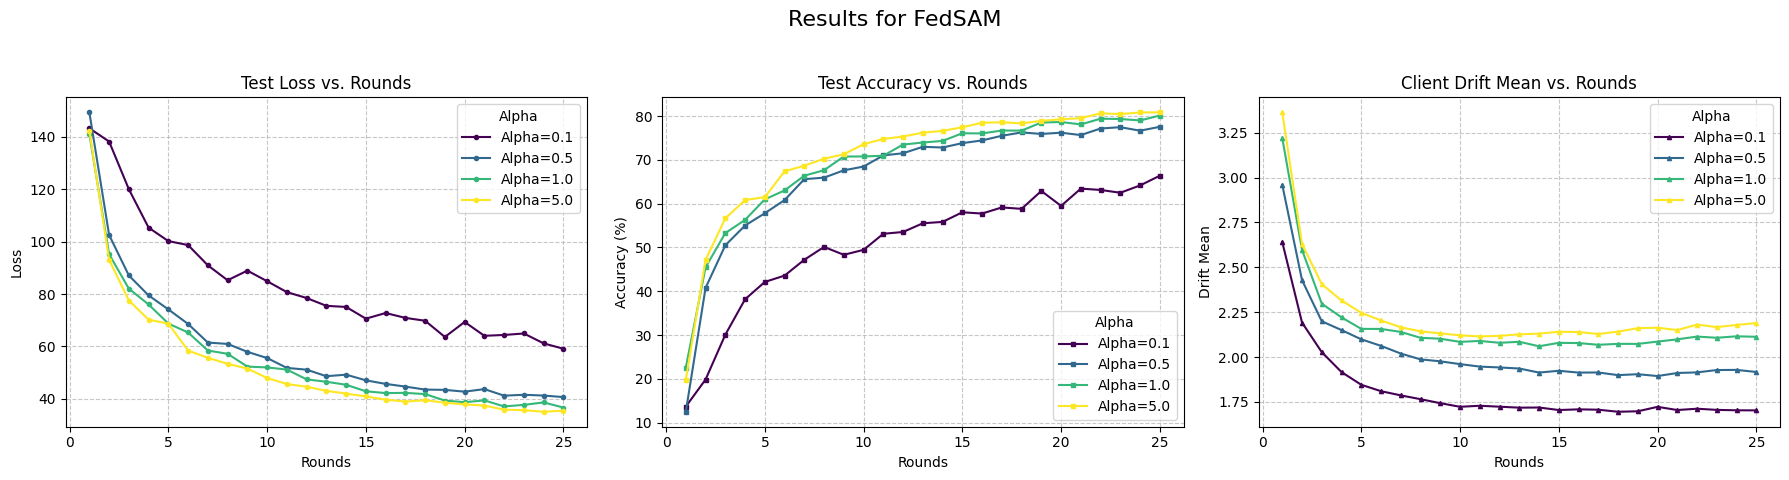

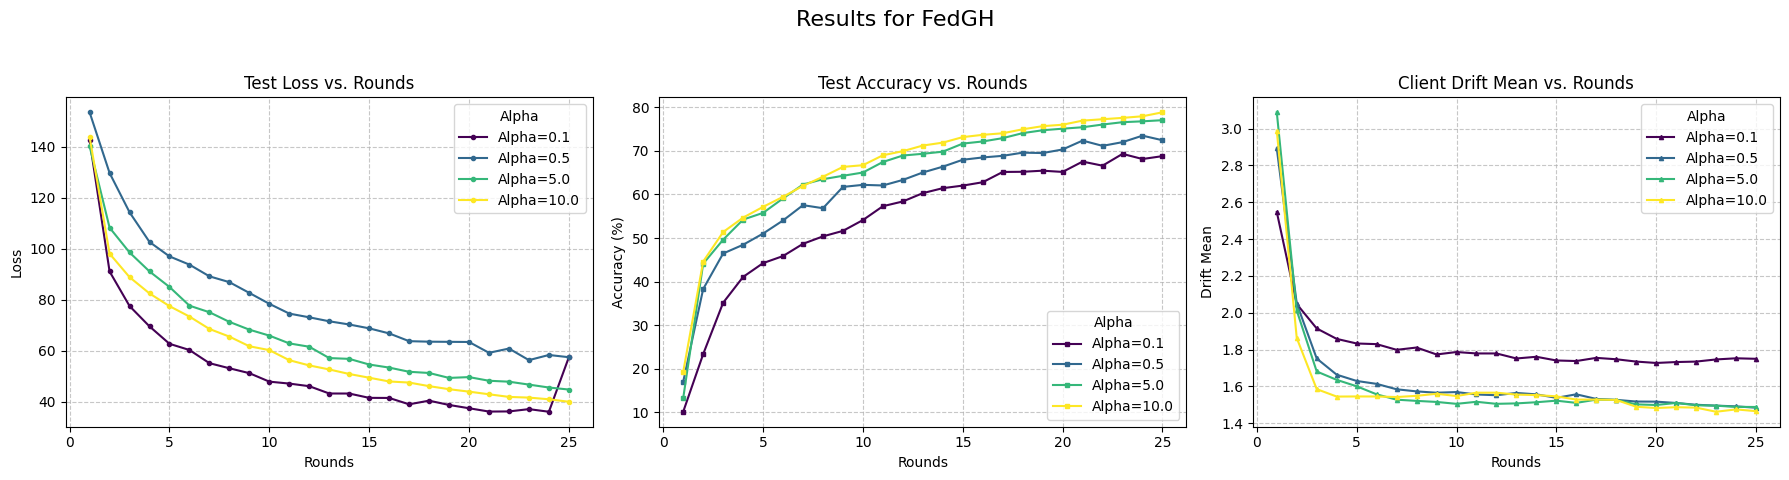

In [93]:
import matplotlib.pyplot as plt
import numpy as np

def plot_method(method_name, losses_dict, accuracies_dict, drifts_dict=None):
    
    num_plots = 3 if drifts_dict else 2
    fig, axes = plt.subplots(1, num_plots, figsize=(6 * num_plots, 5))
    fig.suptitle(f'Results for {method_name}', fontsize=16)
    

    alphas = sorted(losses_dict.keys())
    colors = plt.cm.viridis(np.linspace(0, 1, len(alphas)))


    for i, alpha in enumerate(alphas):
        rounds = range(1, len(losses_dict[alpha]) + 1)
        axes[0].plot(rounds, losses_dict[alpha], label=f'Alpha={alpha}', color=colors[i], marker='o', markersize=3)
    
    axes[0].set_title('Test Loss vs. Rounds')
    axes[0].set_xlabel('Rounds')
    axes[0].set_ylabel('Loss')
    axes[0].grid(True, linestyle='--', alpha=0.7)
    axes[0].legend(title="Alpha")


    for i, alpha in enumerate(alphas):
        rounds = range(1, len(accuracies_dict[alpha]) + 1)
        axes[1].plot(rounds, accuracies_dict[alpha], label=f'Alpha={alpha}', color=colors[i], marker='s', markersize=3)
    
    axes[1].set_title('Test Accuracy vs. Rounds')
    axes[1].set_xlabel('Rounds')
    axes[1].set_ylabel('Accuracy (%)')
    axes[1].grid(True, linestyle='--', alpha=0.7)
    axes[1].legend(title="Alpha")

    
    if drifts_dict:
        for i, alpha in enumerate(alphas):
            if alpha in drifts_dict: 
                rounds = range(1, len(drifts_dict[alpha]) + 1)
                axes[2].plot(rounds, drifts_dict[alpha], label=f'Alpha={alpha}', color=colors[i], marker='^', markersize=3)
        
        axes[2].set_title('Client Drift Mean vs. Rounds')
        axes[2].set_xlabel('Rounds')
        axes[2].set_ylabel('Drift Mean')
        axes[2].grid(True, linestyle='--', alpha=0.7)
        axes[2].legend(title="Alpha")

    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) 
    plt.show()


plot_method("FedSAM", fedsam_losses, fedsam_accuracies, fedsam_drift_means)

plot_method("FedGH", fedgh_losses, fedgh_accuracies, fedgh_drift_means)